In [1]:
%pip install scikit-image pandas matplotlib tqdm torchinfo tensorboard wandb scikit-learn pytorch-msssim opencv-python


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
import psutil
from util import format
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import DeepLenseSuperresolutionDataset
import matplotlib.pyplot as plt 
from torchinfo import summary
from util import run_experiment_task2, MSE_Metric, PSNR_Metric, SSIM_Metric
import math

# PyTorch imports
import torch.nn as nn
import torch.nn.functional as F

class CONFIG:
    BATCH_SIZE = 4
    
    # limit the data to prototype faster
    DATA_LIMIT = 0
    
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ROUND_NUMBER = 3
    TASK_NAME = "DeepLense2024_task2B"
    DATA_PATH = os.path.join("Data", "Task2B")
    PORTION_OF_DATA_FOR_TRAINING = 0.9

In [3]:
memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}")

RAM used : 10.55GB


In [4]:
from tqdm import tqdm
import numpy as np
import random

class DeepLenseSuperresolutionDataset(Dataset):

    def __init__(self, folder_path : str,
                 randomize_dataset : bool = True,
                 preprocess_LR : bool = True, 
                 preprocess_HR : bool = True,
                 call_preprocess : bool = True,
                 data_limit=0, 
                 mean_LR = None, std_LR=None, 
                 mean_HR=None, std_HR=None,
                 task2=False) -> None:
        
        self.folder_path = folder_path
        self.class_folders = []
        self.preprocess_LR = preprocess_LR
        self.preprocess_HR = preprocess_HR

        folders = [os.path.join(self.folder_path, v) for v in os.listdir(folder_path)]

        self.LR = [v for v in folders if v.endswith("LR")][0]
        self.HR = [v for v in folders if v.endswith("HR")][0]

        self.class_folders = [self.LR, self.HR]
        
        print(self.LR, self.HR)
        print(len(os.listdir(self.LR)) == len(os.listdir(self.HR)) )
        assert len(os.listdir(self.LR)) != (os.listdir(self.HR)), "the number of samples in Low Resolution has to be the same as High Resolution"

        # get the samples 
        self.samples = os.listdir(self.LR)
        
        # limit the data (for faster prototyping )
        if data_limit > 0:
            self.samples = self.samples[:data_limit]
                
        # Datapoints
        self.LR_data = []
        self.HR_data = []
            
        pbar = tqdm(self.samples)
        for path in pbar:
            # load from the low resolution
            img1 = np.load(os.path.join(self.LR, path))
            self.LR_data.append(torch.Tensor(img1))            
            
            if task2:
            # load from the high resolution=
                img2 = np.load(os.path.join(self.HR, "HR_" + path[3:]))
            else:
                img2 = np.load(os.path.join(self.HR, path))
                

            self.HR_data.append(torch.Tensor(img2))
            
            pbar.set_description("Loading dataset : ")
        
        self.samples = np.array(self.samples)
        self.LR_data = torch.stack(self.LR_data)
        self.HR_data = torch.stack(self.HR_data)
        
        if randomize_dataset:
            self.randomize_dataset()
        
    # To override later (if any preprocessing is required)
    def preprocess_LR_func(self, x : torch.Tensor) -> torch.Tensor:
        return x
        
    def preprocess_HR_func(self, x : torch.Tensor) -> torch.Tensor:
        return x
        

    def randomize_dataset(self):
        idxes = np.arange(len(self.LR_data))
        random.shuffle(idxes)

        self.samples = self.samples[idxes]
        self.LR_data = self.LR_data[idxes]
        self.HR_data = self.HR_data[idxes]
    
    def preprocess_input(self, x : np.ndarray) -> torch.Tensor:
        return torch.tensor( (x - self.mean) / self.std).float()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.LR_data[idx], self.HR_data[idx]
    

In [5]:
dataset = DeepLenseSuperresolutionDataset(folder_path=CONFIG.DATA_PATH, 
                                          randomize_dataset=True,
                                          data_limit=CONFIG.DATA_LIMIT,
                                          task2=True)

# do train/val split
dataset_size = len(dataset)
train_size = int(dataset_size * CONFIG.PORTION_OF_DATA_FOR_TRAINING)
val_size = dataset_size - train_size

print(f"splitting into : {train_size} {val_size}")

# splitting dataset 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"sizes of datasets : len(train)={len(train_dataset)} len(val)={len(val_dataset)}")

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE)

Data/Task2B/LR Data/Task2B/HR
True


Loading dataset : : 100%|██████████| 300/300 [00:00<00:00, 791.03it/s]


splitting into : 270 30
sizes of datasets : len(train)=270 len(val)=30


In [6]:
# get sample batch, useful for prototyping the architectures
x, y = next(iter(train_loader))

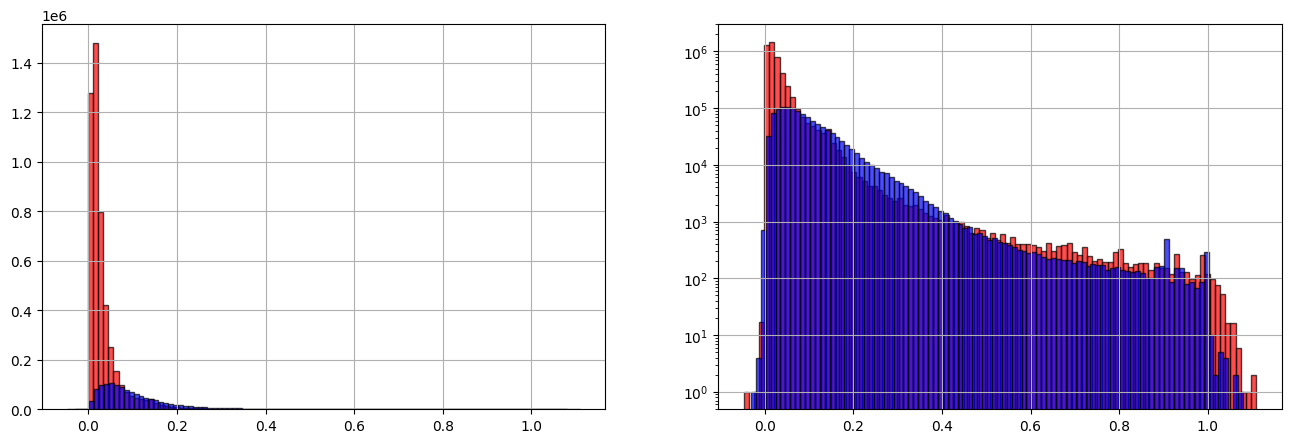

In [7]:
# sanity check 
a = 0.7
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.yscale("log")
plt.grid()
plt.show()


In [8]:
memory_after = psutil.virtual_memory()
print(f"RAM used : {format(memory_after.used)}, RAM free : {format(memory_after.free)}, memory used : {format(memory_after.used - memory_start.used)}")

RAM used : 10.6GB, RAM free : 118.47GB, memory used : 46.53MB


shape of x = torch.Size([4, 1, 64, 64]), y = torch.Size([4, 1, 128, 128])


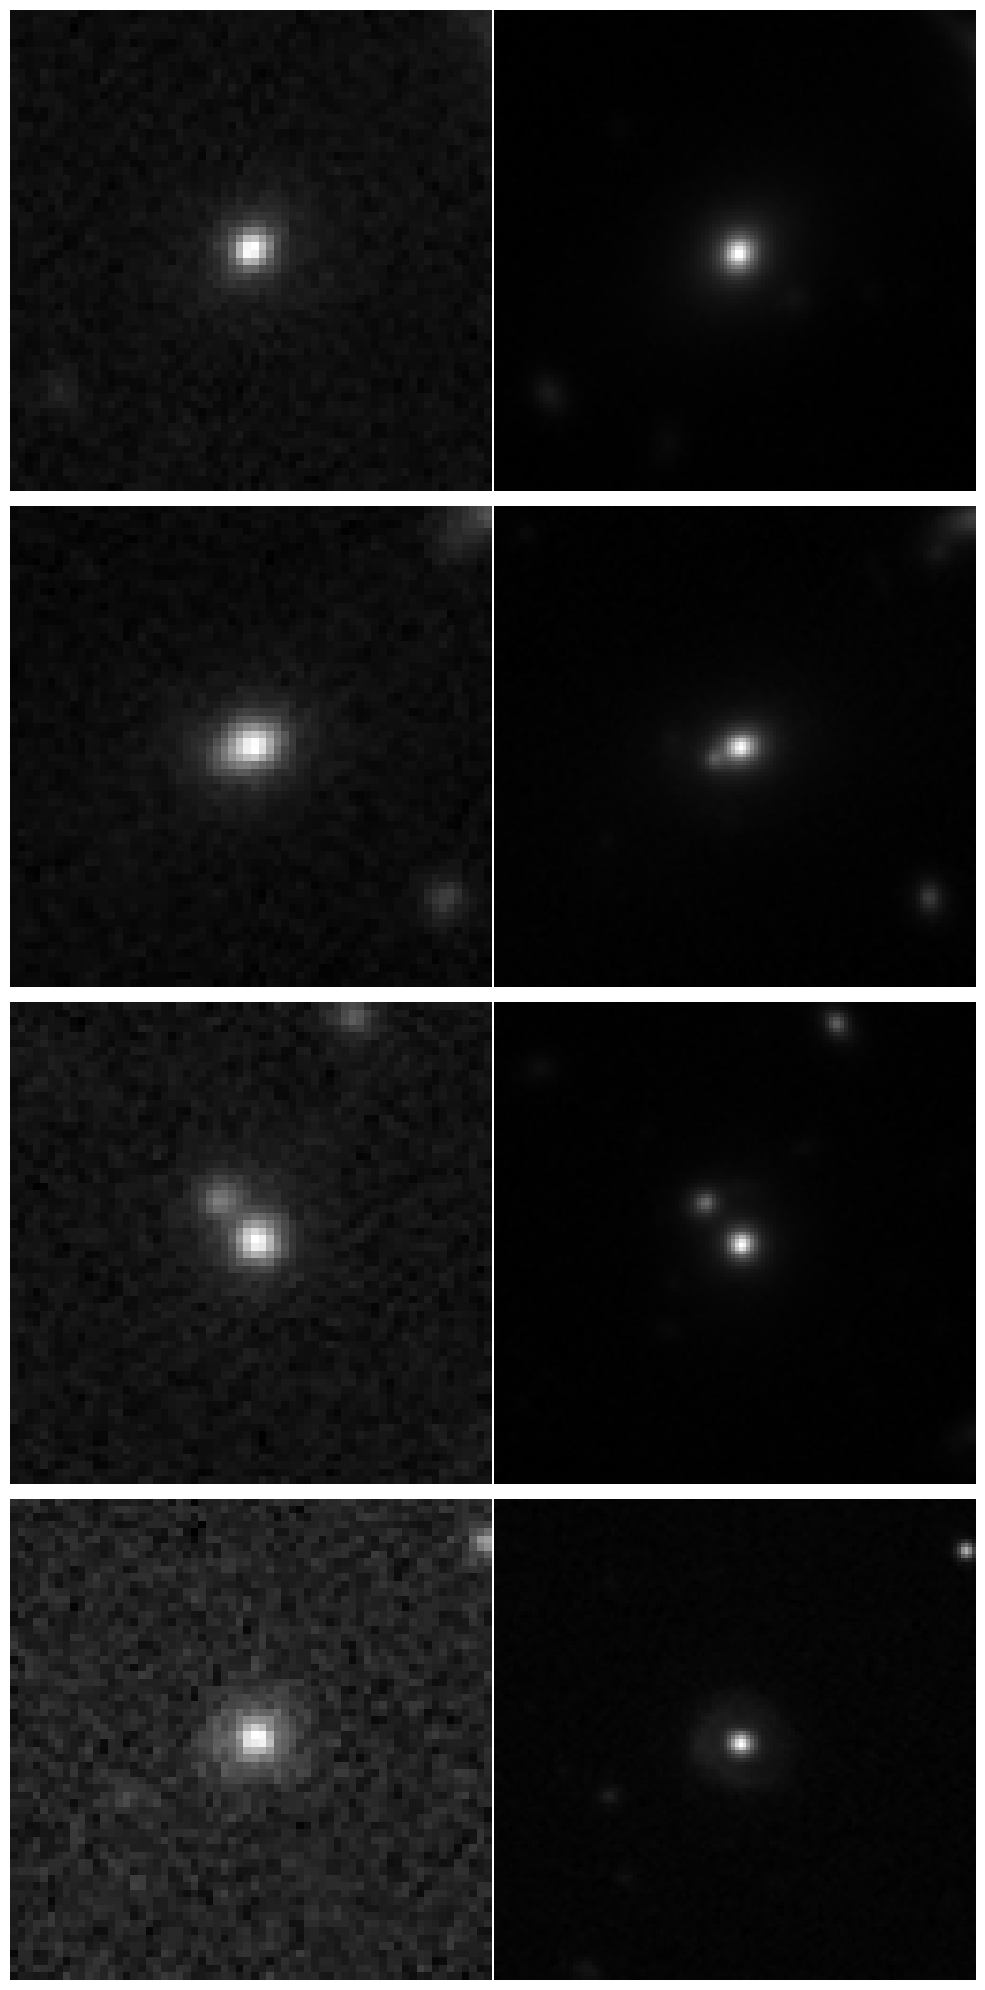

In [9]:
x, y = next(iter(val_loader))

print(f"shape of x = {x.shape}, y = {y.shape}")

plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

size_of_one = 5
fig, axes = plt.subplots(plot_size*plot_size, 2, figsize=(size_of_one * plot_size, size_of_one * len(x)))

for i, ax in enumerate(axes.flat):
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    if i % 2 == 0:
        img = x[i//2].numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap="gray")
        ax.axis('off')
    else:
        img = y[i//2].numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

# SRCNN- 
Paper : https://arxiv.org/abs/1501.000
- two version : start with the model trained on the simulation data, and train from scratch for every version on of upsampling92

## SRCNN with UpSample layer

In [26]:
class SRCNN_upsampler(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_upsampler, self).__init__()
        
        self.upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)        
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.upsampler is not None:
            x = self.upsampler(x)
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

In [27]:
model  = SRCNN_upsampler()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_upsampler                          [4, 1, 128, 128]          --
├─Upsample: 1-1                          [4, 1, 128, 128]          --
├─Sequential: 1-2                        [4, 128, 128, 128]        --
│    └─Conv2d: 2-1                       [4, 128, 128, 128]        10,496
│    └─ReLU: 2-2                         [4, 128, 128, 128]        --
├─Sequential: 1-3                        [4, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [4, 64, 128, 128]         204,864
│    └─ReLU: 2-4                         [4, 64, 128, 128]         --
├─Conv2d: 1-4                            [4, 1, 128, 128]          1,601
Total params: 216,961
Trainable params: 216,961
Non-trainable params: 0
Total mult-adds (G): 14.22
Input size (MB): 0.07
Forward/backward pass size (MB): 101.19
Params size (MB): 0.87
Estimated Total Size (MB): 102.12

In [32]:
import util
# Run with starting point
util.run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_upsampler, 
                     run_name="SRCNN_upsample", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=5e-5, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample-2B.pth",
                     saved_path_file="models/srcnn_upsample.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=1e-5,
                     cosine_annealer_epochs=10,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

loaded state dict!


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


examples seen so far : 270 Mean Squared Error (MSE)=0.009354476097470917 ; PSNR=22.880665346592334 ; SSIM=0.40920624527457033 ; : 100%|██████████| 68/68 [00:00<00:00, 136.09it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.00918246014445121 ; PSNR=24.25338988468565 ; SSIM=0.48528809434381026 ; : 100%|██████████| 8/8 [00:00<00:00, 112.01it/s]
EPOCH : 0, average loss : 0.0024441610859118074, lr=5e-05: 100%|██████████| 68/68 [00:00<00:00, 90.97it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015795737658646806 ; PSNR=31.640447485402614 ; SSIM=0.7405449471342962 ; : 100%|██████████| 68/68 [00:00<00:00, 142.81it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0011503546767675414 ; PSNR=31.181796435652107 ; SSIM=0.7275770471013826 ; : 100%|██████████| 8/8 [00:00<00:00, 127.99it/s]


Saving metric with val_PSNR=31.225843111673992 (previous : 0)


EPOCH : 1, average loss : 0.001562895229760804, lr=4.9021130325903075e-05: 100%|██████████| 68/68 [00:00<00:00, 170.97it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014377567339305538 ; PSNR=32.435089611209456 ; SSIM=0.7772551168822666 ; : 100%|██████████| 68/68 [00:00<00:00, 140.63it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000998329777663959 ; PSNR=31.798819969440327 ; SSIM=0.7530371248722076 ; : 100%|██████████| 8/8 [00:00<00:00, 131.26it/s]


Saving metric with val_PSNR=31.882529322306315 (previous : 31.225843111673992)


EPOCH : 2, average loss : 0.001431726226976881, lr=4.618033988749895e-05: 100%|██████████| 68/68 [00:00<00:00, 172.28it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014562356121379139 ; PSNR=32.26601569094179 ; SSIM=0.7634768346705402 ; : 100%|██████████| 68/68 [00:00<00:00, 143.68it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.00103097601170483 ; PSNR=31.904816528846478 ; SSIM=0.7798644407042141 ; : 100%|██████████| 8/8 [00:00<00:00, 125.37it/s]


Saving metric with val_PSNR=31.93417886098226 (previous : 31.882529322306315)


EPOCH : 3, average loss : 0.0014090886179474182, lr=4.1755705045849464e-05: 100%|██████████| 68/68 [00:00<00:00, 170.86it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013491857152376592 ; PSNR=32.875073939894214 ; SSIM=0.8034980430035786 ; : 100%|██████████| 68/68 [00:00<00:00, 140.03it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0008726790670309505 ; PSNR=32.31450784617457 ; SSIM=0.799141014444417 ; : 100%|██████████| 8/8 [00:00<00:00, 131.06it/s]


Saving metric with val_PSNR=32.40310122172038 (previous : 31.93417886098226)


EPOCH : 4, average loss : 0.0013635365004815599, lr=3.6180339887498953e-05: 100%|██████████| 68/68 [00:00<00:00, 172.37it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001328053679467083 ; PSNR=33.17707032696465 ; SSIM=0.8144447593690073 ; : 100%|██████████| 68/68 [00:00<00:00, 142.52it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.000835662709693585 ; PSNR=32.59320706334607 ; SSIM=0.8065563512259516 ; : 100%|██████████| 8/8 [00:00<00:00, 132.06it/s]


Saving metric with val_PSNR=32.69769967397054 (previous : 32.40310122172038)


EPOCH : 5, average loss : 0.0013479579930015676, lr=3.0000000000000004e-05: 100%|██████████| 68/68 [00:00<00:00, 171.33it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013026283910512304 ; PSNR=33.434084644104914 ; SSIM=0.813444245149655 ; : 100%|██████████| 68/68 [00:00<00:00, 139.97it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0008166620270991377 ; PSNR=32.871547567433325 ; SSIM=0.808824065430411 ; : 100%|██████████| 8/8 [00:00<00:00, 129.31it/s]


Saving metric with val_PSNR=32.96904296875 (previous : 32.69769967397054)


EPOCH : 6, average loss : 0.0013138775639698211, lr=2.3819660112501058e-05: 100%|██████████| 68/68 [00:00<00:00, 170.54it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001290087350634975 ; PSNR=33.49012785773295 ; SSIM=0.810165387796425 ; : 100%|██████████| 68/68 [00:00<00:00, 142.33it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007992016567029701 ; PSNR=32.998678338938745 ; SSIM=0.8118257933649523 ; : 100%|██████████| 8/8 [00:00<00:00, 117.92it/s]


Saving metric with val_PSNR=33.08647861480713 (previous : 32.96904296875)


EPOCH : 7, average loss : 0.0012944076272962026, lr=1.8244294954150544e-05: 100%|██████████| 68/68 [00:00<00:00, 104.87it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013231543170890406 ; PSNR=33.14868146336212 ; SSIM=0.7867026300789255 ; : 100%|██████████| 68/68 [00:00<00:00, 88.86it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0008385444997312052 ; PSNR=32.845027660501415 ; SSIM=0.8023664026424803 ; : 100%|██████████| 8/8 [00:00<00:00, 130.81it/s]
EPOCH : 8, average loss : 0.0013032918714623734, lr=1.3819660112501056e-05: 100%|██████████| 68/68 [00:00<00:00, 162.90it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012746640688595387 ; PSNR=33.56641644970635 ; SSIM=0.8096520908481569 ; : 100%|██████████| 68/68 [00:00<00:00, 100.77it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0007821191619110197 ; PSNR=33.106499178656215 ; SSIM=0.814098252304669 ; : 100%|██████████| 8/8 [00:00<00:00, 127.49it/s]


Saving metric with val_PSNR=33.18781693776449 (previous : 33.08647861480713)


EPOCH : 9, average loss : 0.001271869758484707, lr=1.097886967409693e-05: 100%|██████████| 68/68 [00:00<00:00, 171.33it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012667399025783998 ; PSNR=33.662014390456186 ; SSIM=0.8157396523704316 ; : 100%|██████████| 68/68 [00:00<00:00, 140.35it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0007679861722361489 ; PSNR=33.180876435904665 ; SSIM=0.8175422261501181 ; : 100%|██████████| 8/8 [00:00<00:00, 126.17it/s]


Saving metric with val_PSNR=33.272675387064616 (previous : 33.18781693776449)


EPOCH : 10, average loss : 0.0012670693741871648, lr=1e-05: 100%|██████████| 68/68 [00:00<00:00, 76.24it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001272437262207531 ; PSNR=33.77042819664824 ; SSIM=0.8256511655688065 ; : 100%|██████████| 68/68 [00:00<00:00, 130.30it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007643099961569533 ; PSNR=33.253570227787414 ; SSIM=0.820606320068754 ; : 100%|██████████| 8/8 [00:00<00:00, 134.03it/s]


Saving metric with val_PSNR=33.36505438486735 (previous : 33.272675387064616)


EPOCH : 11, average loss : 0.0012714367095374175, lr=1.097886967409693e-05: 100%|██████████| 68/68 [00:00<00:00, 110.26it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012670465377771787 ; PSNR=33.768864039594796 ; SSIM=0.8243723886163704 ; : 100%|██████████| 68/68 [00:00<00:00, 95.06it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0007581780085055126 ; PSNR=33.26782904000118 ; SSIM=0.8216847756813312 ; : 100%|██████████| 8/8 [00:00<00:00, 131.28it/s]


Saving metric with val_PSNR=33.376875241597496 (previous : 33.36505438486735)


EPOCH : 12, average loss : 0.0012694945180555806, lr=1.3819660112501066e-05: 100%|██████████| 68/68 [00:00<00:00, 172.04it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012542881318192746 ; PSNR=33.68196604065736 ; SSIM=0.813835985432327 ; : 100%|██████████| 68/68 [00:00<00:00, 144.61it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007492990375010714 ; PSNR=33.25483111677499 ; SSIM=0.8195567511279007 ; : 100%|██████████| 8/8 [00:00<00:00, 132.58it/s]
EPOCH : 13, average loss : 0.001258823886018945, lr=1.824429495415057e-05: 100%|██████████| 68/68 [00:00<00:00, 171.75it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012472105676061163 ; PSNR=33.81635490757825 ; SSIM=0.8193079524683908 ; : 100%|██████████| 68/68 [00:00<00:00, 87.03it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007398015032181163 ; PSNR=33.366865486934266 ; SSIM=0.8221538745123764 ; : 100%|██████████| 8/8 [00:00<00:00, 41.67it/s]


Saving metric with val_PSNR=33.461211649576825 (previous : 33.376875241597496)


EPOCH : 14, average loss : 0.0012702378534253083, lr=2.381966011250111e-05: 100%|██████████| 68/68 [00:00<00:00, 162.91it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012595690477813194 ; PSNR=33.51961129482794 ; SSIM=0.7980051002427104 ; : 100%|██████████| 68/68 [00:00<00:00, 144.00it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0007624816832409626 ; PSNR=33.20162898096545 ; SSIM=0.8119352840144058 ; : 100%|██████████| 8/8 [00:00<00:00, 135.26it/s]
EPOCH : 15, average loss : 0.0012468581656267976, lr=3.000000000000008e-05: 100%|██████████| 68/68 [00:00<00:00, 173.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012349878861337336 ; PSNR=33.92887119732825 ; SSIM=0.8264306280138768 ; : 100%|██████████| 68/68 [00:00<00:00, 121.93it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0007298310249160718 ; PSNR=33.42832808658994 ; SSIM=0.8272083720256542 ; : 100%|██████████| 8/8 [00:00<00:00, 58.86it/s]


Saving metric with val_PSNR=33.53580824534098 (previous : 33.461211649576825)


EPOCH : 16, average loss : 0.0012608667375923902, lr=3.6180339887499055e-05: 100%|██████████| 68/68 [00:00<00:00, 99.44it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001225837577449969 ; PSNR=33.37612762947508 ; SSIM=0.7892039848083013 ; : 100%|██████████| 68/68 [00:00<00:00, 142.37it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007672280568432802 ; PSNR=33.110013172544285 ; SSIM=0.806531868104277 ; : 100%|██████████| 8/8 [00:00<00:00, 128.00it/s]
EPOCH : 17, average loss : 0.0012648607118856436, lr=4.175570504584959e-05: 100%|██████████| 68/68 [00:00<00:00, 172.08it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012249696295345755 ; PSNR=33.9083305238348 ; SSIM=0.8137030961843671 ; : 100%|██████████| 68/68 [00:00<00:00, 126.08it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007311812509654154 ; PSNR=33.511791755413185 ; SSIM=0.8224662429299848 ; : 100%|██████████| 8/8 [00:00<00:00, 38.38it/s]


Saving metric with val_PSNR=33.58577168782552 (previous : 33.53580824534098)


EPOCH : 18, average loss : 0.0012608056861020433, lr=4.61803398874991e-05: 100%|██████████| 68/68 [00:00<00:00, 110.59it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012278904065020863 ; PSNR=33.573073482867954 ; SSIM=0.7942955839035679 ; : 100%|██████████| 68/68 [00:00<00:00, 135.58it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0007373260362736142 ; PSNR=33.2986823772562 ; SSIM=0.8114663937996174 ; : 100%|██████████| 8/8 [00:00<00:00, 133.73it/s]
EPOCH : 19, average loss : 0.0012926513937760748, lr=4.902113032590324e-05: 100%|██████████| 68/68 [00:00<00:00, 168.74it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012240177552197578 ; PSNR=33.73433767198187 ; SSIM=0.8036323269226737 ; : 100%|██████████| 68/68 [00:00<00:00, 132.81it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.000726924511927164 ; PSNR=33.41624148138638 ; SSIM=0.8177143160639138 ; : 100%|██████████| 8/8 [00:00<00:00, 122.24it/s]
EPOCH : 20, average loss : 0.0013175965233291

Saving metric with val_PSNR=33.901412900288896 (previous : 33.58577168782552)


EPOCH : 21, average loss : 0.0012689836854834163, lr=4.902113032590323e-05: 100%|██████████| 68/68 [00:00<00:00, 107.34it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011886765532700611 ; PSNR=34.13925482881113 ; SSIM=0.8206830835142986 ; : 100%|██████████| 68/68 [00:00<00:00, 143.85it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006947721947277575 ; PSNR=33.75345986464928 ; SSIM=0.8274920808857885 ; : 100%|██████████| 8/8 [00:00<00:00, 132.04it/s]
EPOCH : 22, average loss : 0.0012197276996363036, lr=4.618033988749911e-05: 100%|██████████| 68/68 [00:00<00:00, 171.32it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011909896208084367 ; PSNR=34.22769829420352 ; SSIM=0.8269281555867328 ; : 100%|██████████| 68/68 [00:00<00:00, 142.05it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006910262481110765 ; PSNR=33.833615270154226 ; SSIM=0.8317294583238405 ; : 100%|██████████| 8/8 [00:00<00:00, 130.53it/s]


Saving metric with val_PSNR=33.925340016682945 (previous : 33.901412900288896)


EPOCH : 23, average loss : 0.0011950865684732836, lr=4.175570504584959e-05: 100%|██████████| 68/68 [00:00<00:00, 73.22it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011893969204622584 ; PSNR=34.31664270096109 ; SSIM=0.831825392549255 ; : 100%|██████████| 68/68 [00:01<00:00, 44.58it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006909243614966821 ; PSNR=33.89303161358011 ; SSIM=0.8332705939638203 ; : 100%|██████████| 8/8 [00:00<00:00, 122.13it/s]


Saving metric with val_PSNR=33.99445069630941 (previous : 33.925340016682945)


EPOCH : 24, average loss : 0.001195289834012168, lr=3.6180339887499055e-05: 100%|██████████| 68/68 [00:00<00:00, 163.56it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011911727180097514 ; PSNR=34.054816554470136 ; SSIM=0.824448939343589 ; : 100%|██████████| 68/68 [00:00<00:00, 141.17it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006936838689053448 ; PSNR=33.62059705010776 ; SSIM=0.8323723910183742 ; : 100%|██████████| 8/8 [00:00<00:00, 132.40it/s]
EPOCH : 25, average loss : 0.0012178570879554814, lr=3.0000000000000085e-05: 100%|██████████| 68/68 [00:00<00:00, 170.91it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011787923785046843 ; PSNR=34.162788369841735 ; SSIM=0.8199803195755277 ; : 100%|██████████| 68/68 [00:00<00:00, 142.45it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006957532926302018 ; PSNR=33.80333538713126 ; SSIM=0.8275607947645516 ; : 100%|██████████| 8/8 [00:00<00:00, 121.81it/s]
EPOCH : 26, average loss : 0.00119113545

Saving metric with val_PSNR=34.05917911529541 (previous : 33.99445069630941)


EPOCH : 28, average loss : 0.0011759208485754619, lr=1.3819660112501073e-05: 100%|██████████| 68/68 [00:00<00:00, 171.49it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011678543651958394 ; PSNR=34.27855349473351 ; SSIM=0.823265839077283 ; : 100%|██████████| 68/68 [00:00<00:00, 143.44it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006894273225545225 ; PSNR=33.852688953794285 ; SSIM=0.8299692848633076 ; : 100%|██████████| 8/8 [00:00<00:00, 131.00it/s]
EPOCH : 29, average loss : 0.0011671785404734477, lr=1.0978869674096937e-05: 100%|██████████| 68/68 [00:00<00:00, 169.02it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001167434791473998 ; PSNR=34.35364892314358 ; SSIM=0.8279227924612819 ; : 100%|██████████| 68/68 [00:00<00:00, 139.69it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006853652365830855 ; PSNR=33.92762730039399 ; SSIM=0.8316887874027779 ; : 100%|██████████| 8/8 [00:00<00:00, 131.29it/s]
EPOCH : 30, average loss : 0.00115936677

Saving metric with val_PSNR=34.121693229675294 (previous : 34.05917911529541)


EPOCH : 31, average loss : 0.0011706158848563278, lr=1.097886967409693e-05: 100%|██████████| 68/68 [00:00<00:00, 149.33it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011681495198801889 ; PSNR=34.38867856135599 ; SSIM=0.8322087638634067 ; : 100%|██████████| 68/68 [00:00<00:00, 142.42it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006793949409068867 ; PSNR=33.952922952586206 ; SSIM=0.8343630895532411 ; : 100%|██████████| 8/8 [00:00<00:00, 123.43it/s]
EPOCH : 32, average loss : 0.0011764117758395836, lr=1.3819660112501056e-05: 100%|██████████| 68/68 [00:00<00:00, 108.98it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011605624874077216 ; PSNR=34.33994544926186 ; SSIM=0.8256784517414951 ; : 100%|██████████| 68/68 [00:00<00:00, 137.55it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.000679583723279487 ; PSNR=33.912543198158 ; SSIM=0.8319469258703035 ; : 100%|██████████| 8/8 [00:00<00:00, 132.30it/s]
EPOCH : 33, average loss : 0.00119213930905

Saving metric with val_PSNR=34.261757405598956 (previous : 34.121693229675294)


EPOCH : 42, average loss : 0.001167816601724446, lr=4.618033988749905e-05: 100%|██████████| 68/68 [00:00<00:00, 171.38it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011657789431863549 ; PSNR=34.56995668021276 ; SSIM=0.8429323986698926 ; : 100%|██████████| 68/68 [00:00<00:00, 144.48it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006794950154314926 ; PSNR=34.075836510493836 ; SSIM=0.8387580719487421 ; : 100%|██████████| 8/8 [00:00<00:00, 133.88it/s]
EPOCH : 43, average loss : 0.0011576147136271604, lr=4.175570504584955e-05: 100%|██████████| 68/68 [00:00<00:00, 169.81it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011752563832386363 ; PSNR=34.27360072366367 ; SSIM=0.8379719046301115 ; : 100%|██████████| 68/68 [00:00<00:00, 105.84it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006902412720153045 ; PSNR=33.740019239228346 ; SSIM=0.839419207696257 ; : 100%|██████████| 8/8 [00:00<00:00, 27.06it/s] 
EPOCH : 44, average loss : 0.001183756125

Saving metric with val_PSNR=34.27725989023845 (previous : 34.261757405598956)


EPOCH : 57, average loss : 0.0011744019961684791, lr=4.1755705045849945e-05: 100%|██████████| 68/68 [00:00<00:00, 159.79it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011346882503222436 ; PSNR=34.28430382824298 ; SSIM=0.8224675513831656 ; : 100%|██████████| 68/68 [00:00<00:00, 108.12it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006836332207152234 ; PSNR=33.801641069609545 ; SSIM=0.8313077400470602 ; : 100%|██████████| 8/8 [00:00<00:00, 124.34it/s]
EPOCH : 58, average loss : 0.0011274034147979418, lr=4.6180339887499535e-05: 100%|██████████| 68/68 [00:00<00:00, 170.89it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011502490828862563 ; PSNR=34.84909342655905 ; SSIM=0.8479951736846156 ; : 100%|██████████| 68/68 [00:00<00:00, 144.03it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006758143786884893 ; PSNR=34.32828442803745 ; SSIM=0.8394595949814238 ; : 100%|██████████| 8/8 [00:00<00:00, 129.77it/s]


Saving metric with val_PSNR=34.43535614013672 (previous : 34.27725989023845)


EPOCH : 59, average loss : 0.0011920793956104556, lr=4.902113032590369e-05: 100%|██████████| 68/68 [00:00<00:00, 169.31it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011967480704460993 ; PSNR=34.33573333570062 ; SSIM=0.8472731741055237 ; : 100%|██████████| 68/68 [00:00<00:00, 141.75it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0007099773223483775 ; PSNR=33.70346457382728 ; SSIM=0.8414102217246746 ; : 100%|██████████| 8/8 [00:00<00:00, 129.88it/s]
EPOCH : 60, average loss : 0.0011638016324414982, lr=5.000000000000065e-05: 100%|██████████| 68/68 [00:00<00:00, 170.43it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011346723306351766 ; PSNR=34.55327500552493 ; SSIM=0.8368675550895995 ; : 100%|██████████| 68/68 [00:00<00:00, 140.40it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006590199110836819 ; PSNR=34.05950651497677 ; SSIM=0.8398048846886076 ; : 100%|██████████| 8/8 [00:00<00:00, 134.03it/s]
EPOCH : 61, average loss : 0.0011593920604

Saving metric with val_PSNR=34.46590754191081 (previous : 34.43535614013672)


EPOCH : 78, average loss : 0.0011429120798257988, lr=4.618033988749877e-05: 100%|██████████| 68/68 [00:00<00:00, 171.91it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011396423180424868 ; PSNR=34.22477199242461 ; SSIM=0.8296391076259454 ; : 100%|██████████| 68/68 [00:00<00:00, 135.08it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006636856759824099 ; PSNR=33.77522001595333 ; SSIM=0.8375313590312826 ; : 100%|██████████| 8/8 [00:00<00:00, 130.60it/s]
EPOCH : 79, average loss : 0.0011902294463652652, lr=4.902113032590289e-05: 100%|██████████| 68/68 [00:00<00:00, 171.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011396899066325994 ; PSNR=34.27318217054176 ; SSIM=0.8259339749425317 ; : 100%|██████████| 68/68 [00:00<00:00, 142.92it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006724488058384379 ; PSNR=33.912128382715686 ; SSIM=0.8345195959354269 ; : 100%|██████████| 8/8 [00:00<00:00, 131.96it/s]
EPOCH : 80, average loss : 0.001141824800

loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▇▇▇▇▇▇▇█████▇██████████████████▇█████▇
train_SSIM,▁▇▇▇██▇▇▇█████▇██████████████████▇█████▇
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▆▇▇▇▇▇▇▇█████▇██████████████████▇█████▇
val_SSIM,▁▆▇▇██▇▇████████████████████████████████
loss,0.00114
train_Mean Squared Error (MSE),0.00117
train_PSNR,33.88258
train_SSIM,0.81053


In [33]:
import util

util.run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_upsampler, 
                     run_name="SRCNN_upsample_no_starting_point", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample_no_starting_point-2B.pth",
                     saved_path_file=None,#"models/srcnn_upsample.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     cosine_annealer_epochs=10,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

wandb: Currently logged in as: mlewand (mlewand7). Use `wandb login --relogin` to force relogin


examples seen so far : 270 Mean Squared Error (MSE)=0.004278705446058227 ; PSNR=25.37720122922309 ; SSIM=0.26353573454788465 ; : 100%|██████████| 68/68 [00:00<00:00, 141.05it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.003824103934738528 ; PSNR=25.147752893382105 ; SSIM=0.27401461651356057 ; : 100%|██████████| 8/8 [00:00<00:00, 129.52it/s]
EPOCH : 0, average loss : 0.002072182482259129, lr=0.0001: 100%|██████████| 68/68 [00:00<00:00, 91.31it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0015851787163150674 ; PSNR=30.530941910016935 ; SSIM=0.8017698886170707 ; : 100%|██████████| 68/68 [00:00<00:00, 132.30it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0010828394543154743 ; PSNR=30.449981426370556 ; SSIM=0.8146137019683575 ; : 100%|██████████| 8/8 [00:00<00:00, 127.82it/s]


Saving metric with val_PSNR=30.476640383402508 (previous : 0)


EPOCH : 1, average loss : 0.0016184254071798503, lr=9.877641290737885e-05: 100%|██████████| 68/68 [00:00<00:00, 145.76it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015759484225829551 ; PSNR=31.150659408711146 ; SSIM=0.8402626047180931 ; : 100%|██████████| 68/68 [00:00<00:00, 132.65it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0010179469446202033 ; PSNR=30.88013556907917 ; SSIM=0.8303885264643307 ; : 100%|██████████| 8/8 [00:00<00:00, 130.48it/s]


Saving metric with val_PSNR=30.94451160430908 (previous : 30.476640383402508)


EPOCH : 2, average loss : 0.001636333154130946, lr=9.52254248593737e-05: 100%|██████████| 68/68 [00:00<00:00, 171.58it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0016687131445936264 ; PSNR=30.9363049326333 ; SSIM=0.8422337651917482 ; : 100%|██████████| 68/68 [00:00<00:00, 141.78it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0011046020031087742 ; PSNR=30.61943955257021 ; SSIM=0.8310295559208969 ; : 100%|██████████| 8/8 [00:00<00:00, 124.87it/s]
EPOCH : 3, average loss : 0.0014760864933658227, lr=8.969463130731185e-05: 100%|██████████| 68/68 [00:00<00:00, 171.23it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013221924732111179 ; PSNR=32.959095302567604 ; SSIM=0.8356755453830094 ; : 100%|██████████| 68/68 [00:00<00:00, 140.32it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000799675072655724 ; PSNR=32.55495867235907 ; SSIM=0.8269062854092697 ; : 100%|██████████| 8/8 [00:00<00:00, 128.24it/s]


Saving metric with val_PSNR=32.65117232004801 (previous : 30.94451160430908)


EPOCH : 4, average loss : 0.0014170404399063794, lr=8.27254248593737e-05: 100%|██████████| 68/68 [00:00<00:00, 170.12it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012904800529064625 ; PSNR=33.369701878288865 ; SSIM=0.835138154891233 ; : 100%|██████████| 68/68 [00:00<00:00, 142.52it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0007734158719139142 ; PSNR=32.947754366644496 ; SSIM=0.8275782640638023 ; : 100%|██████████| 8/8 [00:00<00:00, 128.16it/s]


Saving metric with val_PSNR=33.04917074839274 (previous : 32.65117232004801)


EPOCH : 5, average loss : 0.0013461018692503463, lr=7.500000000000001e-05: 100%|██████████| 68/68 [00:00<00:00, 149.13it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012826479308025438 ; PSNR=33.44325950863636 ; SSIM=0.8408710107927428 ; : 100%|██████████| 68/68 [00:00<00:00, 141.80it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0007649613930723341 ; PSNR=32.93881054582267 ; SSIM=0.8314118190058346 ; : 100%|██████████| 8/8 [00:00<00:00, 131.54it/s]


Saving metric with val_PSNR=33.060234451293944 (previous : 33.04917074839274)


EPOCH : 6, average loss : 0.0013150304377417983, lr=6.727457514062632e-05: 100%|██████████| 68/68 [00:00<00:00, 170.20it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012524178773843117 ; PSNR=33.600019589675846 ; SSIM=0.8263340798175468 ; : 100%|██████████| 68/68 [00:00<00:00, 140.78it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000761561651948984 ; PSNR=33.18459372684873 ; SSIM=0.8250842998767721 ; : 100%|██████████| 8/8 [00:00<00:00, 122.87it/s]


Saving metric with val_PSNR=33.25689442952474 (previous : 33.060234451293944)


EPOCH : 7, average loss : 0.001275643369059681, lr=6.030536869268818e-05: 100%|██████████| 68/68 [00:00<00:00, 88.25it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.0013963780658004536 ; PSNR=33.078041643901386 ; SSIM=0.8466820280486544 ; : 100%|██████████| 68/68 [00:00<00:00, 91.63it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.000877169110402786 ; PSNR=32.4667942441743 ; SSIM=0.8315617812090906 ; : 100%|██████████| 8/8 [00:00<00:00, 127.91it/s]
EPOCH : 8, average loss : 0.00127825166354716, lr=5.477457514062632e-05: 100%|██████████| 68/68 [00:00<00:00, 171.34it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.0012680529589048754 ; PSNR=33.48194388563305 ; SSIM=0.83553535606172 ; : 100%|██████████| 68/68 [00:00<00:00, 132.86it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0007500180498905608 ; PSNR=33.02884193946575 ; SSIM=0.8361317145413366 ; : 100%|██████████| 8/8 [00:00<00:00, 121.09it/s]
EPOCH : 9, average loss : 0.001242438119815607

Saving metric with val_PSNR=33.71334768931071 (previous : 33.25689442952474)


EPOCH : 11, average loss : 0.0012439772710743401, lr=5.122358709262116e-05: 100%|██████████| 68/68 [00:00<00:00, 171.23it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001351490210697183 ; PSNR=33.397773097438886 ; SSIM=0.8481255280871817 ; : 100%|██████████| 68/68 [00:00<00:00, 142.65it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0008383096975539329 ; PSNR=32.80432556415426 ; SSIM=0.8365851537934665 ; : 100%|██████████| 8/8 [00:00<00:00, 129.61it/s]
EPOCH : 12, average loss : 0.0012445692171989802, lr=5.477457514062633e-05: 100%|██████████| 68/68 [00:00<00:00, 170.81it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001260911829140038 ; PSNR=33.6522939958537 ; SSIM=0.8409630476486727 ; : 100%|██████████| 68/68 [00:00<00:00, 142.49it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0007566392965161178 ; PSNR=33.13290365811052 ; SSIM=0.8400731847204012 ; : 100%|██████████| 8/8 [00:00<00:00, 130.27it/s]
EPOCH : 13, average loss : 0.00121189986941

Saving metric with val_PSNR=33.83499927520752 (previous : 33.71334768931071)


EPOCH : 16, average loss : 0.001229446306858924, lr=8.27254248593738e-05: 100%|██████████| 68/68 [00:00<00:00, 113.16it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011880602624845522 ; PSNR=34.30795126067662 ; SSIM=0.8370603090325253 ; : 100%|██████████| 68/68 [00:01<00:00, 65.69it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006970610657249224 ; PSNR=33.850945242520034 ; SSIM=0.8396289050579071 ; : 100%|██████████| 8/8 [00:00<00:00, 105.16it/s]


Saving metric with val_PSNR=33.953375562032065 (previous : 33.83499927520752)


EPOCH : 17, average loss : 0.0012070329997667989, lr=8.969463130731197e-05: 100%|██████████| 68/68 [00:00<00:00, 170.92it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001196968833738237 ; PSNR=34.13023421844142 ; SSIM=0.8322757413146886 ; : 100%|██████████| 68/68 [00:00<00:00, 144.18it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007231756408773122 ; PSNR=33.70069858945649 ; SSIM=0.8340420722961426 ; : 100%|██████████| 8/8 [00:00<00:00, 130.29it/s]
EPOCH : 18, average loss : 0.0012179817811770858, lr=9.522542485937386e-05: 100%|██████████| 68/68 [00:00<00:00, 169.54it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012760084285871446 ; PSNR=33.81657048406211 ; SSIM=0.8481839151852193 ; : 100%|██████████| 68/68 [00:00<00:00, 143.28it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0007859635955136237 ; PSNR=33.18903396869528 ; SSIM=0.840276190946842 ; : 100%|██████████| 8/8 [00:00<00:00, 131.40it/s]
EPOCH : 19, average loss : 0.00120515186940

Saving metric with val_PSNR=33.95954856872559 (previous : 33.953375562032065)


EPOCH : 25, average loss : 0.001208110350810731, lr=7.500000000000009e-05: 100%|██████████| 68/68 [00:00<00:00, 118.94it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011787574455232037 ; PSNR=34.33421528826859 ; SSIM=0.8400402709453966 ; : 100%|██████████| 68/68 [00:01<00:00, 39.71it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006867891046066029 ; PSNR=33.89417931129192 ; SSIM=0.8410480053260408 ; : 100%|██████████| 8/8 [00:00<00:00, 110.84it/s]


Saving metric with val_PSNR=34.00235538482666 (previous : 33.95954856872559)


EPOCH : 26, average loss : 0.0011620794183031917, lr=6.727457514062637e-05: 100%|██████████| 68/68 [00:00<00:00, 165.27it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001167098710535613 ; PSNR=33.89957815120655 ; SSIM=0.8099788900423227 ; : 100%|██████████| 68/68 [00:00<00:00, 143.28it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006966398813629298 ; PSNR=33.614251630059606 ; SSIM=0.8262465051535902 ; : 100%|██████████| 8/8 [00:00<00:00, 130.16it/s]
EPOCH : 27, average loss : 0.0011590017437650684, lr=6.030536869268821e-05: 100%|██████████| 68/68 [00:00<00:00, 171.62it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011548969965135129 ; PSNR=34.512557579239065 ; SSIM=0.8382791357052592 ; : 100%|██████████| 68/68 [00:00<00:00, 142.33it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006672658843132828 ; PSNR=34.12669372558594 ; SSIM=0.842238607077763 ; : 100%|██████████| 8/8 [00:00<00:00, 131.68it/s]


Saving metric with val_PSNR=34.2212464650472 (previous : 34.00235538482666)


EPOCH : 28, average loss : 0.0011647946900184786, lr=5.4774575140626335e-05: 100%|██████████| 68/68 [00:00<00:00, 171.88it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011639884434845758 ; PSNR=34.300681408453165 ; SSIM=0.8364079256704748 ; : 100%|██████████| 68/68 [00:01<00:00, 64.56it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006729099890247293 ; PSNR=33.88316897688241 ; SSIM=0.8422882269168722 ; : 100%|██████████| 8/8 [00:00<00:00, 27.53it/s]
EPOCH : 29, average loss : 0.0011623306981003705, lr=5.122358709262117e-05: 100%|██████████| 68/68 [00:00<00:00, 118.44it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001149192709685866 ; PSNR=34.37959661093786 ; SSIM=0.8341160837325465 ; : 100%|██████████| 68/68 [00:00<00:00, 142.82it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006697882922237803 ; PSNR=33.96497976368871 ; SSIM=0.8405647853325153 ; : 100%|██████████| 8/8 [00:00<00:00, 121.06it/s]
EPOCH : 30, average loss : 0.0011518560445

Saving metric with val_PSNR=34.29411347707113 (previous : 34.2212464650472)


EPOCH : 41, average loss : 0.0011572738853026427, lr=9.877641290737888e-05: 100%|██████████| 68/68 [00:00<00:00, 171.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012927157611786959 ; PSNR=32.616303419091885 ; SSIM=0.7817531845992826 ; : 100%|██████████| 68/68 [00:00<00:00, 143.12it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0007995295896323334 ; PSNR=32.73592639791554 ; SSIM=0.8094800443484865 ; : 100%|██████████| 8/8 [00:00<00:00, 129.40it/s]
EPOCH : 42, average loss : 0.0012062452962495359, lr=9.52254248593737e-05: 100%|██████████| 68/68 [00:00<00:00, 169.97it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011682377992531159 ; PSNR=34.00349910551731 ; SSIM=0.8307464054082849 ; : 100%|██████████| 68/68 [00:01<00:00, 37.63it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0007062899653803846 ; PSNR=33.7018116260397 ; SSIM=0.8350097156804184 ; : 100%|██████████| 8/8 [00:00<00:00, 71.39it/s]  
EPOCH : 43, average loss : 0.0011661221541383

Saving metric with val_PSNR=34.36578820546468 (previous : 34.29411347707113)


EPOCH : 54, average loss : 0.001140609149254434, lr=6.727457514062655e-05: 100%|██████████| 68/68 [00:00<00:00, 170.34it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011192150433938046 ; PSNR=34.31860581295198 ; SSIM=0.8264091579333557 ; : 100%|██████████| 68/68 [00:00<00:00, 77.62it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006481753486602021 ; PSNR=33.94872435208025 ; SSIM=0.8371471022737438 ; : 100%|██████████| 8/8 [00:00<00:00, 26.00it/s] 
EPOCH : 55, average loss : 0.001140369415652993, lr=7.500000000000039e-05: 100%|██████████| 68/68 [00:00<00:00, 101.24it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001158781558105685 ; PSNR=34.07452112502768 ; SSIM=0.8280773666379176 ; : 100%|██████████| 68/68 [00:00<00:00, 70.19it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006934041295357145 ; PSNR=33.773590679826405 ; SSIM=0.8356463857765856 ; : 100%|██████████| 8/8 [00:00<00:00, 132.28it/s]
EPOCH : 56, average loss : 0.0011510531013

Saving metric with val_PSNR=34.41190001169841 (previous : 34.36578820546468)


EPOCH : 75, average loss : 0.001120038601263385, lr=7.499999999999978e-05: 100%|██████████| 68/68 [00:00<00:00, 171.23it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011404728086180677 ; PSNR=34.75118439968634 ; SSIM=0.8470353669448856 ; : 100%|██████████| 68/68 [00:00<00:00, 143.64it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006579722009111469 ; PSNR=34.258990189124795 ; SSIM=0.8401378927559688 ; : 100%|██████████| 8/8 [00:00<00:00, 134.13it/s]
EPOCH : 76, average loss : 0.0011546923226834385, lr=8.272542485937345e-05: 100%|██████████| 68/68 [00:00<00:00, 168.16it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011190378885130553 ; PSNR=34.483043294856984 ; SSIM=0.8341266988710843 ; : 100%|██████████| 68/68 [00:00<00:00, 143.08it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006605540740941972 ; PSNR=34.07084030940615 ; SSIM=0.8354826435960573 ; : 100%|██████████| 8/8 [00:00<00:00, 111.93it/s]
EPOCH : 77, average loss : 0.001138991465

Saving metric with val_PSNR=34.46587594350179 (previous : 34.41190001169841)


EPOCH : 87, average loss : 0.0011414777083486756, lr=6.030536869268816e-05: 100%|██████████| 68/68 [00:00<00:00, 171.70it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011076531332392127 ; PSNR=34.62620985463649 ; SSIM=0.8350107909966136 ; : 100%|██████████| 68/68 [00:00<00:00, 143.52it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006542644982330565 ; PSNR=34.177112382033776 ; SSIM=0.837700015512006 ; : 100%|██████████| 8/8 [00:00<00:00, 131.02it/s]
EPOCH : 88, average loss : 0.0011215440619493807, lr=5.4774575140626355e-05: 100%|██████████| 68/68 [00:00<00:00, 172.26it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011361362852172284 ; PSNR=34.11120445932154 ; SSIM=0.8232727200069835 ; : 100%|██████████| 68/68 [00:00<00:00, 143.19it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006868227255522627 ; PSNR=33.79038317450161 ; SSIM=0.8317591907649204 ; : 100%|██████████| 8/8 [00:00<00:00, 130.86it/s]
EPOCH : 89, average loss : 0.001122452754

Saving metric with val_PSNR=34.50668538411458 (previous : 34.46587594350179)


EPOCH : 91, average loss : 0.0011271043303542469, lr=5.122358709262116e-05: 100%|██████████| 68/68 [00:00<00:00, 171.29it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011501342049756258 ; PSNR=34.39243540710676 ; SSIM=0.8425592384318437 ; : 100%|██████████| 68/68 [00:00<00:00, 142.95it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006991848808709243 ; PSNR=33.74143416306068 ; SSIM=0.8393918142236513 ; : 100%|██████████| 8/8 [00:00<00:00, 131.69it/s]
EPOCH : 92, average loss : 0.0011181307120697217, lr=5.4774575140626376e-05: 100%|██████████| 68/68 [00:00<00:00, 117.86it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001106615255604222 ; PSNR=34.58083494533837 ; SSIM=0.8336097079858904 ; : 100%|██████████| 68/68 [00:01<00:00, 39.83it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.000648894242627209 ; PSNR=34.15609418934789 ; SSIM=0.8377877997940985 ; : 100%|██████████| 8/8 [00:00<00:00, 58.53it/s] 
EPOCH : 93, average loss : 0.00112838139616

loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▅▇▇▇▇▇█▇█████▇▇█▇████▇▇▇██▇███████▇█▇██
train_SSIM,▁██████████████▇████████████████████████
val_Mean Squared Error (MSE),█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▅▇▇▇▇▇█▇█████▇▇█▇█████▇▇██▇█████████▇▇█
val_SSIM,▁███████████████████████████████████████
loss,0.00114
train_Mean Squared Error (MSE),0.00115
train_PSNR,34.60007
train_SSIM,0.84719


## SRCNN with Conv2DTranspose

In [10]:
# run with starting point
class SRCNN_conv2DTranspose(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_conv2DTranspose, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )
        
        self.upsampler = nn.ConvTranspose2d(64, 64, (3, 3), stride=2, padding=1, output_padding=1)

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.upsampler(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

model  = SRCNN_conv2DTranspose()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_conv2DTranspose                    [4, 1, 128, 128]          --
├─Sequential: 1-1                        [4, 128, 64, 64]          --
│    └─Conv2d: 2-1                       [4, 128, 64, 64]          10,496
│    └─ReLU: 2-2                         [4, 128, 64, 64]          --
├─Sequential: 1-2                        [4, 64, 64, 64]           --
│    └─Conv2d: 2-3                       [4, 64, 64, 64]           204,864
│    └─ReLU: 2-4                         [4, 64, 64, 64]           --
├─ConvTranspose2d: 1-3                   [4, 64, 128, 128]         36,928
├─Conv2d: 1-4                            [4, 1, 128, 128]          1,601
Total params: 253,889
Trainable params: 253,889
Non-trainable params: 0
Total mult-adds (G): 6.05
Input size (MB): 0.07
Forward/backward pass size (MB): 59.24
Params size (MB): 1.02
Estimated Total Size (MB): 60.33

In [12]:
import util

# run with starting point
util.run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_conv2DTranspose, 
                     run_name="SRCNN_conv2DTranspose", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=5e-5, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample_transpose-2B.pth",
                     saved_path_file="models/srcnn_upsample_transpose.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=1e-5,
                     cosine_annealer_epochs=10,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

loaded state dict!


wandb: Currently logged in as: mlewand (mlewand7). Use `wandb login --relogin` to force relogin


examples seen so far : 270 Mean Squared Error (MSE)=0.009110247004832588 ; PSNR=23.174200788306482 ; SSIM=0.4192674564107643 ; : 100%|██████████| 68/68 [00:00<00:00, 137.39it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.008558529274586332 ; PSNR=22.652129798099914 ; SSIM=0.3900065976997902 ; : 100%|██████████| 8/8 [00:00<00:00, 142.87it/s]
EPOCH : 0, average loss : 0.0023302822369527455, lr=5e-05: 100%|██████████| 68/68 [00:00<00:00, 83.96it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001517461749495026 ; PSNR=32.132580891860904 ; SSIM=0.7564713783340605 ; : 100%|██████████| 68/68 [00:00<00:00, 108.70it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000658098604742855 ; PSNR=33.47534653236126 ; SSIM=0.7933307454503816 ; : 100%|██████████| 8/8 [00:00<00:00, 144.29it/s]


Saving metric with val_PSNR=33.27664909362793 (previous : 0)


EPOCH : 1, average loss : 0.0014695333728227792, lr=4.9021130325903075e-05: 100%|██████████| 68/68 [00:00<00:00, 260.38it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014165206557257902 ; PSNR=32.78225530035877 ; SSIM=0.783776242812216 ; : 100%|██████████| 68/68 [00:00<00:00, 130.99it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005682438488042079 ; PSNR=34.15993157748518 ; SSIM=0.8200714742315227 ; : 100%|██████████| 8/8 [00:00<00:00, 142.23it/s]


Saving metric with val_PSNR=33.96376368204753 (previous : 33.27664909362793)


EPOCH : 2, average loss : 0.0014309550561473075, lr=4.618033988749895e-05: 100%|██████████| 68/68 [00:00<00:00, 223.13it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001374381245708969 ; PSNR=32.870726631476536 ; SSIM=0.7890403275983927 ; : 100%|██████████| 68/68 [00:00<00:00, 157.04it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005489611500926348 ; PSNR=34.24340484882223 ; SSIM=0.8172984565126484 ; : 100%|██████████| 8/8 [00:00<00:00, 146.23it/s]


Saving metric with val_PSNR=34.050124168395996 (previous : 33.96376368204753)


EPOCH : 3, average loss : 0.0013991680849251092, lr=4.1755705045849464e-05: 100%|██████████| 68/68 [00:00<00:00, 288.24it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001401369497875664 ; PSNR=32.58376794056378 ; SSIM=0.776856974985963 ; : 100%|██████████| 68/68 [00:00<00:00, 141.10it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0006136966764862681 ; PSNR=33.721009418882176 ; SSIM=0.7951264083385468 ; : 100%|██████████| 8/8 [00:00<00:00, 136.26it/s]
EPOCH : 4, average loss : 0.0013557420097640716, lr=3.6180339887498953e-05: 100%|██████████| 68/68 [00:00<00:00, 196.79it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001307199578217796 ; PSNR=33.25709722299115 ; SSIM=0.8065942065257122 ; : 100%|██████████| 68/68 [00:00<00:00, 100.43it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005008126325515934 ; PSNR=34.58877990985739 ; SSIM=0.8314004704870027 ; : 100%|██████████| 8/8 [00:00<00:00, 144.28it/s]


Saving metric with val_PSNR=34.40443986256917 (previous : 34.050124168395996)


EPOCH : 5, average loss : 0.001311599881720373, lr=3.0000000000000004e-05: 100%|██████████| 68/68 [00:00<00:00, 291.30it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001302141968995466 ; PSNR=33.62279198515371 ; SSIM=0.8290799198928376 ; : 100%|██████████| 68/68 [00:00<00:00, 159.69it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0004685802956248216 ; PSNR=35.15003237231024 ; SSIM=0.8640333229097826 ; : 100%|██████████| 8/8 [00:00<00:00, 135.50it/s]


Saving metric with val_PSNR=35.000523503621416 (previous : 34.40443986256917)


EPOCH : 6, average loss : 0.0012993436043068547, lr=2.3819660112501058e-05: 100%|██████████| 68/68 [00:00<00:00, 201.29it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012905130950045048 ; PSNR=33.62815266293664 ; SSIM=0.8282567328569171 ; : 100%|██████████| 68/68 [00:00<00:00, 152.50it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.000463351607573588 ; PSNR=35.1462287902832 ; SSIM=0.8608858020141207 ; : 100%|██████████| 8/8 [00:00<00:00, 144.72it/s]
EPOCH : 7, average loss : 0.0013088023716751624, lr=1.8244294954150544e-05: 100%|██████████| 68/68 [00:00<00:00, 292.79it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.00128798843321947 ; PSNR=33.64021159459224 ; SSIM=0.8283601556956547 ; : 100%|██████████| 68/68 [00:00<00:00, 158.55it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0004696596563384258 ; PSNR=35.13919291002997 ; SSIM=0.8591725209663654 ; : 100%|██████████| 8/8 [00:00<00:00, 43.95it/s]  
EPOCH : 8, average loss : 0.001278823049634

Saving metric with val_PSNR=35.10805104573568 (previous : 35.000523503621416)


EPOCH : 13, average loss : 0.0012801616488586126, lr=1.824429495415057e-05: 100%|██████████| 68/68 [00:00<00:00, 292.45it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012368515535685334 ; PSNR=33.66393473245841 ; SSIM=0.8173396169142209 ; : 100%|██████████| 68/68 [00:00<00:00, 162.67it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.00048008987718715397 ; PSNR=34.86425445819723 ; SSIM=0.8385791480541229 ; : 100%|██████████| 8/8 [00:00<00:00, 144.06it/s]
EPOCH : 14, average loss : 0.0012792563720722683, lr=2.381966011250111e-05: 100%|██████████| 68/68 [00:00<00:00, 297.35it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012461981434549996 ; PSNR=33.74154219219676 ; SSIM=0.8208734459593393 ; : 100%|██████████| 68/68 [00:00<00:00, 158.34it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.00047012819275801907 ; PSNR=35.01450578097639 ; SSIM=0.8451477237816515 ; : 100%|██████████| 8/8 [00:00<00:00, 142.79it/s]
EPOCH : 15, average loss : 0.001286121029

Saving metric with val_PSNR=35.23645254770915 (previous : 35.10805104573568)


EPOCH : 26, average loss : 0.0012013772658760631, lr=2.3819660112501116e-05: 100%|██████████| 68/68 [00:00<00:00, 294.45it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001186098933035333 ; PSNR=34.068274554709966 ; SSIM=0.8258247383797479 ; : 100%|██████████| 68/68 [00:00<00:00, 163.02it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004775852438138702 ; PSNR=35.11298482171421 ; SSIM=0.8458521838845878 ; : 100%|██████████| 8/8 [00:00<00:00, 73.19it/s]
EPOCH : 27, average loss : 0.0011863773686533986, lr=1.8244294954150578e-05: 100%|██████████| 68/68 [00:00<00:00, 100.44it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011811326115070168 ; PSNR=34.140594283887445 ; SSIM=0.8282171044097071 ; : 100%|██████████| 68/68 [00:01<00:00, 58.67it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.00047540103746698527 ; PSNR=35.166702665131666 ; SSIM=0.8484721728439989 ; : 100%|██████████| 8/8 [00:00<00:00, 142.44it/s]
EPOCH : 28, average loss : 0.00117998414

Saving metric with val_PSNR=35.31071160634359 (previous : 35.23645254770915)


EPOCH : 29, average loss : 0.0011900409001956338, lr=1.0978869674096937e-05: 100%|██████████| 68/68 [00:00<00:00, 300.61it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011933071807434857 ; PSNR=33.825114781971756 ; SSIM=0.816968667296672 ; : 100%|██████████| 68/68 [00:00<00:00, 160.87it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005117287636776695 ; PSNR=34.69053117160139 ; SSIM=0.8340590842838945 ; : 100%|██████████| 8/8 [00:00<00:00, 143.26it/s]
EPOCH : 30, average loss : 0.0011740446724990547, lr=1e-05: 100%|██████████| 68/68 [00:00<00:00, 298.98it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001184305603202427 ; PSNR=34.18198176742043 ; SSIM=0.8311787105293522 ; : 100%|██████████| 68/68 [00:00<00:00, 161.91it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.00047299083874757596 ; PSNR=35.2505510922136 ; SSIM=0.8531812717174662 ; : 100%|██████████| 8/8 [00:00<00:00, 146.51it/s]
EPOCH : 31, average loss : 0.0011755499679780128, lr=1.09

Saving metric with val_PSNR=35.480294672648114 (previous : 35.31071160634359)


EPOCH : 38, average loss : 0.0011871631523878452, lr=4.6180339887499034e-05: 100%|██████████| 68/68 [00:00<00:00, 285.69it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001174379055910626 ; PSNR=34.06914907051285 ; SSIM=0.8268333669876521 ; : 100%|██████████| 68/68 [00:00<00:00, 161.69it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.000481203717785759 ; PSNR=35.07877303814066 ; SSIM=0.8461550751636768 ; : 100%|██████████| 8/8 [00:00<00:00, 145.86it/s]
EPOCH : 39, average loss : 0.0011851775298590142, lr=4.902113032590317e-05: 100%|██████████| 68/68 [00:00<00:00, 297.00it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011769312130255698 ; PSNR=34.12705635581318 ; SSIM=0.8297130400972739 ; : 100%|██████████| 68/68 [00:00<00:00, 160.86it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004849348743877711 ; PSNR=35.103669199450266 ; SSIM=0.8488593461184666 ; : 100%|██████████| 8/8 [00:00<00:00, 143.21it/s]
EPOCH : 40, average loss : 0.001516543084

loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▇▇████▇▇█████████████▇█████▇██████████
train_SSIM,▁▇▇█████▇██████████████▇█████▇████████▇█
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▇▇█████▇███▇█▇████████▇█████▇▇███████▇█
val_SSIM,▁▇▇█████▇█▇█▇█▇████████▇▇█▇██▇████████▇█
loss,0.00115
train_Mean Squared Error (MSE),0.00114
train_PSNR,34.29103
train_SSIM,0.83475


In [13]:
# run without the starting point

util.run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_conv2DTranspose, 
                     run_name="SRCNN_conv2DTranspose", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=5e-5, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample_transpose_no_starting-2B.pth",
                     saved_path_file=None,
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=1e-5,
                     cosine_annealer_epochs=10,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.0043476707887139905 ; PSNR=25.360858860512206 ; SSIM=0.27311644547795927 ; : 100%|██████████| 68/68 [00:00<00:00, 158.25it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0034516481200939624 ; PSNR=25.621776515039905 ; SSIM=0.30105650766174596 ; : 100%|██████████| 8/8 [00:00<00:00, 127.61it/s]
EPOCH : 0, average loss : 0.002732146276256946, lr=5e-05: 100%|██████████| 68/68 [00:00<00:00, 137.56it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0021192932360352026 ; PSNR=28.34260316586406 ; SSIM=0.7538481823075216 ; : 100%|██████████| 68/68 [00:00<00:00, 105.50it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0013790495998772054 ; PSNR=28.90195234890642 ; SSIM=0.7599211304352201 ; : 100%|██████████| 8/8 [00:00<00:00, 140.79it/s]


Saving metric with val_PSNR=28.86848850250244 (previous : 0)


EPOCH : 1, average loss : 0.0019238300284247518, lr=4.9021130325903075e-05: 100%|██████████| 68/68 [00:00<00:00, 293.05it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001998989109610308 ; PSNR=29.26617214670855 ; SSIM=0.7913416449437576 ; : 100%|██████████| 68/68 [00:00<00:00, 156.33it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0011358583799627577 ; PSNR=30.017122465988685 ; SSIM=0.8377794767248219 ; : 100%|██████████| 8/8 [00:00<00:00, 146.07it/s]


Saving metric with val_PSNR=30.02186851501465 (previous : 28.86848850250244)


EPOCH : 2, average loss : 0.0017716772126732394, lr=4.618033988749895e-05: 100%|██████████| 68/68 [00:00<00:00, 252.24it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0016135560671260518 ; PSNR=30.58683846342519 ; SSIM=0.8195972867642415 ; : 100%|██████████| 68/68 [00:00<00:00, 160.55it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0007925372980213884 ; PSNR=31.518600069243334 ; SSIM=0.8536318848873007 ; : 100%|██████████| 8/8 [00:00<00:00, 143.45it/s]


Saving metric with val_PSNR=31.427200889587404 (previous : 30.02186851501465)


EPOCH : 3, average loss : 0.0016986638126100467, lr=4.1755705045849464e-05: 100%|██████████| 68/68 [00:00<00:00, 215.92it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001482899102436891 ; PSNR=31.22234721697839 ; SSIM=0.825558448009553 ; : 100%|██████████| 68/68 [00:00<00:00, 80.13it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.000705897704706174 ; PSNR=32.147466593775256 ; SSIM=0.8574503577988724 ; : 100%|██████████| 8/8 [00:00<00:00, 142.27it/s]


Saving metric with val_PSNR=32.04974848429362 (previous : 31.427200889587404)


EPOCH : 4, average loss : 0.0015659258236101938, lr=3.6180339887498953e-05: 100%|██████████| 68/68 [00:00<00:00, 293.81it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015517472073982806 ; PSNR=31.279674732108983 ; SSIM=0.8329838563213783 ; : 100%|██████████| 68/68 [00:00<00:00, 150.63it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000737248070875247 ; PSNR=32.278300449765965 ; SSIM=0.8677148952566344 ; : 100%|██████████| 8/8 [00:00<00:00, 146.27it/s]


Saving metric with val_PSNR=32.232482465108234 (previous : 32.04974848429362)


EPOCH : 5, average loss : 0.0014676537753343035, lr=3.0000000000000004e-05: 100%|██████████| 68/68 [00:00<00:00, 193.31it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001421842270270665 ; PSNR=31.93441127933091 ; SSIM=0.8267774168526595 ; : 100%|██████████| 68/68 [00:00<00:00, 151.12it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006227833700591121 ; PSNR=32.94736487289955 ; SSIM=0.857587875991032 ; : 100%|██████████| 8/8 [00:00<00:00, 126.33it/s]


Saving metric with val_PSNR=32.85141544342041 (previous : 32.232482465108234)


EPOCH : 6, average loss : 0.0014228937374462154, lr=2.3819660112501058e-05: 100%|██████████| 68/68 [00:00<00:00, 112.71it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014195537982144148 ; PSNR=32.050347725254895 ; SSIM=0.8274209744757436 ; : 100%|██████████| 68/68 [00:00<00:00, 108.14it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006192159785784717 ; PSNR=33.12682013676084 ; SSIM=0.8591341561284559 ; : 100%|██████████| 8/8 [00:00<00:00, 133.76it/s]


Saving metric with val_PSNR=33.046312459309895 (previous : 32.85141544342041)


EPOCH : 7, average loss : 0.001421479340077734, lr=1.8244294954150544e-05: 100%|██████████| 68/68 [00:00<00:00, 258.56it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014027044435419474 ; PSNR=32.20875401833687 ; SSIM=0.8284719101807664 ; : 100%|██████████| 68/68 [00:00<00:00, 82.75it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006029032941522269 ; PSNR=33.30819524567703 ; SSIM=0.860508989671181 ; : 100%|██████████| 8/8 [00:00<00:00, 62.87it/s]


Saving metric with val_PSNR=33.22573006947835 (previous : 33.046312459309895)


EPOCH : 8, average loss : 0.0013966493891476763, lr=1.3819660112501056e-05: 100%|██████████| 68/68 [00:00<00:00, 280.97it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013761017342802607 ; PSNR=32.19623139533855 ; SSIM=0.8141694212519325 ; : 100%|██████████| 68/68 [00:00<00:00, 162.20it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005977945352085577 ; PSNR=33.21293462555984 ; SSIM=0.8399075783532242 ; : 100%|██████████| 8/8 [00:00<00:00, 146.04it/s]
EPOCH : 9, average loss : 0.0013848247690475546, lr=1.097886967409693e-05: 100%|██████████| 68/68 [00:00<00:00, 178.12it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013662431657194855 ; PSNR=32.299757620659015 ; SSIM=0.8166477631597492 ; : 100%|██████████| 68/68 [00:00<00:00, 85.06it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005906488438305477 ; PSNR=33.31720911223313 ; SSIM=0.8421082352769786 ; : 100%|██████████| 8/8 [00:00<00:00, 141.06it/s]
EPOCH : 10, average loss : 0.001380709923122

Saving metric with val_PSNR=33.25490926106771 (previous : 33.22573006947835)


EPOCH : 11, average loss : 0.001355364896452931, lr=1.097886967409693e-05: 100%|██████████| 68/68 [00:00<00:00, 160.70it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0013713676444679797 ; PSNR=32.47909531362881 ; SSIM=0.827714700404153 ; : 100%|██████████| 68/68 [00:00<00:00, 142.70it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005777188469374809 ; PSNR=33.59970743902798 ; SSIM=0.8584955478536671 ; : 100%|██████████| 8/8 [00:00<00:00, 127.04it/s]


Saving metric with val_PSNR=33.51132074991862 (previous : 33.25490926106771)


EPOCH : 12, average loss : 0.0013605396512395922, lr=1.3819660112501066e-05: 100%|██████████| 68/68 [00:00<00:00, 166.94it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013801984583740867 ; PSNR=32.06909153452593 ; SSIM=0.7905450778767522 ; : 100%|██████████| 68/68 [00:01<00:00, 63.25it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006334018273327243 ; PSNR=32.939212470219054 ; SSIM=0.8080777505348469 ; : 100%|██████████| 8/8 [00:00<00:00, 144.64it/s]
EPOCH : 13, average loss : 0.0013648526020166602, lr=1.824429495415057e-05: 100%|██████████| 68/68 [00:00<00:00, 290.35it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013504343025224478 ; PSNR=32.32221237877488 ; SSIM=0.8022811433030327 ; : 100%|██████████| 68/68 [00:00<00:00, 156.78it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005918547434828661 ; PSNR=33.29332766039618 ; SSIM=0.8235208905976394 ; : 100%|██████████| 8/8 [00:00<00:00, 147.00it/s]
EPOCH : 14, average loss : 0.0013813561950

Saving metric with val_PSNR=33.84986635843913 (previous : 33.51132074991862)


EPOCH : 16, average loss : 0.001335544009848758, lr=3.6180339887499055e-05: 100%|██████████| 68/68 [00:00<00:00, 299.13it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0013088977619893952 ; PSNR=32.96952455017203 ; SSIM=0.8317020544609173 ; : 100%|██████████| 68/68 [00:00<00:00, 164.50it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005283595066806622 ; PSNR=34.11150327222101 ; SSIM=0.8623738566349293 ; : 100%|██████████| 8/8 [00:00<00:00, 149.67it/s]


Saving metric with val_PSNR=34.001611200968426 (previous : 33.84986635843913)


EPOCH : 17, average loss : 0.0013953466297928518, lr=4.175570504584959e-05: 100%|██████████| 68/68 [00:00<00:00, 247.04it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013126639284824929 ; PSNR=32.53325000039707 ; SSIM=0.7964946124356476 ; : 100%|██████████| 68/68 [00:01<00:00, 42.67it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005865686132516391 ; PSNR=33.43026568971831 ; SSIM=0.8133663329584845 ; : 100%|██████████| 8/8 [00:00<00:00, 86.34it/s]
EPOCH : 18, average loss : 0.0013130216584078666, lr=4.61803398874991e-05: 100%|██████████| 68/68 [00:00<00:00, 190.83it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001366181150839368 ; PSNR=33.18980095732168 ; SSIM=0.8430470446865577 ; : 100%|██████████| 68/68 [00:00<00:00, 159.81it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005499523723646516 ; PSNR=34.54789825965618 ; SSIM=0.8839605573950142 ; : 100%|██████████| 8/8 [00:00<00:00, 144.85it/s]


Saving metric with val_PSNR=34.494140497843425 (previous : 34.001611200968426)


EPOCH : 19, average loss : 0.0013507359086789245, lr=4.902113032590324e-05: 100%|██████████| 68/68 [00:00<00:00, 292.28it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001300324135224965 ; PSNR=33.188179533720906 ; SSIM=0.8313367736411582 ; : 100%|██████████| 68/68 [00:00<00:00, 159.73it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005232595268070923 ; PSNR=34.44390862563561 ; SSIM=0.8601215964761274 ; : 100%|██████████| 8/8 [00:00<00:00, 143.17it/s]
EPOCH : 20, average loss : 0.0012983134363500593, lr=5.0000000000000165e-05: 100%|██████████| 68/68 [00:00<00:00, 237.83it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012739214000052367 ; PSNR=32.92480745280099 ; SSIM=0.8049952898271465 ; : 100%|██████████| 68/68 [00:01<00:00, 34.30it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005386958529988047 ; PSNR=33.95610664630758 ; SSIM=0.8233235396187881 ; : 100%|██████████| 8/8 [00:00<00:00, 87.15it/s]
EPOCH : 21, average loss : 0.00127462179443

Saving metric with val_PSNR=34.53708432515462 (previous : 34.494140497843425)


EPOCH : 23, average loss : 0.001260102634499644, lr=4.175570504584959e-05: 100%|██████████| 68/68 [00:00<00:00, 119.45it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012597343870072945 ; PSNR=33.62240177991222 ; SSIM=0.8422622140704699 ; : 100%|██████████| 68/68 [00:01<00:00, 54.13it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004789797167177312 ; PSNR=34.97886703754293 ; SSIM=0.8748854295960788 ; : 100%|██████████| 8/8 [00:00<00:00, 146.15it/s]


Saving metric with val_PSNR=34.86858946482341 (previous : 34.53708432515462)


EPOCH : 24, average loss : 0.0012563932263326611, lr=3.6180339887499055e-05: 100%|██████████| 68/68 [00:00<00:00, 284.52it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001293872681175459 ; PSNR=33.52162955330207 ; SSIM=0.8445142355910242 ; : 100%|██████████| 68/68 [00:00<00:00, 161.71it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005079976976487849 ; PSNR=34.876869135889514 ; SSIM=0.8776188523604952 ; : 100%|██████████| 8/8 [00:00<00:00, 148.45it/s]
EPOCH : 25, average loss : 0.0012749918126192985, lr=3.0000000000000085e-05: 100%|██████████| 68/68 [00:00<00:00, 297.54it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012358073930629982 ; PSNR=33.61574257705291 ; SSIM=0.8313393359761477 ; : 100%|██████████| 68/68 [00:00<00:00, 158.89it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004866391632119836 ; PSNR=34.86078380716258 ; SSIM=0.8573179101121837 ; : 100%|██████████| 8/8 [00:00<00:00, 146.02it/s]
EPOCH : 26, average loss : 0.0012452839

Saving metric with val_PSNR=34.98305606842041 (previous : 34.86858946482341)


EPOCH : 27, average loss : 0.0012352972733103396, lr=1.8244294954150578e-05: 100%|██████████| 68/68 [00:00<00:00, 288.90it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012881301151561294 ; PSNR=33.665892640011016 ; SSIM=0.8462649657768387 ; : 100%|██████████| 68/68 [00:01<00:00, 63.04it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005070603096853653 ; PSNR=35.042147143133754 ; SSIM=0.8799257802552191 ; : 100%|██████████| 8/8 [00:00<00:00, 36.96it/s]
EPOCH : 28, average loss : 0.0012338944076926803, lr=1.3819660112501073e-05: 100%|██████████| 68/68 [00:00<00:00, 94.85it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001219592101716819 ; PSNR=33.494041382601715 ; SSIM=0.8211567007753042 ; : 100%|██████████| 68/68 [00:00<00:00, 109.13it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004940094751936127 ; PSNR=34.60669280742777 ; SSIM=0.8424404880096172 ; : 100%|██████████| 8/8 [00:00<00:00, 143.62it/s]
EPOCH : 29, average loss : 0.0012290763834

Saving metric with val_PSNR=35.05254898071289 (previous : 34.98305606842041)


EPOCH : 36, average loss : 0.0012220510325278156, lr=3.618033988749901e-05: 100%|██████████| 68/68 [00:00<00:00, 257.20it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001237296286537498 ; PSNR=33.16894375613188 ; SSIM=0.8108474587031457 ; : 100%|██████████| 68/68 [00:00<00:00, 160.83it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005501825430185598 ; PSNR=34.09292385495942 ; SSIM=0.8284616367570286 ; : 100%|██████████| 8/8 [00:00<00:00, 144.97it/s]
EPOCH : 37, average loss : 0.001272225252357791, lr=4.175570504584954e-05: 100%|██████████| 68/68 [00:00<00:00, 292.23it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012098596517787943 ; PSNR=33.47566341556138 ; SSIM=0.8156683200409421 ; : 100%|██████████| 68/68 [00:00<00:00, 161.98it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000504370714569914 ; PSNR=34.507632617292735 ; SSIM=0.8348069088212375 ; : 100%|██████████| 8/8 [00:00<00:00, 144.92it/s]
EPOCH : 38, average loss : 0.00122691938817

Saving metric with val_PSNR=35.346287663777666 (previous : 35.05254898071289)


EPOCH : 43, average loss : 0.0012195644312134176, lr=4.175570504584955e-05: 100%|██████████| 68/68 [00:00<00:00, 297.71it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012141363139559218 ; PSNR=34.0504353462985 ; SSIM=0.8456199868377922 ; : 100%|██████████| 68/68 [00:00<00:00, 161.49it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.00047394489204101583 ; PSNR=35.34211231100148 ; SSIM=0.8741548020264198 ; : 100%|██████████| 8/8 [00:00<00:00, 148.62it/s]
EPOCH : 44, average loss : 0.0012450874765978798, lr=3.618033988749906e-05: 100%|██████████| 68/68 [00:00<00:00, 297.89it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001189583359248538 ; PSNR=33.930269266149814 ; SSIM=0.8374769536148217 ; : 100%|██████████| 68/68 [00:00<00:00, 161.82it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004697804061238301 ; PSNR=35.1387992069639 ; SSIM=0.8615730209597225 ; : 100%|██████████| 8/8 [00:00<00:00, 144.19it/s]
EPOCH : 45, average loss : 0.0012234848151

Saving metric with val_PSNR=35.347907829284665 (previous : 35.346287663777666)


EPOCH : 55, average loss : 0.0012023541209654307, lr=3.000000000000035e-05: 100%|██████████| 68/68 [00:00<00:00, 301.40it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001185782122288114 ; PSNR=34.17990413297065 ; SSIM=0.8442465371995832 ; : 100%|██████████| 68/68 [00:00<00:00, 162.15it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0004687032448820336 ; PSNR=35.40992210651266 ; SSIM=0.8706375648235453 ; : 100%|██████████| 8/8 [00:00<00:00, 146.10it/s]
EPOCH : 56, average loss : 0.0011972078896446072, lr=3.618033988749937e-05: 100%|██████████| 68/68 [00:00<00:00, 293.38it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001173375856869081 ; PSNR=33.87036695090368 ; SSIM=0.8296452464612 ; : 100%|██████████| 68/68 [00:00<00:00, 161.11it/s]    
examples seen so far : 30 Mean Squared Error (MSE)=0.0004745868139033174 ; PSNR=34.993763627677126 ; SSIM=0.8492512435748659 ; : 100%|██████████| 8/8 [00:00<00:00, 131.91it/s]
EPOCH : 57, average loss : 0.0011823899238

Saving metric with val_PSNR=35.47334467569987 (previous : 35.347907829284665)


EPOCH : 59, average loss : 0.0012377976375265623, lr=4.902113032590369e-05: 100%|██████████| 68/68 [00:00<00:00, 190.44it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011825217090964276 ; PSNR=34.176238049361785 ; SSIM=0.8426455218331078 ; : 100%|██████████| 68/68 [00:01<00:00, 66.63it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0004692533978507934 ; PSNR=35.39867407700111 ; SSIM=0.8668360442950808 ; : 100%|██████████| 8/8 [00:00<00:00, 139.37it/s]
EPOCH : 60, average loss : 0.0011691108437148882, lr=5.000000000000065e-05: 100%|██████████| 68/68 [00:00<00:00, 300.37it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011781803988728267 ; PSNR=33.45948863827163 ; SSIM=0.807057239696882 ; : 100%|██████████| 68/68 [00:00<00:00, 162.22it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005191204736234043 ; PSNR=34.40551271109745 ; SSIM=0.8191132442704563 ; : 100%|██████████| 8/8 [00:00<00:00, 134.85it/s]
EPOCH : 61, average loss : 0.00117779706295

loss,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████▇██▇██▇▇█▇██████
train_SSIM,▁▇████▇█████████████████▇██▇███▇████████
val_Mean Squared Error (MSE),█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▄▆▆▆▇▆▇▇▇██▇█▇▇▇███████▇█▇▇██▇▇█▇██████
val_SSIM,▁▇████▇███████▇▇▇███████▇▇▇▇██▇▇█▇██████
loss,0.00116
train_Mean Squared Error (MSE),0.00117
train_PSNR,34.29522
train_SSIM,0.84539


## Pixel reshuffling

In [14]:

class SRCNN_reshuffle(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_reshuffle, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 256, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )
        
        self.upsampler = nn.PixelShuffle(2)

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.upsampler(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

model  = SRCNN_reshuffle()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_reshuffle                          [4, 1, 128, 128]          --
├─Sequential: 1-1                        [4, 128, 64, 64]          --
│    └─Conv2d: 2-1                       [4, 128, 64, 64]          10,496
│    └─ReLU: 2-2                         [4, 128, 64, 64]          --
├─Sequential: 1-2                        [4, 256, 64, 64]          --
│    └─Conv2d: 2-3                       [4, 256, 64, 64]          819,456
│    └─ReLU: 2-4                         [4, 256, 64, 64]          --
├─PixelShuffle: 1-3                      [4, 64, 128, 128]         --
├─Conv2d: 1-4                            [4, 1, 128, 128]          1,601
Total params: 831,553
Trainable params: 831,553
Non-trainable params: 0
Total mult-adds (G): 13.70
Input size (MB): 0.07
Forward/backward pass size (MB): 50.86
Params size (MB): 3.33
Estimated Total Size (MB): 54.25

In [17]:
import util

# run with starting point
util.run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_conv2DTranspose, 
                     run_name="SRCNN_reshuffle", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=5e-5, 
                     optimizer='adam',
                     savepath="models/srcnn_reshuffle-2B.pth",
                     saved_path_file=None,
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=1e-5,
                     cosine_annealer_epochs=10,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

loss,█▄▃▂▂▁▁▁▁▁
train_Mean Squared Error (MSE),█▃▂▂▂▁▁▁▁▁▁
train_PSNR,▁▄▅▆▆▇▇▇███
train_SSIM,▁▇▇█▇██████
val_Mean Squared Error (MSE),█▃▂▂▂▁▁▁▁▁▁
val_PSNR,▁▄▅▆▆▇▇▇███
val_SSIM,▁▆▇█▇█▇▇███
loss,0.00131
train_Mean Squared Error (MSE),0.00131
train_PSNR,32.9996
train_SSIM,0.83284


examples seen so far : 270 Mean Squared Error (MSE)=0.004336154149615009 ; PSNR=25.372859050793277 ; SSIM=0.29826677744761526 ; : 100%|██████████| 68/68 [00:00<00:00, 160.08it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0034318215550919033 ; PSNR=25.649052455507476 ; SSIM=0.330035841526014 ; : 100%|██████████| 8/8 [00:00<00:00, 144.12it/s]
EPOCH : 0, average loss : 0.002907782365047537, lr=5e-05: 100%|██████████| 68/68 [00:00<00:00, 130.21it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.002211217591487093 ; PSNR=27.793841400997348 ; SSIM=0.661994558201625 ; : 100%|██████████| 68/68 [00:00<00:00, 108.51it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0015600635469409413 ; PSNR=28.240190242898876 ; SSIM=0.6515598101862545 ; : 100%|██████████| 8/8 [00:00<00:00, 139.95it/s]


Saving metric with val_PSNR=28.175573031107586 (previous : 0)


EPOCH : 1, average loss : 0.00203749757116277, lr=4.9021130325903075e-05: 100%|██████████| 68/68 [00:00<00:00, 276.89it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.001909361632244807 ; PSNR=29.3051010613991 ; SSIM=0.8253996981702552 ; : 100%|██████████| 68/68 [00:00<00:00, 145.58it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0011030200784544236 ; PSNR=30.01405466013941 ; SSIM=0.8576890435712091 ; : 100%|██████████| 8/8 [00:00<00:00, 145.63it/s]


Saving metric with val_PSNR=29.981079864501954 (previous : 28.175573031107586)


EPOCH : 2, average loss : 0.0018432302154799212, lr=4.618033988749895e-05: 100%|██████████| 68/68 [00:00<00:00, 208.11it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0017814921209983333 ; PSNR=30.073605743039497 ; SSIM=0.8317604366842256 ; : 100%|██████████| 68/68 [00:00<00:00, 151.61it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0009461277724516675 ; PSNR=30.887445975994243 ; SSIM=0.8735893687297558 ; : 100%|██████████| 8/8 [00:00<00:00, 128.50it/s]


Saving metric with val_PSNR=30.86675039927165 (previous : 29.981079864501954)


EPOCH : 3, average loss : 0.0016474007921608385, lr=4.1755705045849464e-05: 100%|██████████| 68/68 [00:00<00:00, 223.68it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015550397339079626 ; PSNR=30.880805047471284 ; SSIM=0.8119558546429009 ; : 100%|██████████| 68/68 [00:00<00:00, 87.45it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0007573444675252741 ; PSNR=31.764731637362775 ; SSIM=0.8397544930721151 ; : 100%|██████████| 8/8 [00:00<00:00, 144.90it/s]


Saving metric with val_PSNR=31.664107767740884 (previous : 30.86675039927165)


EPOCH : 4, average loss : 0.001540214976771762, lr=3.6180339887498953e-05: 100%|██████████| 68/68 [00:00<00:00, 297.25it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.00149380005562858 ; PSNR=31.310821256673027 ; SSIM=0.8036624107052845 ; : 100%|██████████| 68/68 [00:00<00:00, 159.69it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007072805952890936 ; PSNR=32.17763019430226 ; SSIM=0.8283648347032482 ; : 100%|██████████| 8/8 [00:00<00:00, 138.84it/s]


Saving metric with val_PSNR=32.05801328023275 (previous : 31.664107767740884)


EPOCH : 5, average loss : 0.0014894912734127823, lr=3.0000000000000004e-05: 100%|██████████| 68/68 [00:00<00:00, 146.96it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001472915090740828 ; PSNR=31.423941009549846 ; SSIM=0.788649150069983 ; : 100%|██████████| 68/68 [00:00<00:00, 90.02it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0007051867733966431 ; PSNR=32.24884671178357 ; SSIM=0.8082470482793348 ; : 100%|██████████| 8/8 [00:00<00:00, 139.37it/s]


Saving metric with val_PSNR=32.121720504760745 (previous : 32.05801328023275)


EPOCH : 6, average loss : 0.0014726252218893292, lr=2.3819660112501058e-05: 100%|██████████| 68/68 [00:00<00:00, 179.54it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014221957923353694 ; PSNR=31.868138515373143 ; SSIM=0.8127078078548704 ; : 100%|██████████| 68/68 [00:00<00:00, 124.63it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000640819008775248 ; PSNR=32.76965818734005 ; SSIM=0.8383798023750042 ; : 100%|██████████| 8/8 [00:00<00:00, 145.84it/s]


Saving metric with val_PSNR=32.6605442682902 (previous : 32.121720504760745)


EPOCH : 7, average loss : 0.0014671398153843578, lr=1.8244294954150544e-05: 100%|██████████| 68/68 [00:00<00:00, 299.95it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014175006453416112 ; PSNR=32.06540568610549 ; SSIM=0.825472111415575 ; : 100%|██████████| 68/68 [00:00<00:00, 81.60it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0006228458509652008 ; PSNR=33.05551759127913 ; SSIM=0.8555687933132566 ; : 100%|██████████| 8/8 [00:00<00:00, 65.46it/s]


Saving metric with val_PSNR=32.969883600870766 (previous : 32.6605442682902)


EPOCH : 8, average loss : 0.001454163927358904, lr=1.3819660112501056e-05: 100%|██████████| 68/68 [00:00<00:00, 276.31it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014009645367110473 ; PSNR=32.0269183758023 ; SSIM=0.8114970265212555 ; : 100%|██████████| 68/68 [00:00<00:00, 159.60it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006221312074119161 ; PSNR=32.96432547733701 ; SSIM=0.836250442883064 ; : 100%|██████████| 8/8 [00:00<00:00, 151.37it/s]
EPOCH : 9, average loss : 0.001401437632225947, lr=1.097886967409693e-05: 100%|██████████| 68/68 [00:00<00:00, 226.98it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014037686113621277 ; PSNR=32.17092906143586 ; SSIM=0.8237427129898373 ; : 100%|██████████| 68/68 [00:00<00:00, 71.04it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006121918237928687 ; PSNR=33.19281038744696 ; SSIM=0.8531746175782434 ; : 100%|██████████| 8/8 [00:00<00:00, 121.32it/s]


Saving metric with val_PSNR=33.1075631459554 (previous : 32.969883600870766)


EPOCH : 10, average loss : 0.0013965452012866188, lr=1e-05: 100%|██████████| 68/68 [00:00<00:00, 289.82it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001402889288190257 ; PSNR=32.23879973684545 ; SSIM=0.8259405071905997 ; : 100%|██████████| 68/68 [00:00<00:00, 158.18it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006087443581581565 ; PSNR=33.28043049779431 ; SSIM=0.8567032269362745 ; : 100%|██████████| 8/8 [00:00<00:00, 66.78it/s] 


Saving metric with val_PSNR=33.199936612447104 (previous : 33.1075631459554)


EPOCH : 11, average loss : 0.00139692721024724, lr=1.097886967409693e-05: 100%|██████████| 68/68 [00:00<00:00, 240.82it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.0013816442556348612 ; PSNR=32.24978853956031 ; SSIM=0.8172489706302221 ; : 100%|██████████| 68/68 [00:00<00:00, 145.33it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006007690545661246 ; PSNR=33.25618855706577 ; SSIM=0.843784386741704 ; : 100%|██████████| 8/8 [00:00<00:00, 142.65it/s]
EPOCH : 12, average loss : 0.001381339097433203, lr=1.3819660112501066e-05: 100%|██████████| 68/68 [00:00<00:00, 295.11it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0010278032034818172 ; PSNR=32.397985025852584 ; SSIM=0.8206292245689378 ; : 100%|██████████| 68/68 [00:00<00:00, 108.76it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005939874556196597 ; PSNR=33.333262410657156 ; SSIM=0.8439230456434447 ; : 100%|██████████| 8/8 [00:00<00:00, 27.60it/s]


Saving metric with val_PSNR=33.23560587565104 (previous : 33.199936612447104)


EPOCH : 13, average loss : 0.001377707437153303, lr=1.824429495415057e-05: 100%|██████████| 68/68 [00:00<00:00, 184.22it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014237049439286668 ; PSNR=32.42245026769248 ; SSIM=0.8365733748142604 ; : 100%|██████████| 68/68 [00:00<00:00, 149.73it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006171479165867163 ; PSNR=33.53550779408422 ; SSIM=0.8716543655971001 ; : 100%|██████████| 8/8 [00:00<00:00, 139.09it/s]


Saving metric with val_PSNR=33.48072859446208 (previous : 33.23560587565104)


EPOCH : 14, average loss : 0.0013655721666188637, lr=2.381966011250111e-05: 100%|██████████| 68/68 [00:00<00:00, 288.89it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014368618705844832 ; PSNR=32.45766634746112 ; SSIM=0.8381751855371389 ; : 100%|██████████| 68/68 [00:00<00:00, 160.69it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006230487352726853 ; PSNR=33.61466624818999 ; SSIM=0.8753639911783153 ; : 100%|██████████| 8/8 [00:00<00:00, 143.33it/s]


Saving metric with val_PSNR=33.56899172465007 (previous : 33.48072859446208)


EPOCH : 15, average loss : 0.0014081369455893496, lr=3.000000000000008e-05: 100%|██████████| 68/68 [00:00<00:00, 127.35it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013347128791332966 ; PSNR=32.56077706858128 ; SSIM=0.8123897892391815 ; : 100%|██████████| 68/68 [00:01<00:00, 39.91it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005742012696734084 ; PSNR=33.5684296180462 ; SSIM=0.8351689864849222 ; : 100%|██████████| 8/8 [00:00<00:00, 138.43it/s]
EPOCH : 16, average loss : 0.0013979382081957096, lr=3.6180339887499055e-05: 100%|██████████| 68/68 [00:00<00:00, 270.72it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013315379983666752 ; PSNR=32.45268689832723 ; SSIM=0.8019620912447295 ; : 100%|██████████| 68/68 [00:00<00:00, 114.67it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005831577075476726 ; PSNR=33.4175779408422 ; SSIM=0.8209580881842251 ; : 100%|██████████| 8/8 [00:00<00:00, 68.93it/s]
EPOCH : 17, average loss : 0.0013390578762268

Saving metric with val_PSNR=33.83958466847738 (previous : 33.56899172465007)


EPOCH : 19, average loss : 0.0013706546541310243, lr=4.902113032590324e-05: 100%|██████████| 68/68 [00:00<00:00, 291.04it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001325975483005129 ; PSNR=32.34383694389939 ; SSIM=0.7787879846131491 ; : 100%|██████████| 68/68 [00:00<00:00, 155.01it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006133691645588662 ; PSNR=33.21302637560614 ; SSIM=0.790368637134289 ; : 100%|██████████| 8/8 [00:00<00:00, 142.14it/s]
EPOCH : 20, average loss : 0.0013375653406375717, lr=5.0000000000000165e-05: 100%|██████████| 68/68 [00:00<00:00, 298.77it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012706832189212872 ; PSNR=33.06897339235894 ; SSIM=0.8219060546902033 ; : 100%|██████████| 68/68 [00:00<00:00, 142.94it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005267763847549414 ; PSNR=34.151010579076306 ; SSIM=0.8424142044166039 ; : 100%|██████████| 8/8 [00:00<00:00, 26.62it/s]


Saving metric with val_PSNR=34.02832196553548 (previous : 33.83958466847738)


EPOCH : 21, average loss : 0.001297697648517308, lr=4.902113032590323e-05: 100%|██████████| 68/68 [00:00<00:00, 159.44it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012773225904805033 ; PSNR=32.926341907685575 ; SSIM=0.8101271893898351 ; : 100%|██████████| 68/68 [00:01<00:00, 52.91it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005524280894515587 ; PSNR=33.90212460221915 ; SSIM=0.8277965249686405 ; : 100%|██████████| 8/8 [00:00<00:00, 119.21it/s]
EPOCH : 22, average loss : 0.0012609142376116805, lr=4.618033988749911e-05: 100%|██████████| 68/68 [00:00<00:00, 300.49it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012613579890622367 ; PSNR=33.3518251468701 ; SSIM=0.8340095607598474 ; : 100%|██████████| 68/68 [00:00<00:00, 161.79it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005080378300747192 ; PSNR=34.5300099603061 ; SSIM=0.8610108083692091 ; : 100%|██████████| 8/8 [00:00<00:00, 144.49it/s]


Saving metric with val_PSNR=34.41571960449219 (previous : 34.02832196553548)


EPOCH : 23, average loss : 0.0013128446876448032, lr=4.175570504584959e-05: 100%|██████████| 68/68 [00:00<00:00, 303.98it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012548242769579293 ; PSNR=33.40994810083099 ; SSIM=0.8340179070304096 ; : 100%|██████████| 68/68 [00:01<00:00, 66.44it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005057051447661722 ; PSNR=34.56364112064756 ; SSIM=0.8601690037497158 ; : 100%|██████████| 8/8 [00:00<00:00, 59.12it/s]


Saving metric with val_PSNR=34.44348824818929 (previous : 34.41571960449219)


EPOCH : 24, average loss : 0.0012596713563920382, lr=3.6180339887499055e-05: 100%|██████████| 68/68 [00:00<00:00, 262.93it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.00127903242450732 ; PSNR=33.510784326432805 ; SSIM=0.8411969620332842 ; : 100%|██████████| 68/68 [00:00<00:00, 133.21it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004991088707325177 ; PSNR=34.861878559507176 ; SSIM=0.8745926063636253 ; : 100%|██████████| 8/8 [00:00<00:00, 126.11it/s]


Saving metric with val_PSNR=34.7674846013387 (previous : 34.44348824818929)


EPOCH : 25, average loss : 0.001242627067660899, lr=3.0000000000000085e-05: 100%|██████████| 68/68 [00:00<00:00, 289.11it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012381161954431348 ; PSNR=33.34180473129102 ; SSIM=0.8241636956380646 ; : 100%|██████████| 68/68 [00:00<00:00, 160.12it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005024827415613329 ; PSNR=34.46829868185109 ; SSIM=0.8459905694270956 ; : 100%|██████████| 8/8 [00:00<00:00, 145.65it/s]
EPOCH : 26, average loss : 0.001239653838959331, lr=2.3819660112501116e-05: 100%|██████████| 68/68 [00:00<00:00, 291.90it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012090814788885316 ; PSNR=33.57441471766362 ; SSIM=0.8388989197443409 ; : 100%|██████████| 68/68 [00:00<00:00, 162.66it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.000491780567621202 ; PSNR=34.80986108451054 ; SSIM=0.864038525984205 ; : 100%|██████████| 8/8 [00:00<00:00, 125.89it/s]
EPOCH : 27, average loss : 0.0012406917600

Saving metric with val_PSNR=34.89388624827067 (previous : 34.7674846013387)


EPOCH : 31, average loss : 0.001284639572558637, lr=1.097886967409693e-05: 100%|██████████| 68/68 [00:00<00:00, 294.22it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012290528036314704 ; PSNR=33.6041780351263 ; SSIM=0.8341014363619474 ; : 100%|██████████| 68/68 [00:00<00:00, 124.94it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.000484515025916686 ; PSNR=34.84991053877206 ; SSIM=0.8586202489918676 ; : 100%|██████████| 8/8 [00:00<00:00, 38.91it/s]  
EPOCH : 32, average loss : 0.0012257234229764435, lr=1.3819660112501056e-05: 100%|██████████| 68/68 [00:00<00:00, 209.08it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012208690103149946 ; PSNR=33.48200346368839 ; SSIM=0.8249197335823761 ; : 100%|██████████| 68/68 [00:01<00:00, 50.97it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004949111492445307 ; PSNR=34.619609372369176 ; SSIM=0.8457025474515455 ; : 100%|██████████| 8/8 [00:00<00:00, 143.12it/s]
EPOCH : 33, average loss : 0.001223044300

Saving metric with val_PSNR=34.99174607594808 (previous : 34.89388624827067)


EPOCH : 39, average loss : 0.001221456674958223, lr=4.902113032590317e-05: 100%|██████████| 68/68 [00:00<00:00, 289.34it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001190113968289562 ; PSNR=33.59882760313807 ; SSIM=0.8294579291986267 ; : 100%|██████████| 68/68 [00:00<00:00, 158.65it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005086259703163925 ; PSNR=34.57035525091763 ; SSIM=0.8492707014083862 ; : 100%|██████████| 8/8 [00:00<00:00, 145.32it/s]
EPOCH : 40, average loss : 0.0012220171043094631, lr=5.0000000000000104e-05: 100%|██████████| 68/68 [00:00<00:00, 294.91it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012120381411630011 ; PSNR=33.972931709431364 ; SSIM=0.8423804881182745 ; : 100%|██████████| 68/68 [00:00<00:00, 159.59it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0004767951709097894 ; PSNR=35.22890774957065 ; SSIM=0.8691587694760027 ; : 100%|██████████| 8/8 [00:00<00:00, 132.57it/s]


Saving metric with val_PSNR=35.12124277750651 (previous : 34.99174607594808)


EPOCH : 41, average loss : 0.0012739954209417407, lr=4.902113032590319e-05: 100%|██████████| 68/68 [00:00<00:00, 296.80it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.00120996606364616 ; PSNR=33.380124609709675 ; SSIM=0.8136900987711537 ; : 100%|██████████| 68/68 [00:00<00:00, 160.88it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005249594446624918 ; PSNR=34.36295607994343 ; SSIM=0.828784114327924 ; : 100%|██████████| 8/8 [00:00<00:00, 130.38it/s]
EPOCH : 42, average loss : 0.0012035588427833693, lr=4.618033988749905e-05: 100%|██████████| 68/68 [00:00<00:00, 293.34it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011897029892453182 ; PSNR=33.70850638563305 ; SSIM=0.8285333108447741 ; : 100%|██████████| 68/68 [00:00<00:00, 157.11it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004820423707534591 ; PSNR=34.84760277846764 ; SSIM=0.8479632611932426 ; : 100%|██████████| 8/8 [00:00<00:00, 132.93it/s]
EPOCH : 43, average loss : 0.00120619908043

Saving metric with val_PSNR=35.351967112223306 (previous : 35.12124277750651)


EPOCH : 58, average loss : 0.0011904482872684159, lr=4.6180339887499535e-05: 100%|██████████| 68/68 [00:00<00:00, 287.04it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011775691517594974 ; PSNR=33.419199390482284 ; SSIM=0.806526622613788 ; : 100%|██████████| 68/68 [00:01<00:00, 38.34it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005125073798338015 ; PSNR=34.38256158499882 ; SSIM=0.8181470735319729 ; : 100%|██████████| 8/8 [00:00<00:00, 64.88it/s] 
EPOCH : 59, average loss : 0.0012297115285678849, lr=4.902113032590369e-05: 100%|██████████| 68/68 [00:00<00:00, 208.59it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011746053098188973 ; PSNR=34.088603952117126 ; SSIM=0.8379624582356237 ; : 100%|██████████| 68/68 [00:00<00:00, 78.46it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.00048211781666333115 ; PSNR=35.2053310788911 ; SSIM=0.8604291256131797 ; : 100%|██████████| 8/8 [00:00<00:00, 131.50it/s]
EPOCH : 60, average loss : 0.00121347984253

Saving metric with val_PSNR=35.4101536432902 (previous : 35.351967112223306)


EPOCH : 79, average loss : 0.001175470730445608, lr=4.902113032590289e-05: 100%|██████████| 68/68 [00:00<00:00, 286.50it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011604815348598726 ; PSNR=33.522946070561176 ; SSIM=0.8034500966617166 ; : 100%|██████████| 68/68 [00:00<00:00, 161.49it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005178141424227666 ; PSNR=34.450395321023876 ; SSIM=0.8129598724431005 ; : 100%|██████████| 8/8 [00:00<00:00, 131.66it/s]
EPOCH : 80, average loss : 0.0011832959774919266, lr=4.999999999999981e-05: 100%|██████████| 68/68 [00:00<00:00, 285.88it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011518446764398928 ; PSNR=33.90447814402527 ; SSIM=0.8259039067812125 ; : 100%|██████████| 68/68 [00:00<00:00, 111.06it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004980861208580258 ; PSNR=34.85201986904802 ; SSIM=0.8418453829041843 ; : 100%|██████████| 8/8 [00:00<00:00, 75.15it/s] 
EPOCH : 81, average loss : 0.001166682236

Saving metric with val_PSNR=35.521833483378096 (previous : 35.4101536432902)


EPOCH : 83, average loss : 0.0011646221824134152, lr=4.17557050458493e-05: 100%|██████████| 68/68 [00:00<00:00, 297.47it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011895976725312903 ; PSNR=34.313124383692404 ; SSIM=0.8380257353103515 ; : 100%|██████████| 68/68 [00:00<00:00, 158.77it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0004657495624871507 ; PSNR=35.506586140599744 ; SSIM=0.8700383737169463 ; : 100%|██████████| 8/8 [00:00<00:00, 100.50it/s]
EPOCH : 84, average loss : 0.001158193088699858, lr=3.6180339887498845e-05: 100%|██████████| 68/68 [00:00<00:00, 299.35it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011628344362646214 ; PSNR=33.906684315337564 ; SSIM=0.8307474859640501 ; : 100%|██████████| 68/68 [00:00<00:00, 156.90it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005148147632506403 ; PSNR=34.777533432533 ; SSIM=0.8493742439253577 ; : 100%|██████████| 8/8 [00:00<00:00, 133.02it/s]
EPOCH : 85, average loss : 0.00115875088736

loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▄▆▆▆▆▇▆▆▇▇▇▇▇▇▇█▇▇█████████████▇█▇█████
train_SSIM,▁█▇████▇▇███████████████████████████████
val_Mean Squared Error (MSE),█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▄▆▆▆▆▇▆▆▇█▇▇▇▇██▇▇████████▇▇███▇█▇███▇█
val_SSIM,▁█▇▇███▇▇█████████▇████████▇████▇█▇█████
loss,0.00119
train_Mean Squared Error (MSE),0.00116
train_PSNR,33.98345
train_SSIM,0.83171


# Enhanced Deep Super-Resolution Network- 
Paper : https://arxiv.org/abs/1707.02921

In [11]:
import torch
import torch.nn as nn

class EDSRBlock(nn.Module):
    def __init__(self, n_feats):
        super(EDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + res

class EDSR_upsampler(nn.Module):
    def __init__(self, n_blocks=16, n_feats=64):
        super(EDSR_upsampler, self).__init__()
        self.upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)        
        self.conv1 = nn.Conv2d(1, n_feats, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(*[EDSRBlock(n_feats) for _ in range(n_blocks)])
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upsampler(x)
        x = self.conv1(x)
        res = self.blocks(x)
        res = self.conv2(res)
        res += x
        x = self.conv3(res)
        return x


model  = EDSR_upsampler()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
EDSR_upsampler                           [4, 1, 128, 128]          --
├─Upsample: 1-1                          [4, 1, 128, 128]          --
├─Conv2d: 1-2                            [4, 64, 128, 128]         640
├─Sequential: 1-3                        [4, 64, 128, 128]         --
│    └─EDSRBlock: 2-1                    [4, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [4, 64, 128, 128]         36,928
│    │    └─ReLU: 3-2                    [4, 64, 128, 128]         --
│    │    └─Conv2d: 3-3                  [4, 64, 128, 128]         36,928
│    └─EDSRBlock: 2-2                    [4, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [4, 64, 128, 128]         36,928
│    │    └─ReLU: 3-5                    [4, 64, 128, 128]         --
│    │    └─Conv2d: 3-6                  [4, 64, 128, 128]         36,928
│    └─EDSRBlock: 2-3                    [4, 64, 128, 128]         -

In [20]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler_no_starting_point-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.004603371503208955 ; PSNR=23.703024201233593 ; SSIM=0.4453197914594611 ; : 100%|██████████| 68/68 [00:00<00:00, 68.25it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.004290539610745578 ; PSNR=23.766280207140692 ; SSIM=0.41936603496814595 ; : 100%|██████████| 8/8 [00:00<00:00, 68.46it/s]
EPOCH : 0, average loss : 0.0034311995969962, lr=0.0001: 100%|██████████| 68/68 [00:02<00:00, 30.13it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.0020027894567400495 ; PSNR=28.71121159805241 ; SSIM=0.6736486208483189 ; : 100%|██████████| 68/68 [00:00<00:00, 69.70it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001308091629119911 ; PSNR=29.221019679102405 ; SSIM=0.6641944790708607 ; : 100%|██████████| 8/8 [00:00<00:00, 67.95it/s]


Saving metric with val_PSNR=29.217853355407716 (previous : 0)


EPOCH : 1, average loss : 0.0017877286073224455, lr=9.99506682107068e-05: 100%|██████████| 68/68 [00:01<00:00, 34.09it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015023092575480324 ; PSNR=32.11259087842637 ; SSIM=0.7291683004995926 ; : 100%|██████████| 68/68 [00:00<00:00, 69.68it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005838409887128992 ; PSNR=33.32976906875084 ; SSIM=0.7833115273508532 ; : 100%|██████████| 8/8 [00:00<00:00, 67.61it/s]


Saving metric with val_PSNR=33.26932977040609 (previous : 29.217853355407716)


EPOCH : 2, average loss : 0.001541229994258816, lr=9.980286753286194e-05: 100%|██████████| 68/68 [00:02<00:00, 33.40it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0013990392711272785 ; PSNR=33.34623834546171 ; SSIM=0.8338286039942259 ; : 100%|██████████| 68/68 [00:00<00:00, 69.23it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0004889605544780478 ; PSNR=34.736481699450266 ; SSIM=0.8718552712736458 ; : 100%|██████████| 8/8 [00:00<00:00, 67.99it/s]


Saving metric with val_PSNR=34.65956478118896 (previous : 33.26932977040609)


EPOCH : 3, average loss : 0.0014716249112526009, lr=9.955718126821722e-05: 100%|██████████| 68/68 [00:02<00:00, 33.93it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0016558911371370257 ; PSNR=30.65416536721155 ; SSIM=0.8158062177547514 ; : 100%|██████████| 68/68 [00:00<00:00, 69.19it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0008315246638536839 ; PSNR=31.542135633271315 ; SSIM=0.8399416002733954 ; : 100%|██████████| 8/8 [00:00<00:00, 67.33it/s]
EPOCH : 4, average loss : 0.0014403305540326983, lr=9.921457902821577e-05: 100%|██████████| 68/68 [00:02<00:00, 33.94it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001750857003429579 ; PSNR=30.700639175216505 ; SSIM=0.6740148951573 ; : 100%|██████████| 68/68 [00:00<00:00, 69.36it/s]    
examples seen so far : 30 Mean Squared Error (MSE)=0.0010085060945631743 ; PSNR=31.165282611189216 ; SSIM=0.6685963879371511 ; : 100%|██████████| 8/8 [00:00<00:00, 67.29it/s]
EPOCH : 5, average loss : 0.0015815429916769704,

Saving metric with val_PSNR=34.887376976013186 (previous : 34.65956478118896)


EPOCH : 10, average loss : 0.001740523099750349, lr=9.522542485937367e-05: 100%|██████████| 68/68 [00:02<00:00, 33.89it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001353376916633561 ; PSNR=33.06598289659919 ; SSIM=0.7883543276598463 ; : 100%|██████████| 68/68 [00:01<00:00, 66.12it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005798997932790121 ; PSNR=34.24884112127896 ; SSIM=0.8053075794515938 ; : 100%|██████████| 8/8 [00:00<00:00, 68.43it/s]
EPOCH : 11, average loss : 0.0014241040912833449, lr=9.426283106939471e-05: 100%|██████████| 68/68 [00:02<00:00, 33.44it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015915300417734747 ; PSNR=31.840233763797574 ; SSIM=0.6960195888415478 ; : 100%|██████████| 68/68 [00:01<00:00, 66.05it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006703378161985491 ; PSNR=33.05220176433695 ; SSIM=0.7486896740979162 ; : 100%|██████████| 8/8 [00:00<00:00, 66.55it/s]
EPOCH : 12, average loss : 0.0013886213707925944

Saving metric with val_PSNR=34.94290720621745 (previous : 34.887376976013186)


EPOCH : 13, average loss : 0.0013473323946099674, lr=9.21136776482172e-05: 100%|██████████| 68/68 [00:02<00:00, 33.24it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013311583727626754 ; PSNR=32.56517142611365 ; SSIM=0.7572539806587545 ; : 100%|██████████| 68/68 [00:00<00:00, 69.14it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005575373597194216 ; PSNR=33.51645759056355 ; SSIM=0.7645399508805111 ; : 100%|██████████| 8/8 [00:00<00:00, 66.49it/s]
EPOCH : 14, average loss : 0.0014328629767987877, lr=9.093559974371722e-05: 100%|██████████| 68/68 [00:02<00:00, 33.18it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012804674565154613 ; PSNR=33.02966495074304 ; SSIM=0.7872676746608156 ; : 100%|██████████| 68/68 [00:00<00:00, 68.94it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005087005205307927 ; PSNR=34.16917485204236 ; SSIM=0.8026250004768372 ; : 100%|██████████| 8/8 [00:00<00:00, 67.04it/s] 
EPOCH : 15, average loss : 0.0013570107463130947

Saving metric with val_PSNR=35.10953979492187 (previous : 34.94290720621745)


EPOCH : 18, average loss : 0.001444408309265889, lr=8.56444822891268e-05: 100%|██████████| 68/68 [00:02<00:00, 33.70it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0013933302032381302 ; PSNR=32.97470271454425 ; SSIM=0.7870323564372541 ; : 100%|██████████| 68/68 [00:00<00:00, 68.83it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.000556277358555235 ; PSNR=34.04093650291706 ; SSIM=0.8013693803343279 ; : 100%|██████████| 8/8 [00:00<00:00, 53.84it/s]  
EPOCH : 19, average loss : 0.0013975467507621301, lr=8.420311381711694e-05: 100%|██████████| 68/68 [00:02<00:00, 31.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013909019436719689 ; PSNR=32.54993952074015 ; SSIM=0.817084661009808 ; : 100%|██████████| 68/68 [00:00<00:00, 69.28it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005393414145961789 ; PSNR=33.74180951611749 ; SSIM=0.8410544827066618 ; : 100%|██████████| 8/8 [00:00<00:00, 68.41it/s]
EPOCH : 20, average loss : 0.0014064944514436374

Saving metric with val_PSNR=35.11705544789632 (previous : 35.10953979492187)


EPOCH : 23, average loss : 0.0014019669966621544, lr=7.81333308391076e-05: 100%|██████████| 68/68 [00:02<00:00, 33.63it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014301565406843154 ; PSNR=32.11305632467163 ; SSIM=0.7384986017716418 ; : 100%|██████████| 68/68 [00:00<00:00, 68.95it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006346161224365491 ; PSNR=32.97976802957469 ; SSIM=0.7437584030217138 ; : 100%|██████████| 8/8 [00:00<00:00, 67.72it/s] 
EPOCH : 24, average loss : 0.0014990961099101696, lr=7.656976298823282e-05: 100%|██████████| 68/68 [00:02<00:00, 27.49it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014852304650190612 ; PSNR=31.504390390389027 ; SSIM=0.8148119597796171 ; : 100%|██████████| 68/68 [00:00<00:00, 69.05it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006763593957093062 ; PSNR=32.51627869441592 ; SSIM=0.8382116915850804 ; : 100%|██████████| 8/8 [00:00<00:00, 67.36it/s] 
EPOCH : 25, average loss : 0.001421877414566766

Saving metric with val_PSNR=35.143105061848956 (previous : 35.11705544789632)


EPOCH : 26, average loss : 0.0014135844711049954, lr=7.343023701176715e-05: 100%|██████████| 68/68 [00:02<00:00, 33.64it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001421956734418684 ; PSNR=33.34473175275725 ; SSIM=0.6985184052841371 ; : 100%|██████████| 68/68 [00:00<00:00, 69.09it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.00048584713131903895 ; PSNR=34.70037960184032 ; SSIM=0.7521967857048429 ; : 100%|██████████| 8/8 [00:00<00:00, 67.66it/s]
EPOCH : 27, average loss : 0.0013085225689471426, lr=7.186666916089238e-05: 100%|██████████| 68/68 [00:02<00:00, 24.37it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015656508676397014 ; PSNR=30.382937020085556 ; SSIM=0.6614864999255283 ; : 100%|██████████| 68/68 [00:01<00:00, 67.85it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0009013514640612591 ; PSNR=31.037494659423828 ; SSIM=0.6504110632271602 ; : 100%|██████████| 8/8 [00:00<00:00, 69.73it/s]
EPOCH : 28, average loss : 0.00136860142426003

Saving metric with val_PSNR=35.31971524556478 (previous : 35.143105061848956)


EPOCH : 36, average loss : 0.0012285179060092881, lr=5.9064400256282744e-05: 100%|██████████| 68/68 [00:02<00:00, 25.95it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011706518833300439 ; PSNR=33.44634570508198 ; SSIM=0.7904074266552925 ; : 100%|██████████| 68/68 [00:00<00:00, 68.44it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0004721887669112565 ; PSNR=34.43940905866952 ; SSIM=0.8038125264233557 ; : 100%|██████████| 8/8 [00:00<00:00, 66.91it/s]
EPOCH : 37, average loss : 0.0012078443533562891, lr=5.788632235178277e-05: 100%|██████████| 68/68 [00:02<00:00, 33.50it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011924841762357002 ; PSNR=33.62136653276181 ; SSIM=0.8179578663137322 ; : 100%|██████████| 68/68 [00:00<00:00, 68.81it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004571328385721025 ; PSNR=34.99082223300276 ; SSIM=0.841975489567066 ; : 100%|██████████| 8/8 [00:00<00:00, 67.35it/s]  
EPOCH : 38, average loss : 0.001216608274690396

Saving metric with val_PSNR=35.36528358459473 (previous : 35.31971524556478)


EPOCH : 40, average loss : 0.0012000544922878308, lr=5.4774575140626315e-05: 100%|██████████| 68/68 [00:02<00:00, 24.84it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001331879312672815 ; PSNR=31.83730914601606 ; SSIM=0.7219916311504673 ; : 100%|██████████| 68/68 [00:01<00:00, 67.01it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007335634348645067 ; PSNR=32.47169435435328 ; SSIM=0.7202750896585399 ; : 100%|██████████| 8/8 [00:00<00:00, 67.46it/s]
EPOCH : 41, average loss : 0.001212288019065882, lr=5.3891801862449625e-05: 100%|██████████| 68/68 [00:02<00:00, 33.47it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012073542104027693 ; PSNR=33.608027681542154 ; SSIM=0.8126463462982922 ; : 100%|██████████| 68/68 [00:00<00:00, 68.60it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005121603894151811 ; PSNR=34.49714660644531 ; SSIM=0.8332502718629509 ; : 100%|██████████| 8/8 [00:00<00:00, 67.33it/s]
EPOCH : 42, average loss : 0.00118240160383506

Saving metric with val_PSNR=35.66554508209229 (previous : 35.36528358459473)


EPOCH : 47, average loss : 0.001213027565373683, lr=5.0442818731782785e-05: 100%|██████████| 68/68 [00:02<00:00, 23.79it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001174990051394834 ; PSNR=34.041443721955595 ; SSIM=0.8250665518707946 ; : 100%|██████████| 68/68 [00:01<00:00, 65.48it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0004408137766435614 ; PSNR=35.11342245956947 ; SSIM=0.8496260098342238 ; : 100%|██████████| 8/8 [00:00<00:00, 66.92it/s]
EPOCH : 48, average loss : 0.001231715931199313, lr=5.0197132467138056e-05: 100%|██████████| 68/68 [00:02<00:00, 33.51it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012441556364239227 ; PSNR=33.51534524017107 ; SSIM=0.815701420394683 ; : 100%|██████████| 68/68 [00:00<00:00, 68.91it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.000477933273690849 ; PSNR=35.04899814211089 ; SSIM=0.8416454658426088 ; : 100%|██████████| 8/8 [00:00<00:00, 66.97it/s]   
EPOCH : 49, average loss : 0.0011995457862212

Saving metric with val_PSNR=35.78756809234619 (previous : 35.66554508209229)


EPOCH : 59, average loss : 0.0012048668202837957, lr=5.389180186244949e-05: 100%|██████████| 68/68 [00:02<00:00, 33.48it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011594760101288017 ; PSNR=34.46701999224695 ; SSIM=0.8402286486277794 ; : 100%|██████████| 68/68 [00:00<00:00, 69.09it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.00041064445658462476 ; PSNR=35.71633378390608 ; SSIM=0.8720567051706642 ; : 100%|██████████| 8/8 [00:00<00:00, 68.28it/s]
EPOCH : 60, average loss : 0.0012316519286661573, lr=5.4774575140626145e-05: 100%|██████████| 68/68 [00:02<00:00, 33.46it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001291044129662001 ; PSNR=32.71512464431139 ; SSIM=0.7650535298878376 ; : 100%|██████████| 68/68 [00:00<00:00, 68.94it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006392776250040384 ; PSNR=33.46405081913389 ; SSIM=0.7746270000934601 ; : 100%|██████████| 8/8 [00:00<00:00, 67.55it/s] 
EPOCH : 61, average loss : 0.0011740790203689

loss,█▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▂▁
train_Mean Squared Error (MSE),█▂▂▁▁▂▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
train_PSNR,▁▆▆▇▇▆▇▇▇█▆▅▇▇▇▇▆█████▇█▇▇▇██▇▇████▇▇▆▇█
train_SSIM,▁▆▅██▅▇▇██▇▅▇▄██▆▆████▇█▇▇▆██▇▇███▇▇▇▅▇█
val_Mean Squared Error (MSE),█▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_PSNR,▁▇▅▇█▆▇▇▇█▆▅▇▇▇█▆███▇█▇█▇▇▇██▇▇███▇▇▇▆▇▇
val_SSIM,▁▇▅██▆▇▇▇█▇▄▆▅█▇▆▇█▇██▇▇▆▇▆██▇▇███▇▇▇▅▇▇
loss,0.00123
train_Mean Squared Error (MSE),0.00117
train_PSNR,33.79844
train_SSIM,0.81698


In [21]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler_nf=128", 
                     model_parameters={"n_feats" : 128}, 
                     epochs=100,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler2_no_starting_point-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.05713927457766905 ; PSNR=13.115713470487346 ; SSIM=-0.1937509473745597 ; : 100%|██████████| 68/68 [00:02<00:00, 29.12it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.05535010987057768 ; PSNR=13.250719645927692 ; SSIM=-0.1689546557849851 ; : 100%|██████████| 8/8 [00:00<00:00, 29.28it/s] 
EPOCH : 0, average loss : 0.010744135102654314, lr=0.0001: 100%|██████████| 68/68 [00:06<00:00, 11.30it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001613890309850547 ; PSNR=32.53905656523864 ; SSIM=0.6357980639185604 ; : 100%|██████████| 68/68 [00:02<00:00, 29.45it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006009741889007775 ; PSNR=33.560077601465686 ; SSIM=0.6926756890426422 ; : 100%|██████████| 8/8 [00:00<00:00, 30.09it/s]


Saving metric with val_PSNR=33.47215824127197 (previous : 0)


EPOCH : 1, average loss : 0.0018508210367358783, lr=9.99506682107068e-05: 100%|██████████| 68/68 [00:06<00:00, 11.32it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014296812831662634 ; PSNR=33.5541644433174 ; SSIM=0.8161452019441748 ; : 100%|██████████| 68/68 [00:02<00:00, 29.48it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.00048797778875049174 ; PSNR=34.896293245512865 ; SSIM=0.862227218932119 ; : 100%|██████████| 8/8 [00:00<00:00, 30.05it/s]


Saving metric with val_PSNR=34.77244834899902 (previous : 33.47215824127197)


EPOCH : 2, average loss : 0.001608939553347334, lr=9.980286753286194e-05: 100%|██████████| 68/68 [00:06<00:00, 11.32it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0017691379821219665 ; PSNR=31.541492369981505 ; SSIM=0.7050340964448496 ; : 100%|██████████| 68/68 [00:02<00:00, 29.39it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0008051415257043494 ; PSNR=32.50713447044636 ; SSIM=0.7511493070372219 ; : 100%|██████████| 8/8 [00:00<00:00, 29.40it/s]
EPOCH : 3, average loss : 0.0015882694612681756, lr=9.955718126821722e-05: 100%|██████████| 68/68 [00:06<00:00, 11.28it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014867449696885499 ; PSNR=32.77624844263921 ; SSIM=0.6291707145572955 ; : 100%|██████████| 68/68 [00:02<00:00, 29.43it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005354175699376983 ; PSNR=34.020528596023034 ; SSIM=0.6861316130079073 ; : 100%|██████████| 8/8 [00:00<00:00, 30.11it/s]
EPOCH : 4, average loss : 0.0019905741505413864, 

Saving metric with val_PSNR=35.237563387552896 (previous : 34.77244834899902)


EPOCH : 11, average loss : 0.0013956983465879388, lr=9.426283106939471e-05: 100%|██████████| 68/68 [00:06<00:00, 11.22it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014874595079866807 ; PSNR=32.90322583492804 ; SSIM=0.708530737159836 ; : 100%|██████████| 68/68 [00:02<00:00, 29.27it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005546905432028921 ; PSNR=34.27045440673828 ; SSIM=0.7642359168365084 ; : 100%|██████████| 8/8 [00:00<00:00, 29.85it/s] 
EPOCH : 12, average loss : 0.0017625546602443244, lr=9.322421568553527e-05: 100%|██████████| 68/68 [00:06<00:00, 11.22it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0018715841353669257 ; PSNR=29.246384971647014 ; SSIM=0.6178241257164558 ; : 100%|██████████| 68/68 [00:02<00:00, 29.27it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0012445309909927692 ; PSNR=29.696045513810784 ; SSIM=0.6027893588460725 ; : 100%|██████████| 8/8 [00:00<00:00, 29.92it/s]
EPOCH : 13, average loss : 0.00145678441699334

Saving metric with val_PSNR=35.30431111653646 (previous : 35.237563387552896)


EPOCH : 22, average loss : 0.0014035092719816877, lr=7.96845328646431e-05: 100%|██████████| 68/68 [00:06<00:00, 11.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013663804839749484 ; PSNR=31.775257107050447 ; SSIM=0.7733018559206374 ; : 100%|██████████| 68/68 [00:02<00:00, 29.17it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006138022772261295 ; PSNR=32.843925936468715 ; SSIM=0.7838210997910335 ; : 100%|██████████| 8/8 [00:00<00:00, 29.72it/s]
EPOCH : 23, average loss : 0.0013216562181375647, lr=7.81333308391076e-05: 100%|██████████| 68/68 [00:06<00:00, 11.12it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001386947540744194 ; PSNR=31.36705282629644 ; SSIM=0.6962808353971814 ; : 100%|██████████| 68/68 [00:02<00:00, 29.00it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0007265274942820443 ; PSNR=32.1185513200431 ; SSIM=0.6924710664255865 ; : 100%|██████████| 8/8 [00:00<00:00, 29.58it/s]  
EPOCH : 24, average loss : 0.0012846153350598317

Saving metric with val_PSNR=35.47933298746745 (previous : 35.30431111653646)


EPOCH : 35, average loss : 0.0012671733771532994, lr=6.030536869268816e-05: 100%|██████████| 68/68 [00:06<00:00, 11.09it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013045885530744029 ; PSNR=32.69191407271034 ; SSIM=0.7645847395782577 ; : 100%|██████████| 68/68 [00:02<00:00, 29.08it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006210492599699326 ; PSNR=33.47310605542413 ; SSIM=0.7730967751864729 ; : 100%|██████████| 8/8 [00:00<00:00, 29.64it/s] 
EPOCH : 36, average loss : 0.0012425544700818136, lr=5.9064400256282744e-05: 100%|██████████| 68/68 [00:06<00:00, 11.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013104502211237668 ; PSNR=34.08585862510709 ; SSIM=0.8418952310284717 ; : 100%|██████████| 68/68 [00:02<00:00, 29.05it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.00048570572483907294 ; PSNR=35.34666291598616 ; SSIM=0.8816330134868622 ; : 100%|██████████| 8/8 [00:00<00:00, 29.54it/s]
EPOCH : 37, average loss : 0.0012682123881805

Saving metric with val_PSNR=35.64517358144124 (previous : 35.47933298746745)


EPOCH : 47, average loss : 0.0012010489070449052, lr=5.0442818731782785e-05: 100%|██████████| 68/68 [00:06<00:00, 11.12it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011600430399155873 ; PSNR=34.46741098453564 ; SSIM=0.8448756914378099 ; : 100%|██████████| 68/68 [00:02<00:00, 29.19it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.00041068944633950415 ; PSNR=35.80069061805462 ; SSIM=0.8798943922437471 ; : 100%|██████████| 8/8 [00:00<00:00, 29.91it/s]


Saving metric with val_PSNR=35.690402603149415 (previous : 35.64517358144124)


EPOCH : 48, average loss : 0.0012406689899816068, lr=5.0197132467138056e-05: 100%|██████████| 68/68 [00:06<00:00, 11.12it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001147938662146514 ; PSNR=33.79513998279784 ; SSIM=0.7993607261810161 ; : 100%|██████████| 68/68 [00:02<00:00, 29.12it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004561419502414506 ; PSNR=34.75581964953192 ; SSIM=0.8129413744498943 ; : 100%|██████████| 8/8 [00:00<00:00, 29.80it/s] 
EPOCH : 49, average loss : 0.001224666397748104, lr=5.004933178929321e-05: 100%|██████████| 68/68 [00:06<00:00, 11.11it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001146306556593354 ; PSNR=33.94555104620838 ; SSIM=0.8134305443074623 ; : 100%|██████████| 68/68 [00:02<00:00, 29.11it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0004333449860809949 ; PSNR=35.041487003194874 ; SSIM=0.8326961768084559 ; : 100%|██████████| 8/8 [00:00<00:00, 29.73it/s]
EPOCH : 50, average loss : 0.00116774131567902

loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁█▇▇█▇█▇▆▇█▇█▇████▇████████████████▇▇▇█▇
train_SSIM,▁█▇██▇██▆██▆▇█████▇████████▇███▇█▇█▇▇▆▇▅
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁█▇▇███▇▅▇▇██▇████▇█████████▇███▇██▇█▇▇▇
val_SSIM,▁█▇██▇█▇▆▇▇▇▇████▇▇████████▇▇▇█▇▇▇█▇▇▆▇▅
loss,0.00227
train_Mean Squared Error (MSE),0.00189
train_PSNR,30.63787
train_SSIM,0.37512


In [22]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler_nf=256", 
                     model_parameters={"n_feats" : 256}, 
                     epochs=100,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler3_no_starting_point-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.010031002878339539 ; PSNR=21.107484172267984 ; SSIM=0.2996471205650098 ; : 100%|██████████| 68/68 [00:06<00:00, 10.52it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.009611220757380641 ; PSNR=21.176726768756733 ; SSIM=0.3353001665452431 ; : 100%|██████████| 8/8 [00:00<00:00, 11.01it/s] 
EPOCH : 0, average loss : 0.09089393068686202, lr=0.0001: 100%|██████████| 68/68 [00:16<00:00,  4.13it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0025748241373396664 ; PSNR=28.40420325183514 ; SSIM=-0.10664864285194685 ; : 100%|██████████| 68/68 [00:06<00:00, 10.52it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0013699207177931636 ; PSNR=29.156832793663288 ; SSIM=-0.12433259638732877 ; : 100%|██████████| 8/8 [00:00<00:00, 10.95it/s] 


Saving metric with val_PSNR=29.329911867777508 (previous : 0)


EPOCH : 1, average loss : 0.0023647041639111087, lr=9.99506682107068e-05: 100%|██████████| 68/68 [00:16<00:00,  4.11it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0016814091396862103 ; PSNR=31.877243942487638 ; SSIM=0.6345653418835848 ; : 100%|██████████| 68/68 [00:06<00:00, 10.46it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0006770216408265947 ; PSNR=32.982283559338796 ; SSIM=0.6826238501174696 ; : 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]


Saving metric with val_PSNR=33.047290865580244 (previous : 29.329911867777508)


EPOCH : 2, average loss : 0.0017807114298407482, lr=9.980286753286194e-05: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0028588751832552975 ; PSNR=27.002431334172925 ; SSIM=0.6867219043487066 ; : 100%|██████████| 68/68 [00:06<00:00, 10.45it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0022043151788991586 ; PSNR=27.246987112637225 ; SSIM=0.6776459710351352 ; : 100%|██████████| 8/8 [00:00<00:00, 10.88it/s]
EPOCH : 3, average loss : 0.0018159412085130017, lr=9.955718126821722e-05: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015177754116459702 ; PSNR=32.62828880437688 ; SSIM=0.5872290755992541 ; : 100%|██████████| 68/68 [00:06<00:00, 10.44it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0005433251855469405 ; PSNR=33.89742443479341 ; SSIM=0.640436671417335 ; : 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]  


Saving metric with val_PSNR=33.88575318654378 (previous : 33.047290865580244)


EPOCH : 4, average loss : 0.0016224048822015688, lr=9.921457902821577e-05: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001445890549708484 ; PSNR=32.48554508393582 ; SSIM=0.7891413011349266 ; : 100%|██████████| 68/68 [00:06<00:00, 10.44it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0006625179546596162 ; PSNR=33.58579208110941 ; SSIM=0.8105607063605867 ; : 100%|██████████| 8/8 [00:00<00:00, 10.89it/s] 
EPOCH : 5, average loss : 0.001537225645092001, lr=9.877641290737884e-05: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001564499654536236 ; PSNR=30.97519221890815 ; SSIM=0.8064136728090424 ; : 100%|██████████| 68/68 [00:06<00:00, 10.44it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.000787335098721087 ; PSNR=31.83921057602455 ; SSIM=0.8239318224890478 ; : 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]  
EPOCH : 6, average loss : 0.001700960511858712, 

Saving metric with val_PSNR=34.09833126068115 (previous : 33.88575318654378)


EPOCH : 8, average loss : 0.0016131106116089916, lr=9.690766700109658e-05: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0018897510296946433 ; PSNR=30.103174798107503 ; SSIM=0.4483037596930045 ; : 100%|██████████| 68/68 [00:06<00:00, 10.46it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0009285001915173027 ; PSNR=31.057221445544013 ; SSIM=0.4887455013291589 ; : 100%|██████████| 8/8 [00:00<00:00, 10.88it/s]
EPOCH : 9, average loss : 0.0015151818278194267, lr=9.610819813755036e-05: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0016288074267055272 ; PSNR=32.396034162726984 ; SSIM=0.599355905379089 ; : 100%|██████████| 68/68 [00:06<00:00, 10.46it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006370023638110383 ; PSNR=33.512427691755626 ; SSIM=0.6460590789030338 ; : 100%|██████████| 8/8 [00:00<00:00, 10.91it/s]
EPOCH : 10, average loss : 0.0015015505863737095

Saving metric with val_PSNR=34.365960629781085 (previous : 34.09833126068115)


EPOCH : 11, average loss : 0.001424181026617161, lr=9.426283106939471e-05: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0019000985902659663 ; PSNR=28.541665176476688 ; SSIM=0.5923793704757904 ; : 100%|██████████| 68/68 [00:06<00:00, 10.46it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001343775923957984 ; PSNR=28.969891778353986 ; SSIM=0.5724073782049376 ; : 100%|██████████| 8/8 [00:00<00:00, 10.92it/s] 
EPOCH : 12, average loss : 0.0014433501997058664, lr=9.322421568553527e-05: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013973164996093305 ; PSNR=31.076718621094432 ; SSIM=0.6869378995607334 ; : 100%|██████████| 68/68 [00:06<00:00, 10.46it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000723768432086719 ; PSNR=31.779284181265997 ; SSIM=0.6803342751387892 ; : 100%|██████████| 8/8 [00:00<00:00, 10.92it/s] 
EPOCH : 13, average loss : 0.00137905149698353

Saving metric with val_PSNR=34.693447812398276 (previous : 34.365960629781085)


EPOCH : 14, average loss : 0.0013525936813975398, lr=9.093559974371722e-05: 100%|██████████| 68/68 [00:16<00:00,  4.09it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012140450350390391 ; PSNR=33.570041745125586 ; SSIM=0.8185783210851003 ; : 100%|██████████| 68/68 [00:06<00:00, 10.36it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000446429975423159 ; PSNR=34.73254499764278 ; SSIM=0.8395668617610273 ; : 100%|██████████| 8/8 [00:00<00:00, 10.83it/s]   
EPOCH : 15, average loss : 0.0013619097380262032, lr=8.969463130731182e-05: 100%|██████████| 68/68 [00:16<00:00,  4.08it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014098047401187388 ; PSNR=33.50758564959671 ; SSIM=0.7892290703176787 ; : 100%|██████████| 68/68 [00:06<00:00, 10.38it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.000520005213510213 ; PSNR=34.69768833291942 ; SSIM=0.8388481150413382 ; : 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]  
EPOCH : 16, average loss : 0.00138636982635088

Saving metric with val_PSNR=35.3039878209432 (previous : 34.693447812398276)


EPOCH : 20, average loss : 0.001277456622440642, lr=8.272542485937367e-05: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012817469565176186 ; PSNR=32.360161274339184 ; SSIM=0.7412156190404662 ; : 100%|██████████| 68/68 [00:06<00:00, 10.44it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0005756725656502912 ; PSNR=33.23524080473801 ; SSIM=0.7435360119260591 ; : 100%|██████████| 8/8 [00:00<00:00, 10.91it/s] 
EPOCH : 21, average loss : 0.0012656308820570463, lr=8.121724717912135e-05: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001223490648402778 ; PSNR=33.77249967298543 ; SSIM=0.8170399867746023 ; : 100%|██████████| 68/68 [00:06<00:00, 10.46it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0004833575475113948 ; PSNR=34.90362160781334 ; SSIM=0.844383862511865 ; : 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]  
EPOCH : 22, average loss : 0.001318040934968260

Saving metric with val_PSNR=35.316901524861656 (previous : 35.3039878209432)


EPOCH : 24, average loss : 0.0012623224611161277, lr=7.656976298823282e-05: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014656295894775418 ; PSNR=31.908985361290686 ; SSIM=0.7558025318893802 ; : 100%|██████████| 68/68 [00:06<00:00, 10.46it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0008509485417342713 ; PSNR=32.45478426176926 ; SSIM=0.7660356739471699 ; : 100%|██████████| 8/8 [00:00<00:00, 10.93it/s] 
EPOCH : 25, average loss : 0.0014296576260034379, lr=7.499999999999998e-05: 100%|██████████| 68/68 [00:16<00:00,  4.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001454633787822032 ; PSNR=32.65340870995504 ; SSIM=0.7103634391804001 ; : 100%|██████████| 68/68 [00:06<00:00, 10.43it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0005480160616571084 ; PSNR=33.921672031797215 ; SSIM=0.7683345021615768 ; : 100%|██████████| 8/8 [00:00<00:00, 10.90it/s]
EPOCH : 26, average loss : 0.00130298529556431

Saving metric with val_PSNR=35.71435133616129 (previous : 35.316901524861656)


EPOCH : 37, average loss : 0.0012281788067946978, lr=5.788632235178277e-05: 100%|██████████| 68/68 [00:16<00:00,  4.11it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0016555243967400456 ; PSNR=29.679562260227133 ; SSIM=0.6286009441244115 ; : 100%|██████████| 68/68 [00:06<00:00, 10.48it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0011487794058509812 ; PSNR=30.023887436965417 ; SSIM=0.6125547464551597 ; : 100%|██████████| 8/8 [00:00<00:00, 10.93it/s]
EPOCH : 38, average loss : 0.0013104527959726779, lr=5.677578431446471e-05: 100%|██████████| 68/68 [00:16<00:00,  4.11it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015704144965415841 ; PSNR=32.34408397745466 ; SSIM=0.5163678857108377 ; : 100%|██████████| 68/68 [00:06<00:00, 10.48it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0006706367311035765 ; PSNR=33.305264900470604 ; SSIM=0.5584416677211893 ; : 100%|██████████| 8/8 [00:00<00:00, 10.93it/s]
EPOCH : 39, average loss : 0.00132797536335762

loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
train_PSNR,▁▇▇▇▇▅▇▇█▇▇█▇█▇▅▇▇██▇▇▇▇███▅▅▇▅▇█▆██▇▇█▆
train_SSIM,▂▆▇▅▅▅███▇▇█▆█▇▆▇█████▇▇▇██▆▅▇▆██▁▇████▇
val_Mean Squared Error (MSE),█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁
val_PSNR,▁▇▇▇▇▅▇▇█▇▆██▇▇▅▇▇██▇▇▇▆██▇▅▅▇▅▇█▆██▇▇█▆
val_SSIM,▂▆▇▅▆▅█▇█▇▇█▆▇▆▅▆▇██▇█▇▆▇█▇▅▅▇▅▇█▁▇██▇█▆
loss,0.00159
train_Mean Squared Error (MSE),0.00145
train_PSNR,31.08648
train_SSIM,0.72792


In [12]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler_nf=256_nblocks=8", 
                     model_parameters={"n_feats" : 256, "n_blocks" : 8}, 
                     epochs=100,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler4_no_starting_point-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

wandb: Currently logged in as: mlewand (mlewand7). Use `wandb login --relogin` to force relogin


examples seen so far : 270 Mean Squared Error (MSE)=0.009915216443333152 ; PSNR=20.352892436059435 ; SSIM=0.36230505622237863 ; : 100%|██████████| 68/68 [00:03<00:00, 19.03it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.00919311219055591 ; PSNR=20.49674053849845 ; SSIM=0.34233237571757413 ; : 100%|██████████| 8/8 [00:00<00:00, 19.81it/s] 
EPOCH : 0, average loss : 0.027920882647723536, lr=0.0001: 100%|██████████| 68/68 [00:08<00:00,  7.94it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012665541436478623 ; PSNR=33.0104393444983 ; SSIM=0.78933749991888 ; : 100%|██████████| 68/68 [00:03<00:00, 19.44it/s]    
examples seen so far : 30 Mean Squared Error (MSE)=0.0030788862282422305 ; PSNR=32.76852581418794 ; SSIM=0.821445402400247 ; : 100%|██████████| 8/8 [00:00<00:00, 19.76it/s] 


Saving metric with val_PSNR=32.79477837880452 (previous : 0)


EPOCH : 1, average loss : 0.0013922103297612492, lr=9.99506682107068e-05: 100%|██████████| 68/68 [00:08<00:00,  8.03it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012254349927240066 ; PSNR=33.14795657870495 ; SSIM=0.8115469778448232 ; : 100%|██████████| 68/68 [00:03<00:00, 19.37it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002774284852233089 ; PSNR=32.47759424406907 ; SSIM=0.7890442599510324 ; : 100%|██████████| 8/8 [00:00<00:00, 19.96it/s]  
EPOCH : 2, average loss : 0.0014473906123705948, lr=9.980286753286194e-05: 100%|██████████| 68/68 [00:08<00:00,  8.02it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012062462823430628 ; PSNR=33.2181679395938 ; SSIM=0.7889686037395081 ; : 100%|██████████| 68/68 [00:03<00:00, 19.40it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0027463312109265925 ; PSNR=32.52493378211712 ; SSIM=0.7729298431297829 ; : 100%|██████████| 8/8 [00:00<00:00, 20.08it/s]
EPOCH : 3, average loss : 0.0014189181681157445, l

Saving metric with val_PSNR=33.53482093811035 (previous : 32.79477837880452)


EPOCH : 4, average loss : 0.0013639885007304495, lr=9.921457902821577e-05: 100%|██████████| 68/68 [00:08<00:00,  7.97it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014774176760812092 ; PSNR=32.76835513912612 ; SSIM=0.7219835384073754 ; : 100%|██████████| 68/68 [00:03<00:00, 19.24it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002445965729340718 ; PSNR=32.838644422333815 ; SSIM=0.7878436415359892 ; : 100%|██████████| 8/8 [00:00<00:00, 19.97it/s] 
EPOCH : 5, average loss : 0.0014435956744658623, lr=9.877641290737884e-05: 100%|██████████| 68/68 [00:08<00:00,  7.96it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011910975030819204 ; PSNR=33.901480575476434 ; SSIM=0.8220573437978344 ; : 100%|██████████| 68/68 [00:03<00:00, 19.28it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002920008048712244 ; PSNR=33.4301988338602 ; SSIM=0.8347860358912369 ; : 100%|██████████| 8/8 [00:00<00:00, 19.95it/s]   
EPOCH : 6, average loss : 0.001271658424871823, l

Saving metric with val_PSNR=34.008953444163005 (previous : 33.53482093811035)


EPOCH : 10, average loss : 0.0013122788118112914, lr=9.522542485937367e-05: 100%|██████████| 68/68 [00:08<00:00,  7.92it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001183110458488995 ; PSNR=33.51056884921616 ; SSIM=0.8093725886320536 ; : 100%|██████████| 68/68 [00:03<00:00, 19.21it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.002236237997341708 ; PSNR=32.86941186312971 ; SSIM=0.7904819496746721 ; : 100%|██████████| 8/8 [00:00<00:00, 19.84it/s]  
EPOCH : 11, average loss : 0.0013393171288685955, lr=9.426283106939471e-05: 100%|██████████| 68/68 [00:08<00:00,  7.93it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012022919801697196 ; PSNR=32.59157724274135 ; SSIM=0.7461744292628809 ; : 100%|██████████| 68/68 [00:03<00:00, 19.25it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002462969314114287 ; PSNR=31.670493027259564 ; SSIM=0.7202920142946572 ; : 100%|██████████| 8/8 [00:00<00:00, 19.94it/s] 
EPOCH : 12, average loss : 0.00123053363110075

Saving metric with val_PSNR=34.04993260701497 (previous : 34.008953444163005)


EPOCH : 15, average loss : 0.0011909825353701737, lr=8.969463130731182e-05: 100%|██████████| 68/68 [00:08<00:00,  7.92it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001160232338099113 ; PSNR=34.000981603856424 ; SSIM=0.8248600910753565 ; : 100%|██████████| 68/68 [00:03<00:00, 19.21it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002018963448665153 ; PSNR=33.34392120098246 ; SSIM=0.816623817230093 ; : 100%|██████████| 8/8 [00:00<00:00, 19.94it/s]   
EPOCH : 16, average loss : 0.0012410263051980805, lr=8.83956698744749e-05: 100%|██████████| 68/68 [00:08<00:00,  7.92it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001250312195776085 ; PSNR=33.59546172131393 ; SSIM=0.745749547738291 ; : 100%|██████████| 68/68 [00:03<00:00, 19.22it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.002376818326944164 ; PSNR=33.52220630645752 ; SSIM=0.8351163340025934 ; : 100%|██████████| 8/8 [00:00<00:00, 19.89it/s] 
EPOCH : 17, average loss : 0.0012715153247614473

Saving metric with val_PSNR=34.42347354888916 (previous : 34.04993260701497)


EPOCH : 35, average loss : 0.001217894572619116, lr=6.030536869268816e-05: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012317061779181452 ; PSNR=34.304764768891175 ; SSIM=0.8258140499817838 ; : 100%|██████████| 68/68 [00:03<00:00, 19.10it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0014914898640889641 ; PSNR=34.23609667810901 ; SSIM=0.8634306274611374 ; : 100%|██████████| 8/8 [00:00<00:00, 19.80it/s]
EPOCH : 36, average loss : 0.0012225024158182992, lr=5.9064400256282744e-05: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001183674529875472 ; PSNR=34.54160842044646 ; SSIM=0.8469821154572706 ; : 100%|██████████| 68/68 [00:03<00:00, 19.14it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.001445688722516683 ; PSNR=34.4120377507703 ; SSIM=0.8619230461531672 ; : 100%|██████████| 8/8 [00:00<00:00, 19.84it/s]   


Saving metric with val_PSNR=34.439905103047685 (previous : 34.42347354888916)


EPOCH : 37, average loss : 0.0012380768896357896, lr=5.788632235178277e-05: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001091943338088069 ; PSNR=34.331305613748206 ; SSIM=0.8294491636321004 ; : 100%|██████████| 68/68 [00:03<00:00, 19.14it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015348957172607008 ; PSNR=33.683891756781215 ; SSIM=0.811846541947332 ; : 100%|██████████| 8/8 [00:00<00:00, 19.81it/s] 
EPOCH : 38, average loss : 0.0012104047249629408, lr=5.677578431446471e-05: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011417072448009287 ; PSNR=34.42068280074676 ; SSIM=0.8408212186595543 ; : 100%|██████████| 68/68 [00:03<00:00, 19.09it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016959679271857221 ; PSNR=33.87198997366017 ; SSIM=0.8332567841842257 ; : 100%|██████████| 8/8 [00:00<00:00, 19.75it/s]
EPOCH : 39, average loss : 0.001243389729686040

Saving metric with val_PSNR=34.582722918192545 (previous : 34.439905103047685)


EPOCH : 64, average loss : 0.00128135970354539, lr=5.906440025628246e-05: 100%|██████████| 68/68 [00:08<00:00,  7.85it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.0016359098251414793 ; PSNR=30.066255144027085 ; SSIM=0.643649738046538 ; : 100%|██████████| 68/68 [00:03<00:00, 19.11it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0023275217129688323 ; PSNR=29.74879583819159 ; SSIM=0.6320950481398352 ; : 100%|██████████| 8/8 [00:00<00:00, 19.79it/s] 
EPOCH : 65, average loss : 0.0012510434695714673, lr=6.030536869268782e-05: 100%|██████████| 68/68 [00:08<00:00,  7.85it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001293334034838468 ; PSNR=33.885282459755366 ; SSIM=0.7584172144504506 ; : 100%|██████████| 68/68 [00:03<00:00, 19.07it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0012825534717633453 ; PSNR=34.22784265978583 ; SSIM=0.8364502530673454 ; : 100%|██████████| 8/8 [00:00<00:00, 19.73it/s]
EPOCH : 66, average loss : 0.001259004464693990

Saving metric with val_PSNR=34.682639821370444 (previous : 34.582722918192545)


EPOCH : 86, average loss : 0.0011843717008613406, lr=9.093559974371583e-05: 100%|██████████| 68/68 [00:08<00:00,  7.88it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001109060943273009 ; PSNR=34.31664882716636 ; SSIM=0.8314535993681078 ; : 100%|██████████| 68/68 [00:03<00:00, 19.12it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.001637863910281308 ; PSNR=33.582141021202354 ; SSIM=0.8128526878768 ; : 100%|██████████| 8/8 [00:00<00:00, 19.70it/s]   
EPOCH : 87, average loss : 0.0012815609625249635, lr=9.211367764821576e-05: 100%|██████████| 68/68 [00:08<00:00,  7.72it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001366057921028748 ; PSNR=30.97815865300402 ; SSIM=0.6735319703485 ; : 100%|██████████| 68/68 [00:03<00:00, 19.11it/s]     
examples seen so far : 30 Mean Squared Error (MSE)=0.00204604818457577 ; PSNR=30.2813501029179 ; SSIM=0.6480361839820599 ; : 100%|██████████| 8/8 [00:00<00:00, 19.78it/s]    
EPOCH : 88, average loss : 0.001323059997315902

loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▇██▇█▇▇▇▆▇▇▇████▇█▇█▇▇███▇█▇▇▇█▇██▆█▇█
train_SSIM,▁▇▆▇█▇█▇▆▇▃▇▆█▇███▆█▆▇▇▇██▇▇█▇▇▇▆▇██▅█▇█
val_Mean Squared Error (MSE),█▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_PSNR,▁▇▇▇█▇█▇▆▇▇▇▆▇████▆▇▇▇▇▇███▇█▇▇▇█▇██▅▇▇█
val_SSIM,▁▇▇▇█▆██▆▇▄▆▆██▇██▆▇▇▇▇▆███▆█▇▇▆▇▇▇█▅▇▆█
loss,0.0013
train_Mean Squared Error (MSE),0.00113
train_PSNR,34.66321
train_SSIM,0.82113


In [13]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler_nf=128_nblocks=24", 
                     model_parameters={"n_feats" : 128, "n_blocks" : 24}, 
                     epochs=100,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler5_no_starting_point-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.05151958220731813 ; PSNR=13.48734957223488 ; SSIM=-0.2094187669414459 ; : 100%|██████████| 68/68 [00:03<00:00, 20.84it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.04617056937824036 ; PSNR=13.680796557459338 ; SSIM=-0.1928195281532304 ; : 100%|██████████| 8/8 [00:00<00:00, 21.48it/s]  
EPOCH : 0, average loss : 0.03056463158410385, lr=0.0001: 100%|██████████| 68/68 [00:08<00:00,  7.57it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014931782300572766 ; PSNR=30.44583342952799 ; SSIM=0.6553446438066578 ; : 100%|██████████| 68/68 [00:03<00:00, 20.88it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0035096729678053664 ; PSNR=29.677558306989997 ; SSIM=0.6326946040679668 ; : 100%|██████████| 8/8 [00:00<00:00, 21.53it/s]


Saving metric with val_PSNR=29.6977024714152 (previous : 0)


EPOCH : 1, average loss : 0.0013948552762432134, lr=9.99506682107068e-05: 100%|██████████| 68/68 [00:08<00:00,  7.59it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011730841500284307 ; PSNR=34.03494416559496 ; SSIM=0.8288571298205498 ; : 100%|██████████| 68/68 [00:03<00:00, 20.88it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002587614118840128 ; PSNR=33.868199775958885 ; SSIM=0.8553101821192379 ; : 100%|██████████| 8/8 [00:00<00:00, 21.50it/s]


Saving metric with val_PSNR=33.923534075419106 (previous : 29.6977024714152)


EPOCH : 2, average loss : 0.0016538925016956294, lr=9.980286753286194e-05: 100%|██████████| 68/68 [00:08<00:00,  7.57it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012335201016187773 ; PSNR=33.7812194044262 ; SSIM=0.8341687714134007 ; : 100%|██████████| 68/68 [00:03<00:00, 20.79it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0031744578440778023 ; PSNR=33.37872044793491 ; SSIM=0.8499211658691538 ; : 100%|██████████| 8/8 [00:00<00:00, 21.38it/s]
EPOCH : 3, average loss : 0.0012554883037142537, lr=9.955718126821722e-05: 100%|██████████| 68/68 [00:09<00:00,  7.55it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013986515240128356 ; PSNR=31.153802591628743 ; SSIM=0.6869922853646225 ; : 100%|██████████| 68/68 [00:03<00:00, 20.80it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0032093447938176065 ; PSNR=30.19655129005169 ; SSIM=0.6555895507335663 ; : 100%|██████████| 8/8 [00:00<00:00, 21.47it/s]
EPOCH : 4, average loss : 0.0013780877852695994, l

Saving metric with val_PSNR=34.01124248504639 (previous : 33.923534075419106)


EPOCH : 13, average loss : 0.0012002008563071927, lr=9.21136776482172e-05: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011599608640601733 ; PSNR=34.363339569488865 ; SSIM=0.8300681566632592 ; : 100%|██████████| 68/68 [00:03<00:00, 20.73it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002021248172617373 ; PSNR=34.06236142125623 ; SSIM=0.8491073065790636 ; : 100%|██████████| 8/8 [00:00<00:00, 21.29it/s]  


Saving metric with val_PSNR=34.09852873484294 (previous : 34.01124248504639)


EPOCH : 14, average loss : 0.0012198496652297977, lr=9.093559974371722e-05: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001146214947918712 ; PSNR=33.922891106304185 ; SSIM=0.8163116023110635 ; : 100%|██████████| 68/68 [00:03<00:00, 20.74it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0021157215875252313 ; PSNR=33.17907609610722 ; SSIM=0.7965977315245003 ; : 100%|██████████| 8/8 [00:00<00:00, 21.42it/s] 
EPOCH : 15, average loss : 0.0012783456952413818, lr=8.969463130731182e-05: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012402722023076508 ; PSNR=32.22055680867022 ; SSIM=0.7307657115576879 ; : 100%|██████████| 68/68 [00:03<00:00, 20.68it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0022003708877962017 ; PSNR=31.254909614036823 ; SSIM=0.697239303383334 ; : 100%|██████████| 8/8 [00:00<00:00, 21.33it/s] 
EPOCH : 16, average loss : 0.00127917153890046

Saving metric with val_PSNR=34.28649050394694 (previous : 34.09852873484294)


EPOCH : 21, average loss : 0.001227984992403756, lr=8.121724717912135e-05: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011754700241594287 ; PSNR=34.4417333709263 ; SSIM=0.845900815700399 ; : 100%|██████████| 68/68 [00:03<00:00, 20.76it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0018298145394134015 ; PSNR=34.22752538220636 ; SSIM=0.8523016458955305 ; : 100%|██████████| 8/8 [00:00<00:00, 21.40it/s]
EPOCH : 22, average loss : 0.0011822810344764387, lr=7.96845328646431e-05: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012419911766547898 ; PSNR=34.081128755023485 ; SSIM=0.8464278871103512 ; : 100%|██████████| 68/68 [00:03<00:00, 20.77it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0016529552341470945 ; PSNR=34.037882476017394 ; SSIM=0.8614181218476131 ; : 100%|██████████| 8/8 [00:00<00:00, 21.39it/s]
EPOCH : 23, average loss : 0.0011972988230648778

Saving metric with val_PSNR=34.34295571645101 (previous : 34.28649050394694)


EPOCH : 34, average loss : 0.0011533307519772172, lr=6.160433012552506e-05: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001281769338174685 ; PSNR=31.779435686019273 ; SSIM=0.7067496510686484 ; : 100%|██████████| 68/68 [00:03<00:00, 20.77it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0022939798619863094 ; PSNR=30.76319273586931 ; SSIM=0.6746212326247116 ; : 100%|██████████| 8/8 [00:00<00:00, 21.39it/s] 
EPOCH : 35, average loss : 0.0011823100578433642, lr=6.030536869268816e-05: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011527312651558321 ; PSNR=34.30814981637834 ; SSIM=0.8440887786614186 ; : 100%|██████████| 68/68 [00:03<00:00, 20.81it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015540343221549973 ; PSNR=34.03861844950709 ; SSIM=0.8436239300103023 ; : 100%|██████████| 8/8 [00:00<00:00, 21.46it/s] 
EPOCH : 36, average loss : 0.00118725242046981

Saving metric with val_PSNR=34.35468180974325 (previous : 34.34295571645101)


EPOCH : 38, average loss : 0.0011582015461445896, lr=5.677578431446471e-05: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012890138137751504 ; PSNR=32.00776898550721 ; SSIM=0.7229672126942851 ; : 100%|██████████| 68/68 [00:03<00:00, 20.81it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0023056566544631817 ; PSNR=31.011543438352387 ; SSIM=0.6881254531186203 ; : 100%|██████████| 8/8 [00:00<00:00, 21.45it/s]
EPOCH : 39, average loss : 0.0011814173691056889, lr=5.573716893060527e-05: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011473776662180618 ; PSNR=33.781345746774214 ; SSIM=0.8078018844847785 ; : 100%|██████████| 68/68 [00:03<00:00, 20.75it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002016356977100227 ; PSNR=32.911941002155174 ; SSIM=0.7839342982604586 ; : 100%|██████████| 8/8 [00:00<00:00, 21.35it/s] 
EPOCH : 40, average loss : 0.00122802390037309

Saving metric with val_PSNR=34.450547218322754 (previous : 34.35468180974325)


EPOCH : 41, average loss : 0.0011572414450176224, lr=5.3891801862449625e-05: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011469254333191148 ; PSNR=34.703688823600686 ; SSIM=0.8319468872697823 ; : 100%|██████████| 68/68 [00:03<00:00, 20.79it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0016704927672027883 ; PSNR=34.58658672201222 ; SSIM=0.8598638084428064 ; : 100%|██████████| 8/8 [00:00<00:00, 21.47it/s]


Saving metric with val_PSNR=34.58366349538167 (previous : 34.450547218322754)


EPOCH : 42, average loss : 0.001161405061258633, lr=5.309233299890341e-05: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011474311299140385 ; PSNR=33.668577623190046 ; SSIM=0.7933891157456934 ; : 100%|██████████| 68/68 [00:03<00:00, 20.75it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015228175320301269 ; PSNR=33.147195684498755 ; SSIM=0.7758083764849038 ; : 100%|██████████| 8/8 [00:00<00:00, 21.40it/s]
EPOCH : 43, average loss : 0.0012065307057448937, lr=5.2379323688349515e-05: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011433118789415239 ; PSNR=34.298670470936145 ; SSIM=0.839757904008751 ; : 100%|██████████| 68/68 [00:03<00:00, 20.75it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016711611079417393 ; PSNR=33.88480794840846 ; SSIM=0.8325128154507999 ; : 100%|██████████| 8/8 [00:00<00:00, 21.33it/s] 
EPOCH : 44, average loss : 0.0011681424873720

Saving metric with val_PSNR=34.635335032145186 (previous : 34.58366349538167)


EPOCH : 56, average loss : 0.0012171063289689995, lr=5.175558785279366e-05: 100%|██████████| 68/68 [00:09<00:00,  7.51it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011871205910934386 ; PSNR=34.59371621723955 ; SSIM=0.8462768246222384 ; : 100%|██████████| 68/68 [00:03<00:00, 20.71it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0014970413590319745 ; PSNR=34.417959147486194 ; SSIM=0.857524978703466 ; : 100%|██████████| 8/8 [00:00<00:00, 21.32it/s] 
EPOCH : 57, average loss : 0.0011694215722587507, lr=5.2379323688349434e-05: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011295470766590945 ; PSNR=34.620161960559265 ; SSIM=0.840936389097383 ; : 100%|██████████| 68/68 [00:03<00:00, 20.72it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015054047248197783 ; PSNR=34.14698515267208 ; SSIM=0.8282049668246302 ; : 100%|██████████| 8/8 [00:00<00:00, 21.35it/s] 
EPOCH : 58, average loss : 0.0012250021189923

loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁█▇██▇█████▇█▇▇████▇█▇███▇▇██▇████▆████▇
train_SSIM,▁████▆█▇███▇█▇▇████▇█▇███▇▇██▇████▆█████
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁█▇█▇▇█████▇█▇▇████▇█▇███▇▇██▇█▇██▆█▇▇█▇
val_SSIM,▁█▇█▇▇█████▇█▇▇██▇█▇█▇███▇▇██▇████▆█▇▇█▇
loss,0.00135
train_Mean Squared Error (MSE),0.00127
train_PSNR,32.92443
train_SSIM,0.78506


In [15]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler_nf=64_nbl=24", 
                     model_parameters={"n_feats" : 64, "n_blocks" : 24}, 
                     epochs=100,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler6_no_starting_point-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

train_Mean Squared Error (MSE),▁
train_PSNR,▁
train_SSIM,▁
val_Mean Squared Error (MSE),▁
val_PSNR,▁
val_SSIM,▁
train_Mean Squared Error (MSE),0.00431
train_PSNR,24.31812
train_SSIM,0.59444
val_Mean Squared Error (MSE),0.00361
val_PSNR,24.65351


examples seen so far : 270 Mean Squared Error (MSE)=0.02061018445373246 ; PSNR=17.998364051478504 ; SSIM=-0.4087832302489529 ; : 100%|██████████| 68/68 [00:01<00:00, 53.11it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.017580013898811465 ; PSNR=18.240593614249395 ; SSIM=-0.389076082870878 ; : 100%|██████████| 8/8 [00:00<00:00, 53.46it/s]  
EPOCH : 0, average loss : 0.007096528852236909, lr=0.0001: 100%|██████████| 68/68 [00:03<00:00, 21.94it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012985615409033453 ; PSNR=32.07969045816301 ; SSIM=0.7329665671715506 ; : 100%|██████████| 68/68 [00:01<00:00, 53.03it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0033247472652121737 ; PSNR=31.245566269447064 ; SSIM=0.7134303450584412 ; : 100%|██████████| 8/8 [00:00<00:00, 52.61it/s]


Saving metric with val_PSNR=31.285154215494792 (previous : 0)


EPOCH : 1, average loss : 0.0014615657945636056, lr=9.99506682107068e-05: 100%|██████████| 68/68 [00:02<00:00, 23.26it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014277288798834839 ; PSNR=30.6282730776138 ; SSIM=0.6598966401416573 ; : 100%|██████████| 68/68 [00:01<00:00, 53.11it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0029590815663988025 ; PSNR=29.809901829423577 ; SSIM=0.6336958141162478 ; : 100%|██████████| 8/8 [00:00<00:00, 52.55it/s]
EPOCH : 2, average loss : 0.0014255790507270243, lr=9.980286753286194e-05: 100%|██████████| 68/68 [00:02<00:00, 23.14it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012125360861312006 ; PSNR=33.619027261840365 ; SSIM=0.8336796905970042 ; : 100%|██████████| 68/68 [00:01<00:00, 53.10it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0028387903554991274 ; PSNR=33.10355735647267 ; SSIM=0.8340373984698591 ; : 100%|██████████| 8/8 [00:00<00:00, 53.10it/s]


Saving metric with val_PSNR=33.14020897547404 (previous : 31.285154215494792)


EPOCH : 3, average loss : 0.0012218707206022158, lr=9.955718126821722e-05: 100%|██████████| 68/68 [00:02<00:00, 23.17it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011938045076542486 ; PSNR=33.07354423281872 ; SSIM=0.8090470203624339 ; : 100%|██████████| 68/68 [00:01<00:00, 52.98it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0020622699942985743 ; PSNR=32.646636370954845 ; SSIM=0.7891384835900932 ; : 100%|██████████| 8/8 [00:00<00:00, 52.94it/s]
EPOCH : 4, average loss : 0.0013443952000884833, lr=9.921457902821577e-05: 100%|██████████| 68/68 [00:02<00:00, 23.14it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013593300511721015 ; PSNR=32.52322772001245 ; SSIM=0.7636101044797543 ; : 100%|██████████| 68/68 [00:01<00:00, 53.02it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002792931085046991 ; PSNR=31.66699402907799 ; SSIM=0.730653081474633 ; : 100%|██████████| 8/8 [00:00<00:00, 52.43it/s]  
EPOCH : 5, average loss : 0.001241562200448243, lr

Saving metric with val_PSNR=33.762353388468426 (previous : 33.14020897547404)


EPOCH : 8, average loss : 0.0012181433639317915, lr=9.690766700109658e-05: 100%|██████████| 68/68 [00:02<00:00, 22.70it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.00123409942823375 ; PSNR=33.4074746738136 ; SSIM=0.8148596926858878 ; : 100%|██████████| 68/68 [00:01<00:00, 52.76it/s]    
examples seen so far : 30 Mean Squared Error (MSE)=0.0027953340322710574 ; PSNR=32.52255327948208 ; SSIM=0.795547348671946 ; : 100%|██████████| 8/8 [00:00<00:00, 53.17it/s] 
EPOCH : 9, average loss : 0.0012368801501853501, lr=9.610819813755036e-05: 100%|██████████| 68/68 [00:02<00:00, 22.98it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013549753521721842 ; PSNR=33.46670290439989 ; SSIM=0.7964636406075334 ; : 100%|██████████| 68/68 [00:01<00:00, 52.70it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018764115631146807 ; PSNR=33.554152258511245 ; SSIM=0.8467605720306265 ; : 100%|██████████| 8/8 [00:00<00:00, 53.08it/s]
EPOCH : 10, average loss : 0.0012313888535786914,

Saving metric with val_PSNR=34.00497500101725 (previous : 33.762353388468426)


EPOCH : 11, average loss : 0.0012768138739749487, lr=9.426283106939471e-05: 100%|██████████| 68/68 [00:02<00:00, 23.06it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001184155507121178 ; PSNR=33.92212877663538 ; SSIM=0.7984335583991278 ; : 100%|██████████| 68/68 [00:01<00:00, 52.92it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0019190451117726203 ; PSNR=33.92580055368358 ; SSIM=0.8465206982760594 ; : 100%|██████████| 8/8 [00:00<00:00, 53.26it/s]
EPOCH : 12, average loss : 0.0012228502040242722, lr=9.322421568553527e-05: 100%|██████████| 68/68 [00:02<00:00, 22.94it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001382569999037636 ; PSNR=31.135928731868702 ; SSIM=0.6824615299978664 ; : 100%|██████████| 68/68 [00:01<00:00, 52.59it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0026303501167447016 ; PSNR=30.215719880728887 ; SSIM=0.6525045664146029 ; : 100%|██████████| 8/8 [00:00<00:00, 52.80it/s]
EPOCH : 13, average loss : 0.001561131588780828

Saving metric with val_PSNR=34.43665313720703 (previous : 34.00497500101725)


EPOCH : 26, average loss : 0.0011915736519286463, lr=7.343023701176715e-05: 100%|██████████| 68/68 [00:02<00:00, 22.82it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011424082087790619 ; PSNR=34.26833858277275 ; SSIM=0.836646920506285 ; : 100%|██████████| 68/68 [00:01<00:00, 52.49it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.001919371061376296 ; PSNR=33.716904377115185 ; SSIM=0.8299003767556158 ; : 100%|██████████| 8/8 [00:00<00:00, 46.22it/s]
EPOCH : 27, average loss : 0.0011868662122116588, lr=7.186666916089238e-05: 100%|██████████| 68/68 [00:03<00:00, 22.30it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001160372991596745 ; PSNR=34.40962673740316 ; SSIM=0.8382972700445183 ; : 100%|██████████| 68/68 [00:01<00:00, 52.63it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.001738070031118194 ; PSNR=34.082277626826844 ; SSIM=0.8526088913966869 ; : 100%|██████████| 8/8 [00:00<00:00, 52.31it/s]
EPOCH : 28, average loss : 0.0012512912324061343

Saving metric with val_PSNR=34.491530895233154 (previous : 34.43665313720703)


EPOCH : 43, average loss : 0.0011570347398767754, lr=5.2379323688349515e-05: 100%|██████████| 68/68 [00:03<00:00, 17.60it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012196737407877839 ; PSNR=34.23055366246674 ; SSIM=0.7939820053769089 ; : 100%|██████████| 68/68 [00:01<00:00, 52.44it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015324509112015848 ; PSNR=34.35303622278674 ; SSIM=0.8538886493649976 ; : 100%|██████████| 8/8 [00:00<00:00, 52.43it/s]
EPOCH : 44, average loss : 0.001185887572586687, lr=5.1755587852793714e-05: 100%|██████████| 68/68 [00:02<00:00, 22.83it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011352161466752933 ; PSNR=34.590226254941804 ; SSIM=0.8368331652868636 ; : 100%|██████████| 68/68 [00:01<00:00, 52.49it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015883884224077236 ; PSNR=34.42557522346233 ; SSIM=0.8520364627755922 ; : 100%|██████████| 8/8 [00:00<00:00, 53.13it/s]
EPOCH : 45, average loss : 0.00120217805306310

Saving metric with val_PSNR=34.62891658147176 (previous : 34.491530895233154)


EPOCH : 52, average loss : 0.0011260990395385306, lr=5.019713246713805e-05: 100%|██████████| 68/68 [00:02<00:00, 22.75it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010799057436155952 ; PSNR=34.7044342459356 ; SSIM=0.8469183268683329 ; : 100%|██████████| 68/68 [00:01<00:00, 52.43it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0016161957344216905 ; PSNR=34.14850692091317 ; SSIM=0.8402764879423996 ; : 100%|██████████| 8/8 [00:00<00:00, 52.50it/s]
EPOCH : 53, average loss : 0.0011375195257749189, lr=5.044281873178277e-05: 100%|██████████| 68/68 [00:03<00:00, 18.18it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011678389510661096 ; PSNR=34.87814585249663 ; SSIM=0.8488334546966624 ; : 100%|██████████| 68/68 [00:01<00:00, 52.41it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001566402069423428 ; PSNR=34.79451643187424 ; SSIM=0.8615498306422398 ; : 100%|██████████| 8/8 [00:00<00:00, 52.15it/s] 


Saving metric with val_PSNR=34.79254388809204 (previous : 34.62891658147176)


EPOCH : 54, average loss : 0.0011433116954268532, lr=5.0785420971784195e-05: 100%|██████████| 68/68 [00:02<00:00, 22.72it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011348674338968552 ; PSNR=34.805867588652994 ; SSIM=0.8468362128285892 ; : 100%|██████████| 68/68 [00:01<00:00, 52.43it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0016929537291459915 ; PSNR=34.453817236012426 ; SSIM=0.8415627263743302 ; : 100%|██████████| 8/8 [00:00<00:00, 52.09it/s]
EPOCH : 55, average loss : 0.0011618070161870599, lr=5.122358709262112e-05: 100%|██████████| 68/68 [00:03<00:00, 19.86it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011226013700681614 ; PSNR=34.542803470086874 ; SSIM=0.8406920191108294 ; : 100%|██████████| 68/68 [00:01<00:00, 39.61it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001706708145101057 ; PSNR=34.138348283438845 ; SSIM=0.8479803050386494 ; : 100%|██████████| 8/8 [00:00<00:00, 52.83it/s]
EPOCH : 56, average loss : 0.00115965380695449

loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▆▇▇▇█▇██▇██▇▇▆▇██████████▆▇████▇██▇▇███
train_SSIM,▁▇███████▇██▇▇▇███████████▇██▇██▇███████
val_Mean Squared Error (MSE),█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▆▇▇██▇██▇▇█▆▇▆▇██▇██████▇▆▇▇███▇██▇▇▇▇▇
val_SSIM,▁▇▇██████▇██▇▇▇▇██████████▇▇████▇█████▇█
loss,0.0012
train_Mean Squared Error (MSE),0.00112
train_PSNR,33.91747
train_SSIM,0.80598


In [16]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler_nf=64_nbl=8", 
                     model_parameters={"n_feats" : 64, "n_blocks" : 8}, 
                     epochs=100,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler5_no_starting_point-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.07757564424969893 ; PSNR=11.155229139505266 ; SSIM=0.1524600956769016 ; : 100%|██████████| 68/68 [00:00<00:00, 97.09it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.08091022099914222 ; PSNR=10.96770533199968 ; SSIM=0.13380871109407524 ; : 100%|██████████| 8/8 [00:00<00:00, 89.20it/s]
EPOCH : 0, average loss : 0.004192146564652349, lr=0.0001: 100%|██████████| 68/68 [00:01<00:00, 48.70it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.00126164754042073 ; PSNR=32.76377768676077 ; SSIM=0.8119205513685166 ; : 100%|██████████| 68/68 [00:00<00:00, 96.55it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.003271375257915271 ; PSNR=32.23758526506095 ; SSIM=0.8044901685468082 ; : 100%|██████████| 8/8 [00:00<00:00, 93.72it/s]


Saving metric with val_PSNR=32.264059448242186 (previous : 0)


EPOCH : 1, average loss : 0.0012450239517099416, lr=9.99506682107068e-05: 100%|██████████| 68/68 [00:01<00:00, 63.36it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.002074929375545949 ; PSNR=28.20849516134723 ; SSIM=0.5846476999135709 ; : 100%|██████████| 68/68 [00:00<00:00, 96.89it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.005172825425437748 ; PSNR=27.284161995197163 ; SSIM=0.55285855973589 ; : 100%|██████████| 8/8 [00:00<00:00, 90.27it/s]
EPOCH : 2, average loss : 0.001353077866951935, lr=9.980286753286194e-05: 100%|██████████| 68/68 [00:01<00:00, 63.31it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0013067729785039997 ; PSNR=32.910523442973876 ; SSIM=0.7033419426094367 ; : 100%|██████████| 68/68 [00:00<00:00, 96.89it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.00227591529456449 ; PSNR=33.08195676474735 ; SSIM=0.806651998182823 ; : 100%|██████████| 8/8 [00:00<00:00, 93.93it/s]


Saving metric with val_PSNR=33.11738608678182 (previous : 32.264059448242186)


EPOCH : 3, average loss : 0.0013373090264127206, lr=9.955718126821722e-05: 100%|██████████| 68/68 [00:01<00:00, 63.46it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001389883895279999 ; PSNR=30.934690358470363 ; SSIM=0.6801594156481077 ; : 100%|██████████| 68/68 [00:00<00:00, 97.55it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002940920317055786 ; PSNR=30.036588208428746 ; SSIM=0.6491417494313471 ; : 100%|██████████| 8/8 [00:00<00:00, 93.14it/s]
EPOCH : 4, average loss : 0.0013989909294811215, lr=9.921457902821577e-05: 100%|██████████| 68/68 [00:01<00:00, 63.39it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011889265913911835 ; PSNR=33.98246962962097 ; SSIM=0.8340467964212469 ; : 100%|██████████| 68/68 [00:00<00:00, 97.60it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0025668299414723277 ; PSNR=33.586583301938816 ; SSIM=0.8437282175853335 ; : 100%|██████████| 8/8 [00:00<00:00, 92.56it/s]


Saving metric with val_PSNR=33.61282202402751 (previous : 33.11738608678182)


EPOCH : 5, average loss : 0.0012301577748182941, lr=9.877641290737884e-05: 100%|██████████| 68/68 [00:01<00:00, 63.16it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0017246699216970343 ; PSNR=29.289109861097373 ; SSIM=0.6146226097106047 ; : 100%|██████████| 68/68 [00:00<00:00, 88.06it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.003454807063901861 ; PSNR=28.44109084688384 ; SSIM=0.5824874403147862 ; : 100%|██████████| 8/8 [00:00<00:00, 92.55it/s]
EPOCH : 6, average loss : 0.0013450965625987224, lr=9.824441214720627e-05: 100%|██████████| 68/68 [00:01<00:00, 53.83it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014528197060113246 ; PSNR=32.82361116019323 ; SSIM=0.8028390530815355 ; : 100%|██████████| 68/68 [00:00<00:00, 90.35it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002075124692808082 ; PSNR=32.943500453028186 ; SSIM=0.8525003646982128 ; : 100%|██████████| 8/8 [00:00<00:00, 90.83it/s]
EPOCH : 7, average loss : 0.0012948191885216681, lr

Saving metric with val_PSNR=33.83303578694662 (previous : 33.61282202402751)


EPOCH : 8, average loss : 0.0012341787347823435, lr=9.690766700109658e-05: 100%|██████████| 68/68 [00:01<00:00, 62.59it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012851123909085563 ; PSNR=31.901785924975314 ; SSIM=0.721744796129629 ; : 100%|██████████| 68/68 [00:00<00:00, 94.24it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.003007467720729845 ; PSNR=30.942900526112524 ; SSIM=0.6933514157245899 ; : 100%|██████████| 8/8 [00:00<00:00, 90.98it/s]
EPOCH : 9, average loss : 0.0012469217904521536, lr=9.610819813755036e-05: 100%|██████████| 68/68 [00:01<00:00, 60.61it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011631350463348637 ; PSNR=33.75126673475074 ; SSIM=0.8173120100757446 ; : 100%|██████████| 68/68 [00:00<00:00, 96.20it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0025670186850816363 ; PSNR=33.00454869763605 ; SSIM=0.7970923514201723 ; : 100%|██████████| 8/8 [00:00<00:00, 95.53it/s]
EPOCH : 10, average loss : 0.0013287406340275671, 

Saving metric with val_PSNR=33.92052011489868 (previous : 33.83303578694662)


EPOCH : 11, average loss : 0.001268480831212775, lr=9.426283106939471e-05: 100%|██████████| 68/68 [00:01<00:00, 62.97it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012140871669855194 ; PSNR=33.54534271481312 ; SSIM=0.811592585562995 ; : 100%|██████████| 68/68 [00:00<00:00, 95.74it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.00250604890381259 ; PSNR=32.82039888973894 ; SSIM=0.7916747444662554 ; : 100%|██████████| 8/8 [00:00<00:00, 42.09it/s]  
EPOCH : 12, average loss : 0.001279110107348328, lr=9.322421568553527e-05: 100%|██████████| 68/68 [00:01<00:00, 50.09it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012779872572148171 ; PSNR=33.838581166746 ; SSIM=0.7899953639307873 ; : 100%|██████████| 68/68 [00:00<00:00, 97.72it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0020995711461652936 ; PSNR=33.77574838440994 ; SSIM=0.850611057774774 ; : 100%|██████████| 8/8 [00:00<00:00, 94.58it/s]
EPOCH : 13, average loss : 0.0012579691623721052,

Saving metric with val_PSNR=34.06031538645426 (previous : 33.92052011489868)


EPOCH : 19, average loss : 0.001182815947686322, lr=8.420311381711694e-05: 100%|██████████| 68/68 [00:01<00:00, 45.85it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012332737104564543 ; PSNR=32.16815654938992 ; SSIM=0.7326276623626624 ; : 100%|██████████| 68/68 [00:00<00:00, 96.38it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002032444504258255 ; PSNR=31.331857911471662 ; SSIM=0.7005290563764244 ; : 100%|██████████| 8/8 [00:00<00:00, 92.28it/s]
EPOCH : 20, average loss : 0.001184309849015656, lr=8.272542485937367e-05: 100%|██████████| 68/68 [00:01<00:00, 62.83it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012138789859879502 ; PSNR=32.474987884436395 ; SSIM=0.7489962308047873 ; : 100%|██████████| 68/68 [00:00<00:00, 97.46it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0018925107333102617 ; PSNR=31.7277726798222 ; SSIM=0.7187881038106722 ; : 100%|██████████| 8/8 [00:00<00:00, 94.18it/s]
EPOCH : 21, average loss : 0.001220689840385389, 

Saving metric with val_PSNR=34.155239486694335 (previous : 34.06031538645426)


EPOCH : 27, average loss : 0.0011963579743357567, lr=7.186666916089238e-05: 100%|██████████| 68/68 [00:01<00:00, 53.27it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014692402689457614 ; PSNR=30.757347440187814 ; SSIM=0.6709630145071608 ; : 100%|██████████| 68/68 [00:01<00:00, 44.54it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002338780043044545 ; PSNR=29.877981712078228 ; SSIM=0.6380833870378034 ; : 100%|██████████| 8/8 [00:00<00:00, 92.37it/s]
EPOCH : 28, average loss : 0.0012230133609538076, lr=7.031546713535687e-05: 100%|██████████| 68/68 [00:01<00:00, 62.89it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012006482853279164 ; PSNR=34.27647111318368 ; SSIM=0.8336275746720431 ; : 100%|██████████| 68/68 [00:00<00:00, 96.32it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015962290974506498 ; PSNR=34.1709377354589 ; SSIM=0.860832627477317 ; : 100%|██████████| 8/8 [00:00<00:00, 91.99it/s]


Saving metric with val_PSNR=34.18376639684041 (previous : 34.155239486694335)


EPOCH : 29, average loss : 0.0011768169927510077, lr=6.878275282087861e-05: 100%|██████████| 68/68 [00:01<00:00, 62.75it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011746922810848665 ; PSNR=34.114206193548156 ; SSIM=0.8396065252864228 ; : 100%|██████████| 68/68 [00:00<00:00, 93.33it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015691890908658087 ; PSNR=33.75758029674662 ; SSIM=0.8320754694527593 ; : 100%|██████████| 8/8 [00:00<00:00, 87.52it/s]
EPOCH : 30, average loss : 0.0011779258512593944, lr=6.727457514062631e-05: 100%|██████████| 68/68 [00:01<00:00, 36.67it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011376587944476367 ; PSNR=33.708322968181626 ; SSIM=0.8016160884145024 ; : 100%|██████████| 68/68 [00:00<00:00, 97.35it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0018199041248941473 ; PSNR=32.94952030839591 ; SSIM=0.7808468074634157 ; : 100%|██████████| 8/8 [00:00<00:00, 92.11it/s]
EPOCH : 31, average loss : 0.0011917422728883514

Saving metric with val_PSNR=34.48798840840657 (previous : 34.18376639684041)


EPOCH : 46, average loss : 0.001240163927885827, lr=5.078542097178423e-05: 100%|██████████| 68/68 [00:01<00:00, 62.68it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011635484198453667 ; PSNR=32.87216883521098 ; SSIM=0.7537502058432005 ; : 100%|██████████| 68/68 [00:00<00:00, 97.02it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001721298879068666 ; PSNR=32.05707224484148 ; SSIM=0.7285210623823363 ; : 100%|██████████| 8/8 [00:00<00:00, 94.34it/s]
EPOCH : 47, average loss : 0.0011624693033809308, lr=5.0442818731782785e-05: 100%|██████████| 68/68 [00:01<00:00, 62.77it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011637386556807385 ; PSNR=33.45206145105752 ; SSIM=0.7972167216823004 ; : 100%|██████████| 68/68 [00:00<00:00, 97.23it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001378195693993395 ; PSNR=32.988925210360826 ; SSIM=0.7785849427354747 ; : 100%|██████████| 8/8 [00:00<00:00, 93.24it/s]
EPOCH : 48, average loss : 0.0011861227912424296,

Saving metric with val_PSNR=34.56533794403076 (previous : 34.48798840840657)


EPOCH : 77, average loss : 0.0011655513230567414, lr=7.813333083910664e-05: 100%|██████████| 68/68 [00:02<00:00, 22.78it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011569366534722 ; PSNR=34.64875625411817 ; SSIM=0.826985945558127 ; : 100%|██████████| 68/68 [00:00<00:00, 68.94it/s]     
examples seen so far : 30 Mean Squared Error (MSE)=0.001495024745336509 ; PSNR=34.60785767127727 ; SSIM=0.8590178294428463 ; : 100%|██████████| 8/8 [00:00<00:00, 92.13it/s]


Saving metric with val_PSNR=34.629825083414715 (previous : 34.56533794403076)


EPOCH : 78, average loss : 0.0012091912197801696, lr=7.968453286464209e-05: 100%|██████████| 68/68 [00:01<00:00, 62.66it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011080057089425603 ; PSNR=34.285107282900896 ; SSIM=0.8251328834204426 ; : 100%|██████████| 68/68 [00:00<00:00, 96.75it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.00145661648250474 ; PSNR=33.62397759536217 ; SSIM=0.8053335167210678 ; : 100%|██████████| 8/8 [00:00<00:00, 92.63it/s]
EPOCH : 79, average loss : 0.0011903538618164876, lr=8.12172471791203e-05: 100%|██████████| 68/68 [00:01<00:00, 62.61it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011231422993518087 ; PSNR=34.35321180705244 ; SSIM=0.8411883415591983 ; : 100%|██████████| 68/68 [00:00<00:00, 96.49it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015586603665975291 ; PSNR=33.84203036078091 ; SSIM=0.8331027215924757 ; : 100%|██████████| 8/8 [00:00<00:00, 89.68it/s]
EPOCH : 80, average loss : 0.0012088790015909849, l

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▆█▇███▇▇██▇██████████████████████████▇█
train_SSIM,▁▅█████▇▇▇█▆█████████▆██▇█▇▇█████████▇▆█
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▆███▇█▇▇██▇████████████▇█▇▇██████████▇█
val_SSIM,▁▅██▇▇▇▇▆█▇▆███▇█▇█▇█▇▇▇▇█▇▇█▇█▇█████▇▆█
loss,0.00119
train_Mean Squared Error (MSE),0.00113
train_PSNR,34.40796
train_SSIM,0.81694


In [17]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_upsampler, 
                     run_name="EDSR_upsampler", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=5e-5, 
                     optimizer='adam',
                     savepath="models/EDSR_upsampler-2B.pth",
                     saved_path_file="models/EDSR_upsampler.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=1e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

loaded state dict!


examples seen so far : 270 Mean Squared Error (MSE)=0.009326829951620907 ; PSNR=23.015679295621396 ; SSIM=0.4178901862865487 ; : 100%|██████████| 68/68 [00:00<00:00, 68.31it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.011457779525040552 ; PSNR=22.147928402341645 ; SSIM=0.3609899128305501 ; : 100%|██████████| 8/8 [00:00<00:00, 65.72it/s] 
EPOCH : 0, average loss : 0.002584477888269569, lr=5e-05: 100%|██████████| 68/68 [00:02<00:00, 29.45it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014364862118379843 ; PSNR=31.75808604499221 ; SSIM=0.7419496604888856 ; : 100%|██████████| 68/68 [00:00<00:00, 68.28it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002282604912611062 ; PSNR=31.250878531357337 ; SSIM=0.709905207157135 ; : 100%|██████████| 8/8 [00:00<00:00, 67.09it/s]


Saving metric with val_PSNR=31.252632681528727 (previous : 0)


EPOCH : 1, average loss : 0.0012911866330849828, lr=4.9960534568565435e-05: 100%|██████████| 68/68 [00:02<00:00, 33.77it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012398250172192535 ; PSNR=33.73929776755407 ; SSIM=0.7802950340326612 ; : 100%|██████████| 68/68 [00:00<00:00, 68.56it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0023800587484307974 ; PSNR=33.79163597370016 ; SSIM=0.8474302949576542 ; : 100%|██████████| 8/8 [00:00<00:00, 67.41it/s]


Saving metric with val_PSNR=33.81549352010091 (previous : 31.252632681528727)


EPOCH : 2, average loss : 0.0012150462798137382, lr=4.9842294026289564e-05: 100%|██████████| 68/68 [00:02<00:00, 33.47it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011665236253373486 ; PSNR=34.09891517100281 ; SSIM=0.8293283777138336 ; : 100%|██████████| 68/68 [00:00<00:00, 68.21it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0023147767441796846 ; PSNR=33.699297543229726 ; SSIM=0.8284158120895254 ; : 100%|██████████| 8/8 [00:00<00:00, 67.02it/s]
EPOCH : 3, average loss : 0.0012348682115878224, lr=4.964574501457378e-05: 100%|██████████| 68/68 [00:02<00:00, 33.77it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001213269263985662 ; PSNR=32.84835366954591 ; SSIM=0.7639606295077331 ; : 100%|██████████| 68/68 [00:00<00:00, 68.57it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0024972461958833294 ; PSNR=31.77193365425899 ; SSIM=0.7230745718396944 ; : 100%|██████████| 8/8 [00:00<00:00, 66.86it/s]
EPOCH : 4, average loss : 0.0012067363493449247,

Saving metric with val_PSNR=33.8587641398112 (previous : 33.81549352010091)


EPOCH : 5, average loss : 0.0011753952937450616, lr=4.9021130325903075e-05: 100%|██████████| 68/68 [00:02<00:00, 33.70it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011433040593562735 ; PSNR=34.03286586463673 ; SSIM=0.8218638653205673 ; : 100%|██████████| 68/68 [00:01<00:00, 67.67it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0021101841133525433 ; PSNR=33.23577325097446 ; SSIM=0.8018651183309227 ; : 100%|██████████| 8/8 [00:00<00:00, 66.34it/s] 
EPOCH : 6, average loss : 0.0011625604697388446, lr=4.859552971776503e-05: 100%|██████████| 68/68 [00:02<00:00, 33.72it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011653299685504867 ; PSNR=33.95864501938944 ; SSIM=0.8255764573923274 ; : 100%|██████████| 68/68 [00:00<00:00, 68.39it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0019531999212882385 ; PSNR=33.3742016759412 ; SSIM=0.8104492292321962 ; : 100%|██████████| 8/8 [00:00<00:00, 67.04it/s]  
EPOCH : 7, average loss : 0.001189431056178257, 

Saving metric with val_PSNR=34.030552291870116 (previous : 33.8587641398112)


EPOCH : 9, average loss : 0.0011954494995520422, lr=4.6886558510040304e-05: 100%|██████████| 68/68 [00:02<00:00, 33.60it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011631200369133711 ; PSNR=33.94764994511374 ; SSIM=0.7831435455286314 ; : 100%|██████████| 68/68 [00:00<00:00, 68.58it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001974130262608704 ; PSNR=33.620265829152075 ; SSIM=0.8189690945477321 ; : 100%|██████████| 8/8 [00:00<00:00, 67.23it/s] 
EPOCH : 10, average loss : 0.0011389586693172425, lr=4.618033988749895e-05: 100%|██████████| 68/68 [00:02<00:00, 33.66it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011940212116652899 ; PSNR=32.61899708460698 ; SSIM=0.7440171167531421 ; : 100%|██████████| 68/68 [00:01<00:00, 64.50it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002128126725438051 ; PSNR=31.590761250463025 ; SSIM=0.7108983469420466 ; : 100%|██████████| 8/8 [00:00<00:00, 66.81it/s]
EPOCH : 11, average loss : 0.001163026011507848

Saving metric with val_PSNR=34.14219338099162 (previous : 34.030552291870116)


EPOCH : 17, average loss : 0.0011576124195605243, lr=3.963507348203431e-05: 100%|██████████| 68/68 [00:02<00:00, 33.55it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011158942965753627 ; PSNR=34.32198904881247 ; SSIM=0.8288330437968655 ; : 100%|██████████| 68/68 [00:01<00:00, 64.93it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001772191997713827 ; PSNR=33.573738492768385 ; SSIM=0.8125028856869402 ; : 100%|██████████| 8/8 [00:00<00:00, 65.92it/s] 
EPOCH : 18, average loss : 0.0011433117241026862, lr=3.851558583130146e-05: 100%|██████████| 68/68 [00:02<00:00, 33.51it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011498049841562959 ; PSNR=33.40356243232812 ; SSIM=0.7861586308390678 ; : 100%|██████████| 68/68 [00:01<00:00, 66.13it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018779575038934126 ; PSNR=32.33692925551842 ; SSIM=0.7484892575905241 ; : 100%|██████████| 8/8 [00:00<00:00, 66.73it/s]
EPOCH : 19, average loss : 0.001130488050180514

Saving metric with val_PSNR=34.2852372487386 (previous : 34.14219338099162)


EPOCH : 23, average loss : 0.0011072409448816495, lr=3.2506664671286106e-05: 100%|██████████| 68/68 [00:02<00:00, 33.55it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010924091588513844 ; PSNR=34.481690970495286 ; SSIM=0.8328899988786882 ; : 100%|██████████| 68/68 [00:01<00:00, 67.82it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015363568687964037 ; PSNR=33.66814011540906 ; SSIM=0.8138556100171188 ; : 100%|██████████| 8/8 [00:00<00:00, 67.77it/s]
EPOCH : 24, average loss : 0.0010993144800629713, lr=3.1255810390586286e-05: 100%|██████████| 68/68 [00:02<00:00, 26.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010947128302748982 ; PSNR=34.596577307548664 ; SSIM=0.84111352784206 ; : 100%|██████████| 68/68 [00:00<00:00, 68.18it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0015384274417462212 ; PSNR=34.04894851816112 ; SSIM=0.8297196667769859 ; : 100%|██████████| 8/8 [00:00<00:00, 67.28it/s] 
EPOCH : 25, average loss : 0.0011142107615502

Saving metric with val_PSNR=34.32431831359863 (previous : 34.2852372487386)


EPOCH : 33, average loss : 0.0010903401791224228, lr=2.0364926517965706e-05: 100%|██████████| 68/68 [00:02<00:00, 33.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011038138291920897 ; PSNR=33.901383119888024 ; SSIM=0.8040612230569013 ; : 100%|██████████| 68/68 [00:00<00:00, 68.25it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0016108519856312216 ; PSNR=32.89155552305024 ; SSIM=0.7682493359878145 ; : 100%|██████████| 8/8 [00:00<00:00, 66.58it/s]
EPOCH : 34, average loss : 0.0010867811996671233, lr=1.9283464100420073e-05: 100%|██████████| 68/68 [00:02<00:00, 24.64it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010857070798977655 ; PSNR=34.73462809949116 ; SSIM=0.8372738518125505 ; : 100%|██████████| 68/68 [00:00<00:00, 68.46it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001507310444767113 ; PSNR=34.06331279360015 ; SSIM=0.82295931104956 ; : 100%|██████████| 8/8 [00:00<00:00, 66.98it/s] 
EPOCH : 35, average loss : 0.0010973340998616016

Saving metric with val_PSNR=34.3961435953776 (previous : 34.32431831359863)


EPOCH : 38, average loss : 0.0010898414965434793, lr=1.542062745157178e-05: 100%|██████████| 68/68 [00:02<00:00, 22.97it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001079673869003019 ; PSNR=34.35843072770697 ; SSIM=0.820506593164015 ; : 100%|██████████| 68/68 [00:01<00:00, 67.77it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0015150051060180854 ; PSNR=33.38798190807474 ; SSIM=0.7915509271210638 ; : 100%|██████████| 8/8 [00:00<00:00, 66.06it/s]
EPOCH : 39, average loss : 0.001097020442102803, lr=1.4589735144484223e-05: 100%|██████████| 68/68 [00:02<00:00, 33.41it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001082313137615167 ; PSNR=34.54518845001561 ; SSIM=0.8304384561553321 ; : 100%|██████████| 68/68 [00:01<00:00, 67.81it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0014441374216152452 ; PSNR=33.74364839751145 ; SSIM=0.8059261564550728 ; : 100%|██████████| 8/8 [00:00<00:00, 65.97it/s]
EPOCH : 40, average loss : 0.001081596597513827

Saving metric with val_PSNR=34.779666582743324 (previous : 34.3961435953776)


EPOCH : 68, average loss : 0.001108066169442335, lr=2.148441416869861e-05: 100%|██████████| 68/68 [00:02<00:00, 33.58it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0010631452175528053 ; PSNR=34.71469641618126 ; SSIM=0.830682523964063 ; : 100%|██████████| 68/68 [00:01<00:00, 60.77it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0015103765838610907 ; PSNR=33.80053766842546 ; SSIM=0.8058508757887215 ; : 100%|██████████| 8/8 [00:00<00:00,  9.93it/s] 
EPOCH : 69, average loss : 0.0010809340911852334, lr=2.2637508946306503e-05: 100%|██████████| 68/68 [00:02<00:00, 25.30it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010655202851218533 ; PSNR=34.65793320326114 ; SSIM=0.8315104115131177 ; : 100%|██████████| 68/68 [00:00<00:00, 68.18it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016148979642633188 ; PSNR=33.68119641008048 ; SSIM=0.8081954142142986 ; : 100%|██████████| 8/8 [00:00<00:00, 66.64it/s]
EPOCH : 70, average loss : 0.00110010992723212

loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇█▇▇▇▇███████████████████▇███▇▇████████
train_SSIM,▁▇██▇▇█████████████████▇██▇███▇▇███▇████
val_Mean Squared Error (MSE),█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁██▇▇▇▇█▇███▇████▇█████▇▇▇▇██▇▇▇█▇█▇███▇
val_SSIM,▁██▇▇▇▇█▇██▇▇███▇▇▇▇▇▇█▇▇▇▆▇▇▇▇▆▇▇█▇██▇▇
loss,0.00109
train_Mean Squared Error (MSE),0.00105
train_PSNR,34.74107
train_SSIM,0.83126


## EDSR with Conv2DTranspose

In [18]:
import torch
import torch.nn as nn

class EDSRBlock(nn.Module):
    def __init__(self, n_feats):
        super(EDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + res

class EDSR_conv2DTranspose(nn.Module):
    def __init__(self, n_blocks=16, n_feats=64):
        super(EDSR_conv2DTranspose, self).__init__()
        self.conv1 = nn.Conv2d(1, n_feats, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(*[EDSRBlock(n_feats) for _ in range(n_blocks)])
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.upsampler = nn.ConvTranspose2d(n_feats, n_feats, (3,3), stride=2, padding=1, output_padding=1)
        self.conv3 = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        res = self.blocks(x)
        res = self.conv2(res)
        res += x
        res = self.upsampler(res)
        x = self.conv3(res)
        return x


model  = EDSR_conv2DTranspose()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
EDSR_conv2DTranspose                     [4, 1, 128, 128]          --
├─Conv2d: 1-1                            [4, 64, 64, 64]           640
├─Sequential: 1-2                        [4, 64, 64, 64]           --
│    └─EDSRBlock: 2-1                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [4, 64, 64, 64]           36,928
│    │    └─ReLU: 3-2                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-3                  [4, 64, 64, 64]           36,928
│    └─EDSRBlock: 2-2                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [4, 64, 64, 64]           36,928
│    │    └─ReLU: 3-5                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-6                  [4, 64, 64, 64]           36,928
│    └─EDSRBlock: 2-3                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-7                  [4, 64, 64, 64]           3

In [19]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_conv2DTranspose, 
                     run_name="EDSR_conv2DTranspose", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=0.75e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_conv2DTranspose-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.007286203089499063 ; PSNR=22.336424366692185 ; SSIM=-0.21259727381294433 ; : 100%|██████████| 68/68 [00:00<00:00, 109.39it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.005815213233039811 ; PSNR=22.883264147002123 ; SSIM=-0.23050316179106975 ; : 100%|██████████| 8/8 [00:00<00:00, 105.95it/s]
EPOCH : 0, average loss : 0.001774421265187865, lr=7.5e-05: 100%|██████████| 68/68 [00:01<00:00, 53.05it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0014355565049316817 ; PSNR=30.722328902177207 ; SSIM=0.7016354335063452 ; : 100%|██████████| 68/68 [00:00<00:00, 115.58it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0021327431434123166 ; PSNR=30.30880306506979 ; SSIM=0.6823460819392368 ; : 100%|██████████| 8/8 [00:00<00:00, 99.56it/s]


Saving metric with val_PSNR=30.33624766667684 (previous : 0)


EPOCH : 1, average loss : 0.0013655896263491526, lr=7.497533410535339e-05: 100%|██████████| 68/68 [00:00<00:00, 70.58it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012673806040664635 ; PSNR=33.273075302294195 ; SSIM=0.8271488753531724 ; : 100%|██████████| 68/68 [00:00<00:00, 107.74it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0019488863241537634 ; PSNR=33.22278647587217 ; SSIM=0.848031105666325 ; : 100%|██████████| 8/8 [00:00<00:00, 104.51it/s]


Saving metric with val_PSNR=33.26172993977865 (previous : 30.33624766667684)


EPOCH : 2, average loss : 0.0013448085579404827, lr=7.490143376643097e-05: 100%|██████████| 68/68 [00:00<00:00, 72.80it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014058592932997271 ; PSNR=32.122100773354 ; SSIM=0.8345751110533578 ; : 100%|██████████| 68/68 [00:00<00:00, 111.95it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0014375091815399456 ; PSNR=32.2865613740066 ; SSIM=0.8337990610763945 ; : 100%|██████████| 8/8 [00:00<00:00, 103.97it/s]
EPOCH : 3, average loss : 0.0012187995917509612, lr=7.47785906341086e-05: 100%|██████████| 68/68 [00:00<00:00, 72.18it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011548097736589942 ; PSNR=33.65090800927031 ; SSIM=0.8084588743829373 ; : 100%|██████████| 68/68 [00:00<00:00, 114.13it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018545773915508922 ; PSNR=33.10501322252997 ; SSIM=0.7909096551352534 ; : 100%|██████████| 8/8 [00:00<00:00, 108.03it/s]
EPOCH : 4, average loss : 0.0011919713375819435,

Saving metric with val_PSNR=34.1790488243103 (previous : 33.26172993977865)


EPOCH : 5, average loss : 0.0012197431595482426, lr=7.438820645368942e-05: 100%|██████████| 68/68 [00:00<00:00, 72.18it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012195612161963847 ; PSNR=32.843983675024326 ; SSIM=0.7836815951094308 ; : 100%|██████████| 68/68 [00:00<00:00, 115.08it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002342704437665063 ; PSNR=32.089924647890285 ; SSIM=0.7644961630475933 ; : 100%|██████████| 8/8 [00:00<00:00, 109.72it/s]
EPOCH : 6, average loss : 0.0012186394969295874, lr=7.412220607360315e-05: 100%|██████████| 68/68 [00:01<00:00, 47.01it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011509340526799016 ; PSNR=34.318300293280736 ; SSIM=0.8393476886266226 ; : 100%|██████████| 68/68 [00:00<00:00, 113.07it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0017825023841678872 ; PSNR=33.929010457005994 ; SSIM=0.8348493545219816 ; : 100%|██████████| 8/8 [00:00<00:00, 106.08it/s]
EPOCH : 7, average loss : 0.00117149805437828

Saving metric with val_PSNR=34.46562360127767 (previous : 34.1790488243103)


EPOCH : 10, average loss : 0.001194000300636296, lr=7.261271242968685e-05: 100%|██████████| 68/68 [00:00<00:00, 68.44it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011280945960120048 ; PSNR=34.02377864242043 ; SSIM=0.820989388432423 ; : 100%|██████████| 68/68 [00:00<00:00, 102.75it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0017807541160687708 ; PSNR=33.405231344288794 ; SSIM=0.8054973565298935 ; : 100%|██████████| 8/8 [00:00<00:00, 105.42it/s]
EPOCH : 11, average loss : 0.0011419334281098975, lr=7.213141553469737e-05: 100%|██████████| 68/68 [00:01<00:00, 58.90it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011537168628444634 ; PSNR=33.079208104583856 ; SSIM=0.7685854721357388 ; : 100%|██████████| 68/68 [00:00<00:00, 110.70it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001598841108277376 ; PSNR=32.50205497083993 ; SSIM=0.7443363635704435 ; : 100%|██████████| 8/8 [00:00<00:00, 92.28it/s]
EPOCH : 12, average loss : 0.0011679456410467

Saving metric with val_PSNR=34.71496849060058 (previous : 34.46562360127767)


EPOCH : 18, average loss : 0.0011626152670086252, lr=6.782224114456343e-05: 100%|██████████| 68/68 [00:00<00:00, 71.42it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001147395030466721 ; PSNR=34.30628677283078 ; SSIM=0.843538751694128 ; : 100%|██████████| 68/68 [00:00<00:00, 73.69it/s]    
examples seen so far : 30 Mean Squared Error (MSE)=0.0014219232987921588 ; PSNR=34.34822990154398 ; SSIM=0.8510575715837807 ; : 100%|██████████| 8/8 [00:00<00:00, 25.20it/s] 
EPOCH : 19, average loss : 0.0011312770415422752, lr=6.710155690855849e-05: 100%|██████████| 68/68 [00:01<00:00, 57.22it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011194345098005938 ; PSNR=34.63662901243756 ; SSIM=0.8429556078654904 ; : 100%|██████████| 68/68 [00:00<00:00, 115.31it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0014371509797487746 ; PSNR=34.48569797647411 ; SSIM=0.8366015306834517 ; : 100%|██████████| 8/8 [00:00<00:00, 108.03it/s]
EPOCH : 20, average loss : 0.001152167335128

Saving metric with val_PSNR=34.76645469665527 (previous : 34.71496849060058)


EPOCH : 25, average loss : 0.0011701660855846165, lr=6.250000000000001e-05: 100%|██████████| 68/68 [00:01<00:00, 47.32it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011159639642076206 ; PSNR=33.868347111244624 ; SSIM=0.8104234388492808 ; : 100%|██████████| 68/68 [00:00<00:00, 113.01it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001665929320081667 ; PSNR=33.240538070941795 ; SSIM=0.7924959443766495 ; : 100%|██████████| 8/8 [00:00<00:00, 94.84it/s]
EPOCH : 26, average loss : 0.0011788263499885729, lr=6.17151185058836e-05: 100%|██████████| 68/68 [00:00<00:00, 71.56it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011393080097126566 ; PSNR=33.618603585821106 ; SSIM=0.8127497570332984 ; : 100%|██████████| 68/68 [00:00<00:00, 114.18it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0018319157029979799 ; PSNR=32.84026599752492 ; SSIM=0.791613050575914 ; : 100%|██████████| 8/8 [00:00<00:00, 98.56it/s]
EPOCH : 27, average loss : 0.0011346426711979268

Saving metric with val_PSNR=34.88070411682129 (previous : 34.76645469665527)


EPOCH : 37, average loss : 0.0011359675753577474, lr=5.39431611758914e-05: 100%|██████████| 68/68 [00:00<00:00, 71.49it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010901134051844524 ; PSNR=35.02152643239188 ; SSIM=0.8498860253471202 ; : 100%|██████████| 68/68 [00:00<00:00, 114.06it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0014206256848159808 ; PSNR=34.68357362418339 ; SSIM=0.8426528716909474 ; : 100%|██████████| 8/8 [00:00<00:00, 106.86it/s]
EPOCH : 38, average loss : 0.001129421317112728, lr=5.338789215723237e-05: 100%|██████████| 68/68 [00:01<00:00, 60.74it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0010910384204437403 ; PSNR=34.90612256925788 ; SSIM=0.8511426955821567 ; : 100%|██████████| 68/68 [00:01<00:00, 36.99it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0013660701743933245 ; PSNR=34.80972566275761 ; SSIM=0.8615074650994663 ; : 100%|██████████| 8/8 [00:00<00:00, 105.26it/s]
EPOCH : 39, average loss : 0.0011182751693601912

Saving metric with val_PSNR=34.91479066212972 (previous : 34.88070411682129)


EPOCH : 44, average loss : 0.0011013269859711941, lr=5.087779392639687e-05: 100%|██████████| 68/68 [00:00<00:00, 72.34it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010915755459094908 ; PSNR=34.16595592286064 ; SSIM=0.8141768499100962 ; : 100%|██████████| 68/68 [00:00<00:00, 115.47it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0013916679504447907 ; PSNR=33.66423929148707 ; SSIM=0.7947453024058506 ; : 100%|██████████| 8/8 [00:00<00:00, 106.43it/s]
EPOCH : 45, average loss : 0.0010876494884809397, lr=5.0611793546310586e-05: 100%|██████████| 68/68 [00:00<00:00, 72.14it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001099366506000766 ; PSNR=34.260551842615065 ; SSIM=0.8288948920358069 ; : 100%|██████████| 68/68 [00:00<00:00, 112.88it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0014734700129463755 ; PSNR=33.79526263269885 ; SSIM=0.8113660000521561 ; : 100%|██████████| 8/8 [00:00<00:00, 104.47it/s]
EPOCH : 46, average loss : 0.00112001251738

Saving metric with val_PSNR=34.93472722371419 (previous : 34.91479066212972)


EPOCH : 50, average loss : 0.0011114971000685781, lr=5e-05: 100%|██████████| 68/68 [00:02<00:00, 30.58it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011716609668766917 ; PSNR=34.85804545391891 ; SSIM=0.8432467122281794 ; : 100%|██████████| 68/68 [00:01<00:00, 49.35it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0013370300206086792 ; PSNR=35.09391639972555 ; SSIM=0.867350704711059 ; : 100%|██████████| 8/8 [00:00<00:00, 101.77it/s]


Saving metric with val_PSNR=35.087392807006836 (previous : 34.93472722371419)


EPOCH : 51, average loss : 0.0011619886103931896, lr=5.002466589464661e-05: 100%|██████████| 68/68 [00:00<00:00, 70.90it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001228588518663223 ; PSNR=32.42506580636404 ; SSIM=0.7407786404942491 ; : 100%|██████████| 68/68 [00:00<00:00, 114.24it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0018306629760351416 ; PSNR=31.56321910331989 ; SSIM=0.7083671349903633 ; : 100%|██████████| 8/8 [00:00<00:00, 105.21it/s]
EPOCH : 52, average loss : 0.0010955485288243782, lr=5.0098566233569026e-05: 100%|██████████| 68/68 [00:00<00:00, 69.53it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012373176210720138 ; PSNR=33.01863996867353 ; SSIM=0.785974350006607 ; : 100%|██████████| 68/68 [00:00<00:00, 114.31it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0018674753428685703 ; PSNR=32.20451282632762 ; SSIM=0.7582590497773269 ; : 100%|██████████| 8/8 [00:00<00:00, 108.49it/s]
EPOCH : 53, average loss : 0.00112659124458

Saving metric with val_PSNR=35.21669254302979 (previous : 35.087392807006836)


EPOCH : 62, average loss : 0.0011006767278612481, lr=5.33878921572323e-05: 100%|██████████| 68/68 [00:00<00:00, 70.95it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001102883788565471 ; PSNR=34.804901385395944 ; SSIM=0.8492555467612681 ; : 100%|██████████| 68/68 [00:00<00:00, 115.44it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001201588799976262 ; PSNR=34.73251592701879 ; SSIM=0.8482060113857532 ; : 100%|██████████| 8/8 [00:00<00:00, 99.35it/s]
EPOCH : 63, average loss : 0.0010968358696760226, lr=5.3943161175891334e-05: 100%|██████████| 68/68 [00:00<00:00, 71.34it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001103980100639991 ; PSNR=35.05355061385711 ; SSIM=0.8498786614037579 ; : 100%|██████████| 68/68 [00:00<00:00, 115.74it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0012116779613154057 ; PSNR=34.96849217908136 ; SSIM=0.8583073297451282 ; : 100%|██████████| 8/8 [00:00<00:00, 107.81it/s]
EPOCH : 64, average loss : 0.001075058969196534

loss,█▄▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▇██▇▇▇████▇████████▇████▇█████████████
train_SSIM,▁████▇██████████████████████████████████
val_Mean Squared Error (MSE),█▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_PSNR,▁▇▇▇█▇▇▇███▇▇███▇█▇▇█▆█▇▇█▇█▇██▇█▇▇█████
val_SSIM,▁████▇███████████████▇██████████████████
loss,0.00108
train_Mean Squared Error (MSE),0.00108
train_PSNR,35.0187
train_SSIM,0.85166


In [22]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_conv2DTranspose, 
                     run_name="EDSR_conv2DTranspose_nfeats=96_nblocks=16", 
                     model_parameters={"n_blocks":16, "n_feats":96}, 
                     epochs=100,
                     learning_rate=0.75e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_conv2DTranspose_nfeats=96_nblocks=16-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.010966373863716551 ; PSNR=20.406543639512755 ; SSIM=-0.20573236771121786 ; : 100%|██████████| 68/68 [00:00<00:00, 79.60it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.008918550186629954 ; PSNR=20.919443853970233 ; SSIM=-0.19799064356705237 ; : 100%|██████████| 8/8 [00:00<00:00, 75.62it/s]
EPOCH : 0, average loss : 0.0020494054795776985, lr=7.5e-05: 100%|██████████| 68/68 [00:01<00:00, 35.52it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001242167083194893 ; PSNR=32.41287430688794 ; SSIM=0.7583429321480506 ; : 100%|██████████| 68/68 [00:00<00:00, 83.04it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.002574263950950338 ; PSNR=31.848045020267882 ; SSIM=0.7461977580498005 ; : 100%|██████████| 8/8 [00:00<00:00, 80.82it/s]


Saving metric with val_PSNR=31.88153616587321 (previous : 0)


EPOCH : 1, average loss : 0.0012803377886645168, lr=7.497533410535339e-05: 100%|██████████| 68/68 [00:01<00:00, 45.58it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015337388265421821 ; PSNR=32.192163531221865 ; SSIM=0.7271323536893138 ; : 100%|██████████| 68/68 [00:00<00:00, 82.47it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0017141849590377111 ; PSNR=32.53310558713716 ; SSIM=0.7951579977726114 ; : 100%|██████████| 8/8 [00:00<00:00, 80.30it/s]


Saving metric with val_PSNR=32.54297796885172 (previous : 31.88153616587321)


EPOCH : 2, average loss : 0.0012820917010471662, lr=7.490143376643097e-05: 100%|██████████| 68/68 [00:01<00:00, 45.45it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001189715805722939 ; PSNR=33.628860654440956 ; SSIM=0.8283625353529329 ; : 100%|██████████| 68/68 [00:00<00:00, 82.75it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001718658022582531 ; PSNR=33.481421437756765 ; SSIM=0.8227061218228834 ; : 100%|██████████| 8/8 [00:00<00:00, 78.43it/s]


Saving metric with val_PSNR=33.507774416605635 (previous : 32.54297796885172)


EPOCH : 3, average loss : 0.0011729285990226986, lr=7.47785906341086e-05: 100%|██████████| 68/68 [00:01<00:00, 45.48it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015440272621950655 ; PSNR=29.888675679061492 ; SSIM=0.6314960008826398 ; : 100%|██████████| 68/68 [00:00<00:00, 82.06it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002669914797197321 ; PSNR=29.082720559218835 ; SSIM=0.6030454019020344 ; : 100%|██████████| 8/8 [00:00<00:00, 81.80it/s]
EPOCH : 4, average loss : 0.0013308202989505576, lr=7.460728951410789e-05: 100%|██████████| 68/68 [00:01<00:00, 44.54it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011880389036540181 ; PSNR=34.14807898936218 ; SSIM=0.8328781784910252 ; : 100%|██████████| 68/68 [00:00<00:00, 82.08it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0020815751029595988 ; PSNR=33.88873333766543 ; SSIM=0.8538072222265704 ; : 100%|██████████| 8/8 [00:00<00:00, 80.45it/s]


Saving metric with val_PSNR=33.949732367197676 (previous : 33.507774416605635)


EPOCH : 5, average loss : 0.001189890267971136, lr=7.438820645368942e-05: 100%|██████████| 68/68 [00:01<00:00, 43.43it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001211970700906935 ; PSNR=34.2104402634291 ; SSIM=0.8370512609671261 ; : 100%|██████████| 68/68 [00:00<00:00, 81.83it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0016337979521204974 ; PSNR=34.257180871634645 ; SSIM=0.8566788054745773 ; : 100%|██████████| 8/8 [00:00<00:00, 79.93it/s]


Saving metric with val_PSNR=34.25807422002156 (previous : 33.949732367197676)


EPOCH : 6, average loss : 0.0012292089940113809, lr=7.412220607360315e-05: 100%|██████████| 68/68 [00:01<00:00, 45.32it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.00121911882899345 ; PSNR=33.46692583020292 ; SSIM=0.8415602227347491 ; : 100%|██████████| 68/68 [00:00<00:00, 82.21it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0014396602662224002 ; PSNR=33.474722500505116 ; SSIM=0.8347190865154924 ; : 100%|██████████| 8/8 [00:00<00:00, 80.79it/s]
EPOCH : 7, average loss : 0.001183167991685503, lr=7.381033815582525e-05: 100%|██████████| 68/68 [00:01<00:00, 45.46it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011554535118315314 ; PSNR=33.5594289063521 ; SSIM=0.8128403283960314 ; : 100%|██████████| 68/68 [00:00<00:00, 76.77it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.002149087590153393 ; PSNR=32.79527322177229 ; SSIM=0.7948451556008438 ; : 100%|██████████| 8/8 [00:00<00:00, 80.75it/s]
EPOCH : 8, average loss : 0.001202160136659479, lr=

Saving metric with val_PSNR=34.28069788614909 (previous : 34.25807422002156)


EPOCH : 9, average loss : 0.0011651986609221615, lr=7.305409906877519e-05: 100%|██████████| 68/68 [00:01<00:00, 45.43it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011544080800417404 ; PSNR=34.49588373602545 ; SSIM=0.8472963495519303 ; : 100%|██████████| 68/68 [00:00<00:00, 82.51it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016765998073518357 ; PSNR=34.35193518934579 ; SSIM=0.8550901094387318 ; : 100%|██████████| 8/8 [00:00<00:00, 75.42it/s]


Saving metric with val_PSNR=34.329493618011476 (previous : 34.28069788614909)


EPOCH : 10, average loss : 0.001166948900979204, lr=7.261271242968685e-05: 100%|██████████| 68/68 [00:01<00:00, 45.48it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012192570792747398 ; PSNR=32.246247802082046 ; SSIM=0.7243961846961408 ; : 100%|██████████| 68/68 [00:00<00:00, 82.54it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0019013418179760076 ; PSNR=31.489632244767815 ; SSIM=0.6984212737658928 ; : 100%|██████████| 8/8 [00:00<00:00, 78.63it/s]
EPOCH : 11, average loss : 0.0011700362851757638, lr=7.213141553469737e-05: 100%|██████████| 68/68 [00:01<00:00, 37.35it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001170795968740003 ; PSNR=33.81629756303525 ; SSIM=0.825617035483893 ; : 100%|██████████| 68/68 [00:00<00:00, 82.45it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.002055481862545752 ; PSNR=33.151999901080956 ; SSIM=0.8140303297289486 ; : 100%|██████████| 8/8 [00:00<00:00, 81.15it/s]
EPOCH : 12, average loss : 0.001187316930180018

Saving metric with val_PSNR=34.40423339207967 (previous : 34.329493618011476)


EPOCH : 14, average loss : 0.0011692315691856064, lr=7.046779987185864e-05: 100%|██████████| 68/68 [00:01<00:00, 44.41it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012783954655121905 ; PSNR=31.973749731553088 ; SSIM=0.7245066382517159 ; : 100%|██████████| 68/68 [00:00<00:00, 82.44it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002226754584939797 ; PSNR=31.127652168273926 ; SSIM=0.6961529594043205 ; : 100%|██████████| 8/8 [00:00<00:00, 76.98it/s]
EPOCH : 15, average loss : 0.001175696230133968, lr=6.984731565365593e-05: 100%|██████████| 68/68 [00:01<00:00, 45.41it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011621168178832287 ; PSNR=33.24320119552896 ; SSIM=0.7854121849217822 ; : 100%|██████████| 68/68 [00:00<00:00, 77.53it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0020359709712371617 ; PSNR=32.26954502894961 ; SSIM=0.7598110673756435 ; : 100%|██████████| 8/8 [00:00<00:00, 78.25it/s]
EPOCH : 16, average loss : 0.0011879585393163486

Saving metric with val_PSNR=34.50022843678792 (previous : 34.40423339207967)


EPOCH : 21, average loss : 0.0011698827723140473, lr=6.56086235895607e-05: 100%|██████████| 68/68 [00:01<00:00, 44.71it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001127931267939154 ; PSNR=33.97433896756083 ; SSIM=0.8109786956394472 ; : 100%|██████████| 68/68 [00:00<00:00, 82.10it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0017900900136988513 ; PSNR=33.30610801433695 ; SSIM=0.7887831278916063 ; : 100%|██████████| 8/8 [00:00<00:00, 80.01it/s]
EPOCH : 22, average loss : 0.0011710096463074854, lr=6.484226643232157e-05: 100%|██████████| 68/68 [00:01<00:00, 44.33it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001133662737825592 ; PSNR=33.943815904922204 ; SSIM=0.8102201733281178 ; : 100%|██████████| 68/68 [00:00<00:00, 83.13it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0017951748400107667 ; PSNR=33.33614671641383 ; SSIM=0.7907218090419111 ; : 100%|██████████| 8/8 [00:00<00:00, 81.31it/s]
EPOCH : 23, average loss : 0.0011492444350819021,

Saving metric with val_PSNR=34.829756100972496 (previous : 34.50022843678792)


EPOCH : 24, average loss : 0.0011350211220012758, lr=6.328488149411643e-05: 100%|██████████| 68/68 [00:01<00:00, 45.24it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001090411692357892 ; PSNR=34.72236057196408 ; SSIM=0.8391095020957152 ; : 100%|██████████| 68/68 [00:00<00:00, 76.91it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.001529420679836566 ; PSNR=34.236200135329675 ; SSIM=0.8254227052474844 ; : 100%|██████████| 8/8 [00:00<00:00, 80.70it/s]
EPOCH : 25, average loss : 0.001146744113023434, lr=6.250000000000001e-05: 100%|██████████| 68/68 [00:01<00:00, 42.86it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011361012369226387 ; PSNR=33.4028788286514 ; SSIM=0.7774269794387445 ; : 100%|██████████| 68/68 [00:00<00:00, 82.12it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.001676317097635233 ; PSNR=32.648785032075025 ; SSIM=0.7523229728484976 ; : 100%|██████████| 8/8 [00:00<00:00, 78.75it/s]
EPOCH : 26, average loss : 0.0011201580746273976

Saving metric with val_PSNR=35.045180257161455 (previous : 34.829756100972496)


EPOCH : 44, average loss : 0.0011183953594060287, lr=5.087779392639687e-05: 100%|██████████| 68/68 [00:01<00:00, 45.23it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001094942878912881 ; PSNR=34.880507274188076 ; SSIM=0.8481950127280777 ; : 100%|██████████| 68/68 [00:00<00:00, 81.34it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0014934928073891006 ; PSNR=34.288151543715905 ; SSIM=0.8382248621562431 ; : 100%|██████████| 8/8 [00:00<00:00, 80.82it/s]
EPOCH : 45, average loss : 0.0010976507593809133, lr=5.0611793546310586e-05: 100%|██████████| 68/68 [00:02<00:00, 25.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010733382472047105 ; PSNR=34.53675409409193 ; SSIM=0.8264693330876446 ; : 100%|██████████| 68/68 [00:00<00:00, 82.83it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001513915705235659 ; PSNR=33.75450009313123 ; SSIM=0.8036136349727367 ; : 100%|██████████| 8/8 [00:00<00:00, 77.57it/s]
EPOCH : 46, average loss : 0.0011124699810940964,

Saving metric with val_PSNR=35.254541079203285 (previous : 35.045180257161455)


EPOCH : 62, average loss : 0.001115650891305824, lr=5.33878921572323e-05: 100%|██████████| 68/68 [00:01<00:00, 44.22it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0010940465911020085 ; PSNR=34.59921333426436 ; SSIM=0.838278339781061 ; : 100%|██████████| 68/68 [00:01<00:00, 63.94it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0013627197163416363 ; PSNR=34.2257383280787 ; SSIM=0.8238194656783137 ; : 100%|██████████| 8/8 [00:00<00:00, 19.44it/s] 
EPOCH : 63, average loss : 0.001077125043807695, lr=5.3943161175891334e-05: 100%|██████████| 68/68 [00:02<00:00, 31.40it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011079740991532892 ; PSNR=35.078539908597016 ; SSIM=0.8516605858549088 ; : 100%|██████████| 68/68 [00:00<00:00, 82.02it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0013421838863497872 ; PSNR=34.835425409777415 ; SSIM=0.8474065866963617 ; : 100%|██████████| 8/8 [00:00<00:00, 80.23it/s]
EPOCH : 64, average loss : 0.001107426362175508

loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▆▇▇█▇▆▇█▇█▆▇█▇▇████▇▇█████▇█████▇█▇▇█▇█
train_SSIM,▁▇████▇████▇███▇█████████████████▇████▇█
val_Mean Squared Error (MSE),█▁▂▁▁▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▇▇▇█▇▆▇█▇█▆▇█▇▆██▇▇▇▇██▇██▇████▇▇█▇██▇█
val_SSIM,▁█████▇████▇▇█▇▇████▇▇███████████▇█▇██▇█
loss,0.00106
train_Mean Squared Error (MSE),0.0011
train_PSNR,35.50067
train_SSIM,0.85753


In [23]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_conv2DTranspose, 
                     run_name="EDSR_conv2DTranspose_nfeats=96_nblocks=20", 
                     model_parameters={"n_blocks":20, "n_feats":96}, 
                     epochs=100,
                     learning_rate=0.75e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_conv2DTranspose_nfeats=96_nblocks=20-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.009081775052507571 ; PSNR=21.074678605373908 ; SSIM=-0.11663075798835093 ; : 100%|██████████| 68/68 [00:00<00:00, 73.65it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0075881076848198625 ; PSNR=21.5345626041807 ; SSIM=-0.12357962163614816 ; : 100%|██████████| 8/8 [00:00<00:00, 61.67it/s] 
EPOCH : 0, average loss : 0.0016733252829426953, lr=7.5e-05: 100%|██████████| 68/68 [00:02<00:00, 32.34it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012764558770841413 ; PSNR=32.011541054594474 ; SSIM=0.7570935839226255 ; : 100%|██████████| 68/68 [00:00<00:00, 71.35it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0021340549774949663 ; PSNR=31.445376034440667 ; SSIM=0.7272306022972896 ; : 100%|██████████| 8/8 [00:00<00:00, 71.67it/s]


Saving metric with val_PSNR=31.45560251871745 (previous : 0)


EPOCH : 1, average loss : 0.0013087550961405642, lr=7.497533410535339e-05: 100%|██████████| 68/68 [00:01<00:00, 37.11it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013919108197591563 ; PSNR=32.74668648163182 ; SSIM=0.5921810878506519 ; : 100%|██████████| 68/68 [00:00<00:00, 73.80it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018156646727785018 ; PSNR=33.11864931830044 ; SSIM=0.7078643081517055 ; : 100%|██████████| 8/8 [00:00<00:00, 71.65it/s]


Saving metric with val_PSNR=33.138649241129556 (previous : 31.45560251871745)


EPOCH : 2, average loss : 0.001247335334055071, lr=7.490143376643097e-05: 100%|██████████| 68/68 [00:01<00:00, 37.06it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011943095775160352 ; PSNR=34.327556482478144 ; SSIM=0.8351498999421703 ; : 100%|██████████| 68/68 [00:00<00:00, 73.23it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0017160646224009066 ; PSNR=34.284015260893725 ; SSIM=0.8569425745257016 ; : 100%|██████████| 8/8 [00:00<00:00, 71.92it/s]


Saving metric with val_PSNR=34.31223373413086 (previous : 33.138649241129556)


EPOCH : 3, average loss : 0.0012207514501984835, lr=7.47785906341086e-05: 100%|██████████| 68/68 [00:01<00:00, 37.13it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001227757799009932 ; PSNR=34.336636908435466 ; SSIM=0.8319557165817035 ; : 100%|██████████| 68/68 [00:00<00:00, 72.89it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015597155436588418 ; PSNR=34.37631343973094 ; SSIM=0.8595515962304741 ; : 100%|██████████| 8/8 [00:00<00:00, 71.59it/s]


Saving metric with val_PSNR=34.39914944966634 (previous : 34.31223373413086)


EPOCH : 4, average loss : 0.0012535549548749044, lr=7.460728951410789e-05: 100%|██████████| 68/68 [00:01<00:00, 37.10it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011512601614247474 ; PSNR=33.771149784215766 ; SSIM=0.8156556257749579 ; : 100%|██████████| 68/68 [00:00<00:00, 73.27it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0018989423481578906 ; PSNR=33.11674219986488 ; SSIM=0.7999267352038416 ; : 100%|██████████| 8/8 [00:00<00:00, 72.97it/s]
EPOCH : 5, average loss : 0.001220874491135713, lr=7.438820645368942e-05: 100%|██████████| 68/68 [00:01<00:00, 36.22it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011733441796487234 ; PSNR=33.69186113846789 ; SSIM=0.8388885158533057 ; : 100%|██████████| 68/68 [00:00<00:00, 73.78it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001643576293457139 ; PSNR=33.48992183290679 ; SSIM=0.8312803383531242 ; : 100%|██████████| 8/8 [00:00<00:00, 72.32it/s] 
EPOCH : 6, average loss : 0.0012924749111441675, l

Saving metric with val_PSNR=34.692649046579994 (previous : 34.39914944966634)


EPOCH : 20, average loss : 0.0011302302105725497, lr=6.636271242968686e-05: 100%|██████████| 68/68 [00:01<00:00, 37.29it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012556634606191105 ; PSNR=31.80761322390191 ; SSIM=0.707330796909155 ; : 100%|██████████| 68/68 [00:00<00:00, 68.12it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0018520137663440906 ; PSNR=30.8765974373653 ; SSIM=0.6756233531853248 ; : 100%|██████████| 8/8 [00:00<00:00, 71.94it/s] 
EPOCH : 21, average loss : 0.0011275686318934757, lr=6.56086235895607e-05: 100%|██████████| 68/68 [00:01<00:00, 36.13it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001247589557713372 ; PSNR=32.254217768247244 ; SSIM=0.7344469801976335 ; : 100%|██████████| 68/68 [00:00<00:00, 73.50it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0017404519628677196 ; PSNR=31.501776958334034 ; SSIM=0.6990880966186523 ; : 100%|██████████| 8/8 [00:00<00:00, 72.38it/s]
EPOCH : 22, average loss : 0.0011069268668292994

Saving metric with val_PSNR=34.72237046559652 (previous : 34.692649046579994)


EPOCH : 23, average loss : 0.0014837611876881804, lr=6.406666541955381e-05: 100%|██████████| 68/68 [00:01<00:00, 37.07it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011414287124812813 ; PSNR=33.15686417335028 ; SSIM=0.7676377556802615 ; : 100%|██████████| 68/68 [00:00<00:00, 68.52it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016204338944276217 ; PSNR=32.41270838112667 ; SSIM=0.7414103890287465 ; : 100%|██████████| 8/8 [00:00<00:00, 70.88it/s]
EPOCH : 24, average loss : 0.0011570036402939448, lr=6.328488149411643e-05: 100%|██████████| 68/68 [00:01<00:00, 37.16it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001139133556254319 ; PSNR=33.78905001360244 ; SSIM=0.8225876006218137 ; : 100%|██████████| 68/68 [00:00<00:00, 73.49it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0017515220558913104 ; PSNR=32.939463418105554 ; SSIM=0.800860725600144 ; : 100%|██████████| 8/8 [00:00<00:00, 71.70it/s]
EPOCH : 25, average loss : 0.0011322785353781108

Saving metric with val_PSNR=34.96526616414388 (previous : 34.72237046559652)


EPOCH : 49, average loss : 0.0011100914857439313, lr=5.002466589464661e-05: 100%|██████████| 68/68 [00:01<00:00, 36.96it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011078403046589755 ; PSNR=33.844246013457 ; SSIM=0.8138332679923139 ; : 100%|██████████| 68/68 [00:00<00:00, 73.49it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.0013575385939851724 ; PSNR=33.421129687079066 ; SSIM=0.792154141541185 ; : 100%|██████████| 8/8 [00:00<00:00, 71.78it/s]
EPOCH : 50, average loss : 0.0011241392776890494, lr=5e-05: 100%|██████████| 68/68 [00:01<00:00, 37.12it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010701375942794432 ; PSNR=34.83589415567958 ; SSIM=0.8423107131124651 ; : 100%|██████████| 68/68 [00:00<00:00, 73.61it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015092558018734742 ; PSNR=34.190967132305275 ; SSIM=0.8293135022294933 ; : 100%|██████████| 8/8 [00:00<00:00, 72.28it/s]
EPOCH : 51, average loss : 0.0011073923380857142, lr=5.002466589

loss,█▃▃▂▂▃▃▂▂▁▂▁▁▁▁▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▇▇▇▇▇▇██▇▇█▇█▇▇██▇█▇███████▇██▇█▇███▇█
train_SSIM,▁▆█████████████▇███▇████████████████████
val_Mean Squared Error (MSE),█▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▇▇▇▇▇▇▇██▇▇█▇█▇▇██▆█▇████▇▇█▇██▇▇▇███▇█
val_SSIM,▁▇███▇▇▇███████▇███▇█▇███████▇██▇█▇█████
loss,0.00108
train_Mean Squared Error (MSE),0.00104
train_PSNR,34.95484
train_SSIM,0.84033


In [24]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_conv2DTranspose, 
                     run_name="EDSR_conv2DTranspose_nfeats=96_nblocks=12", 
                     model_parameters={"n_blocks":12, "n_feats":96}, 
                     epochs=100,
                     learning_rate=0.75e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_conv2DTranspose_nfeats=96_nblocks=12-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.015285300918366608 ; PSNR=18.868324031617117 ; SSIM=-0.3300216576589971 ; : 100%|██████████| 68/68 [00:00<00:00, 92.23it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.01271473563372575 ; PSNR=19.326300588147394 ; SSIM=-0.30326998233795166 ; : 100%|██████████| 8/8 [00:00<00:00, 90.62it/s]
EPOCH : 0, average loss : 0.002265219223558875, lr=7.5e-05: 100%|██████████| 68/68 [00:01<00:00, 55.85it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0015076512878619613 ; PSNR=30.240081028424232 ; SSIM=0.6450463030418055 ; : 100%|██████████| 68/68 [00:00<00:00, 93.79it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002784943202076929 ; PSNR=29.594917494675208 ; SSIM=0.6200619997649357 ; : 100%|██████████| 8/8 [00:00<00:00, 91.04it/s]


Saving metric with val_PSNR=29.612840334574383 (previous : 0)


EPOCH : 1, average loss : 0.0012873337524497935, lr=7.497533410535339e-05: 100%|██████████| 68/68 [00:01<00:00, 57.42it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012082067191350658 ; PSNR=32.93343146228436 ; SSIM=0.7820127334404169 ; : 100%|██████████| 68/68 [00:00<00:00, 93.53it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0024750071692135954 ; PSNR=32.25083906897183 ; SSIM=0.7638158880431076 ; : 100%|██████████| 8/8 [00:00<00:00, 90.48it/s]


Saving metric with val_PSNR=32.282119846343996 (previous : 29.612840334574383)


EPOCH : 2, average loss : 0.0012584876719355473, lr=7.490143376643097e-05: 100%|██████████| 68/68 [00:01<00:00, 57.40it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012842892982034518 ; PSNR=32.54592002457402 ; SSIM=0.8120867075419337 ; : 100%|██████████| 68/68 [00:00<00:00, 93.17it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015509671984232384 ; PSNR=32.453764882580984 ; SSIM=0.7971346337219765 ; : 100%|██████████| 8/8 [00:00<00:00, 90.78it/s]


Saving metric with val_PSNR=32.47772223154704 (previous : 32.282119846343996)


EPOCH : 3, average loss : 0.0012096375105423195, lr=7.47785906341086e-05: 100%|██████████| 68/68 [00:01<00:00, 57.25it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0013162540442822675 ; PSNR=32.1380192746017 ; SSIM=0.7463989663301347 ; : 100%|██████████| 68/68 [00:00<00:00, 91.88it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0025426782065488653 ; PSNR=31.298898499587487 ; SSIM=0.7183717633115834 ; : 100%|██████████| 8/8 [00:00<00:00, 90.22it/s]
EPOCH : 4, average loss : 0.0012745065469061956, lr=7.460728951410789e-05: 100%|██████████| 68/68 [00:01<00:00, 57.05it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011661778798039706 ; PSNR=33.92739150958433 ; SSIM=0.8253436091470231 ; : 100%|██████████| 68/68 [00:00<00:00, 92.59it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018099720819636472 ; PSNR=33.6148782269708 ; SSIM=0.8169899634246168 ; : 100%|██████████| 8/8 [00:00<00:00, 88.80it/s]


Saving metric with val_PSNR=33.638417116800944 (previous : 32.47772223154704)


EPOCH : 5, average loss : 0.0012536623704791589, lr=7.438820645368942e-05: 100%|██████████| 68/68 [00:01<00:00, 57.25it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012218443330937346 ; PSNR=33.22686678946683 ; SSIM=0.79015202551637 ; : 100%|██████████| 68/68 [00:00<00:00, 92.46it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.002274402361543817 ; PSNR=32.50396721938561 ; SSIM=0.766345461894726 ; : 100%|██████████| 8/8 [00:00<00:00, 64.65it/s]  
EPOCH : 6, average loss : 0.0011869739881898139, lr=7.412220607360315e-05: 100%|██████████| 68/68 [00:01<00:00, 55.89it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012097145745800773 ; PSNR=34.07730559168252 ; SSIM=0.840989999348457 ; : 100%|██████████| 68/68 [00:00<00:00, 86.37it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015779102997902524 ; PSNR=34.10250282287598 ; SSIM=0.8527691549268263 ; : 100%|██████████| 8/8 [00:00<00:00, 85.86it/s]


Saving metric with val_PSNR=34.105178642272946 (previous : 33.638417116800944)


EPOCH : 7, average loss : 0.0011683428347168956, lr=7.381033815582525e-05: 100%|██████████| 68/68 [00:01<00:00, 47.23it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001224992819918388 ; PSNR=32.204397130632934 ; SSIM=0.7295540186496915 ; : 100%|██████████| 68/68 [00:00<00:00, 87.22it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018412856077012639 ; PSNR=31.55870973652807 ; SSIM=0.7033191898773457 ; : 100%|██████████| 8/8 [00:00<00:00, 88.72it/s]
EPOCH : 8, average loss : 0.0012316561992252793, lr=7.34538335005483e-05: 100%|██████████| 68/68 [00:01<00:00, 56.40it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011619384880570416 ; PSNR=34.27699424077144 ; SSIM=0.8395033021177057 ; : 100%|██████████| 68/68 [00:00<00:00, 92.56it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016888576624453358 ; PSNR=33.98653635485419 ; SSIM=0.8370892467169926 ; : 100%|██████████| 8/8 [00:00<00:00, 89.41it/s]
EPOCH : 9, average loss : 0.001210208687980947, lr=

Saving metric with val_PSNR=34.36407941182454 (previous : 34.105178642272946)


EPOCH : 12, average loss : 0.0011488542137051221, lr=7.161210784276765e-05: 100%|██████████| 68/68 [00:01<00:00, 57.07it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001144447794709256 ; PSNR=33.76221931911312 ; SSIM=0.8127502201325831 ; : 100%|██████████| 68/68 [00:00<00:00, 92.71it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001541503140319476 ; PSNR=33.38811292319462 ; SSIM=0.7951433237256675 ; : 100%|██████████| 8/8 [00:00<00:00, 86.76it/s]
EPOCH : 13, average loss : 0.0011701940435587482, lr=7.105683882410862e-05: 100%|██████████| 68/68 [00:01<00:00, 38.91it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001119074809169849 ; PSNR=33.97434559010218 ; SSIM=0.8172016610221792 ; : 100%|██████████| 68/68 [00:00<00:00, 89.56it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.00162424437063425 ; PSNR=33.49410425383469 ; SSIM=0.7989802185831398 ; : 100%|██████████| 8/8 [00:00<00:00, 92.23it/s]
EPOCH : 14, average loss : 0.0011485957385208596, lr

Saving metric with val_PSNR=34.39130217234294 (previous : 34.36407941182454)


EPOCH : 16, average loss : 0.0011553207430765992, lr=6.919783493723747e-05: 100%|██████████| 68/68 [00:01<00:00, 56.74it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001412284382254138 ; PSNR=32.97477800163638 ; SSIM=0.6851909478813009 ; : 100%|██████████| 68/68 [00:00<00:00, 92.39it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0014311955711836446 ; PSNR=33.475816595143286 ; SSIM=0.7810024619102478 ; : 100%|██████████| 8/8 [00:00<00:00, 87.84it/s]
EPOCH : 17, average loss : 0.0011983266385333776, lr=6.852192092627146e-05: 100%|██████████| 68/68 [00:01<00:00, 40.18it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001112125937266872 ; PSNR=34.212239375344886 ; SSIM=0.8265551484041055 ; : 100%|██████████| 68/68 [00:01<00:00, 61.83it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0017259243275099113 ; PSNR=33.64372302745951 ; SSIM=0.8120040492764835 ; : 100%|██████████| 8/8 [00:00<00:00, 84.59it/s]
EPOCH : 18, average loss : 0.001147890419387669

Saving metric with val_PSNR=34.901258341471355 (previous : 34.39130217234294)


EPOCH : 19, average loss : 0.0011596408392720418, lr=6.710155690855849e-05: 100%|██████████| 68/68 [00:01<00:00, 46.87it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011209542180645646 ; PSNR=33.790974556735016 ; SSIM=0.8011043677764311 ; : 100%|██████████| 68/68 [00:00<00:00, 88.60it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001647746315876279 ; PSNR=33.10129047262257 ; SSIM=0.7774747568985512 ; : 100%|██████████| 8/8 [00:00<00:00, 84.65it/s]
EPOCH : 20, average loss : 0.0011724147711099837, lr=6.636271242968686e-05: 100%|██████████| 68/68 [00:01<00:00, 54.30it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011240005151870259 ; PSNR=34.208205655604935 ; SSIM=0.8297888835178875 ; : 100%|██████████| 68/68 [00:01<00:00, 42.35it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015764677496165327 ; PSNR=33.58054812201138 ; SSIM=0.817986288975025 ; : 100%|██████████| 8/8 [00:00<00:00, 88.47it/s]
EPOCH : 21, average loss : 0.0011477912919551326,

Saving metric with val_PSNR=35.15918362935384 (previous : 34.901258341471355)


EPOCH : 54, average loss : 0.0011183039961692616, lr=5.0392710485892105e-05: 100%|██████████| 68/68 [00:01<00:00, 57.00it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010794138343247185 ; PSNR=34.192916863026674 ; SSIM=0.8124895081699559 ; : 100%|██████████| 68/68 [00:01<00:00, 34.62it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001492097655688573 ; PSNR=33.563787328785864 ; SSIM=0.7904633961874863 ; : 100%|██████████| 8/8 [00:00<00:00, 28.47it/s]
EPOCH : 55, average loss : 0.0011032464889842017, lr=5.061179354631057e-05: 100%|██████████| 68/68 [00:01<00:00, 55.51it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011043631147304818 ; PSNR=33.98339570056107 ; SSIM=0.8271742655331318 ; : 100%|██████████| 68/68 [00:00<00:00, 92.23it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0013971966239704012 ; PSNR=33.61549502405627 ; SSIM=0.8055477502017185 ; : 100%|██████████| 8/8 [00:00<00:00, 89.16it/s]
EPOCH : 56, average loss : 0.001119513927251853

loss,█▂▂▁▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▇█▇█▇▇▇█▇███▇▇▇▇▇█▇█▇▇████████████████
train_SSIM,▁███▇█▇▇████▇█▇█████████████████████████
val_Mean Squared Error (MSE),█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▇▇█▇█▇▇▇█▇██▇▆▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇████████▇
val_SSIM,▁▇██▇█▇█▇█████▇▇█▇▇█▇██▇███▇████████████
loss,0.00109
train_Mean Squared Error (MSE),0.00106
train_PSNR,34.21853
train_SSIM,0.80941


## EDSR with pixel reshuffle

In [25]:
import torch
import torch.nn as nn

class EDSRBlock(nn.Module):
    def __init__(self, n_feats):
        super(EDSRBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + res

class EDSR_pixelshuffle(nn.Module):
    def __init__(self, n_blocks=16, n_feats=64):
        super(EDSR_pixelshuffle, self).__init__()
        self.conv1 = nn.Conv2d(1, 4 * n_feats, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(4 * n_feats, n_feats, kernel_size=3, padding=1)
        self.blocks = nn.Sequential(*[EDSRBlock(n_feats) for _ in range(n_blocks)])
        self.conv3 = nn.Conv2d(n_feats, 4 * n_feats, kernel_size=3, padding=1)
        self.upsampler = nn.PixelShuffle(2)
        self.conv4 = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        out = self.conv2(x)
        res = self.blocks(out)
        res = self.conv3(res)
        res += x
        res = self.upsampler(res)
        x = self.conv4(res)
        return x


model  = EDSR_pixelshuffle()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
EDSR_pixelshuffle                        [4, 1, 128, 128]          --
├─Conv2d: 1-1                            [4, 256, 64, 64]          2,560
├─Conv2d: 1-2                            [4, 64, 64, 64]           147,520
├─Sequential: 1-3                        [4, 64, 64, 64]           --
│    └─EDSRBlock: 2-1                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [4, 64, 64, 64]           36,928
│    │    └─ReLU: 3-2                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-3                  [4, 64, 64, 64]           36,928
│    └─EDSRBlock: 2-2                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [4, 64, 64, 64]           36,928
│    │    └─ReLU: 3-5                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-6                  [4, 64, 64, 64]           36,928
│    └─EDSRBlock: 2-3                    [4, 64, 64, 64]     

In [26]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=EDSR_pixelshuffle, 
                     run_name="EDSR_pixelshuffle", 
                     model_parameters={}, 
                     epochs=100,
                     learning_rate=0.75e-4, 
                     optimizer='adam',
                     savepath="models/EDSR_pixelshuffle-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     cosine_annealer_epochs=50,
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.031940173087676216 ; PSNR=15.14481311925725 ; SSIM=-0.027157751485864634 ; : 100%|██████████| 68/68 [00:00<00:00, 108.11it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.029506630617482908 ; PSNR=15.388570029160071 ; SSIM=-0.024410809582934297 ; : 100%|██████████| 8/8 [00:00<00:00, 102.34it/s]
EPOCH : 0, average loss : 0.002755787315168966, lr=7.5e-05: 100%|██████████| 68/68 [00:01<00:00, 55.59it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0015226544643649278 ; PSNR=31.338906695851605 ; SSIM=0.4928322137981743 ; : 100%|██████████| 68/68 [00:00<00:00, 110.36it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002645645644877042 ; PSNR=31.527761722433155 ; SSIM=0.6130165673535446 ; : 100%|██████████| 8/8 [00:00<00:00, 101.40it/s]


Saving metric with val_PSNR=31.58307030995687 (previous : 0)


EPOCH : 1, average loss : 0.001492325825144208, lr=7.497533410535339e-05: 100%|██████████| 68/68 [00:01<00:00, 67.52it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012864715804442846 ; PSNR=32.472552246320646 ; SSIM=0.7625921392834097 ; : 100%|██████████| 68/68 [00:00<00:00, 110.00it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0021582656712592417 ; PSNR=32.18905804075044 ; SSIM=0.7566627911452589 ; : 100%|██████████| 8/8 [00:00<00:00, 102.39it/s]


Saving metric with val_PSNR=32.206227429707845 (previous : 31.58307030995687)


EPOCH : 2, average loss : 0.0014509915582654204, lr=7.490143376643097e-05: 100%|██████████| 68/68 [00:00<00:00, 70.16it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013053737013359714 ; PSNR=32.8091627496769 ; SSIM=0.7764474680875757 ; : 100%|██████████| 68/68 [00:00<00:00, 110.34it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.002080440820307182 ; PSNR=32.72364491429822 ; SSIM=0.7971940431101568 ; : 100%|██████████| 8/8 [00:00<00:00, 102.28it/s]


Saving metric with val_PSNR=32.75919812520345 (previous : 32.206227429707845)


EPOCH : 3, average loss : 0.0013970547156264622, lr=7.47785906341086e-05: 100%|██████████| 68/68 [00:00<00:00, 69.26it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0017183441539999568 ; PSNR=30.716974513681404 ; SSIM=0.5164023299579686 ; : 100%|██████████| 68/68 [00:00<00:00, 110.11it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002244931704902636 ; PSNR=30.694205415659937 ; SSIM=0.5669969109625652 ; : 100%|██████████| 8/8 [00:00<00:00, 102.21it/s]
EPOCH : 4, average loss : 0.0014836121520013822, lr=7.460728951410789e-05: 100%|██████████| 68/68 [00:00<00:00, 70.93it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001493931851621551 ; PSNR=30.20903091359759 ; SSIM=0.6228431881748168 ; : 100%|██████████| 68/68 [00:00<00:00, 110.50it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0020612551577806728 ; PSNR=29.718768974830365 ; SSIM=0.5987599728436306 ; : 100%|██████████| 8/8 [00:00<00:00, 103.48it/s]
EPOCH : 5, average loss : 0.001265965777694124

Saving metric with val_PSNR=33.59108276367188 (previous : 32.75919812520345)


EPOCH : 6, average loss : 0.001251729752659551, lr=7.412220607360315e-05: 100%|██████████| 68/68 [00:01<00:00, 60.28it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.00136833273443557 ; PSNR=33.04700811733544 ; SSIM=0.7229963005849309 ; : 100%|██████████| 68/68 [00:00<00:00, 102.46it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.001866241752928733 ; PSNR=33.221487308370655 ; SSIM=0.7919518577641455 ; : 100%|██████████| 8/8 [00:00<00:00, 102.53it/s]
EPOCH : 7, average loss : 0.0012301394535290241, lr=7.381033815582525e-05: 100%|██████████| 68/68 [00:01<00:00, 56.47it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012360131391302464 ; PSNR=32.213675935029094 ; SSIM=0.7156115366789931 ; : 100%|██████████| 68/68 [00:00<00:00, 95.11it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0020966041493952147 ; PSNR=31.583593204103668 ; SSIM=0.6974424617043857 ; : 100%|██████████| 8/8 [00:00<00:00, 102.11it/s]
EPOCH : 8, average loss : 0.001256627355520750

Saving metric with val_PSNR=34.01148668924967 (previous : 33.59108276367188)


EPOCH : 9, average loss : 0.001324928988384165, lr=7.305409906877519e-05: 100%|██████████| 68/68 [00:01<00:00, 59.23it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012841739047614713 ; PSNR=32.90363868018508 ; SSIM=0.7258278989132674 ; : 100%|██████████| 68/68 [00:00<00:00, 111.01it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018533085837181464 ; PSNR=33.048828092114675 ; SSIM=0.7881004183456816 ; : 100%|██████████| 8/8 [00:00<00:00, 101.93it/s]
EPOCH : 10, average loss : 0.0012546993647821877, lr=7.261271242968685e-05: 100%|██████████| 68/68 [00:00<00:00, 68.33it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011393055599599386 ; PSNR=34.029892488926315 ; SSIM=0.8286463537125339 ; : 100%|██████████| 68/68 [00:00<00:00, 96.08it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0017547597897897378 ; PSNR=33.68725089369149 ; SSIM=0.8202440574251372 ; : 100%|██████████| 8/8 [00:00<00:00, 104.34it/s]
EPOCH : 11, average loss : 0.0011875825432926

Saving metric with val_PSNR=34.086408106486004 (previous : 34.01148668924967)


EPOCH : 14, average loss : 0.0011949297873156063, lr=7.046779987185864e-05: 100%|██████████| 68/68 [00:00<00:00, 68.75it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012293820398479706 ; PSNR=32.53626876249633 ; SSIM=0.7426913949525933 ; : 100%|██████████| 68/68 [00:00<00:00, 111.15it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0020749539885557547 ; PSNR=31.920447777057515 ; SSIM=0.7198436003306816 ; : 100%|██████████| 8/8 [00:00<00:00, 92.25it/s]
EPOCH : 15, average loss : 0.0011902768327512175, lr=6.984731565365593e-05: 100%|██████████| 68/68 [00:01<00:00, 51.91it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012120698410767732 ; PSNR=34.19380840315695 ; SSIM=0.8316532449457503 ; : 100%|██████████| 68/68 [00:00<00:00, 110.44it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015334029940904342 ; PSNR=34.29581668459136 ; SSIM=0.8532647110264877 ; : 100%|██████████| 8/8 [00:00<00:00, 102.71it/s]


Saving metric with val_PSNR=34.30856774648031 (previous : 34.086408106486004)


EPOCH : 16, average loss : 0.0012368243555743795, lr=6.919783493723747e-05: 100%|██████████| 68/68 [00:01<00:00, 42.81it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011718212851915218 ; PSNR=33.467413335041485 ; SSIM=0.8051441848056468 ; : 100%|██████████| 68/68 [00:00<00:00, 102.69it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0019282410009101771 ; PSNR=32.99908680751406 ; SSIM=0.7910260475915054 ; : 100%|██████████| 8/8 [00:00<00:00, 104.17it/s]
EPOCH : 17, average loss : 0.0012028298025303658, lr=6.852192092627146e-05: 100%|██████████| 68/68 [00:00<00:00, 68.29it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001216608631812152 ; PSNR=33.70793662372575 ; SSIM=0.8370254221597347 ; : 100%|██████████| 68/68 [00:00<00:00, 110.53it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001459230116371804 ; PSNR=33.76123171839221 ; SSIM=0.8373567276987536 ; : 100%|██████████| 8/8 [00:00<00:00, 103.50it/s]
EPOCH : 18, average loss : 0.00118024024916795

Saving metric with val_PSNR=34.46017354329427 (previous : 34.30856774648031)


EPOCH : 23, average loss : 0.0011883912313137175, lr=6.406666541955381e-05: 100%|██████████| 68/68 [00:00<00:00, 69.20it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011946115272685922 ; PSNR=34.4028851037575 ; SSIM=0.8450263861331355 ; : 100%|██████████| 68/68 [00:00<00:00, 110.36it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0014685260466649197 ; PSNR=34.386139244868836 ; SSIM=0.8546486414712051 ; : 100%|██████████| 8/8 [00:00<00:00, 104.87it/s]
EPOCH : 24, average loss : 0.0011793680562678834, lr=6.328488149411643e-05: 100%|██████████| 68/68 [00:02<00:00, 31.44it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011210485369928457 ; PSNR=34.400667048741454 ; SSIM=0.835311983597766 ; : 100%|██████████| 68/68 [00:00<00:00, 106.96it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015510829915252418 ; PSNR=34.11036077038995 ; SSIM=0.8258782522431736 ; : 100%|██████████| 8/8 [00:00<00:00, 101.88it/s]
EPOCH : 25, average loss : 0.00116364876735

Saving metric with val_PSNR=34.461181449890134 (previous : 34.46017354329427)


EPOCH : 30, average loss : 0.001138349931459422, lr=5.863728757031318e-05: 100%|██████████| 68/68 [00:00<00:00, 69.95it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011177661620398775 ; PSNR=33.90635082003796 ; SSIM=0.8066750645194355 ; : 100%|██████████| 68/68 [00:00<00:00, 94.20it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0015190718213802781 ; PSNR=33.42164325714111 ; SSIM=0.7873324474384045 ; : 100%|██████████| 8/8 [00:00<00:00, 25.80it/s] 
EPOCH : 31, average loss : 0.0011495615846583592, lr=5.789844309144154e-05: 100%|██████████| 68/68 [00:01<00:00, 54.95it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001134829263709296 ; PSNR=34.72589537113573 ; SSIM=0.8423747975088407 ; : 100%|██████████| 68/68 [00:00<00:00, 111.12it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0015251520802347183 ; PSNR=34.58409424485831 ; SSIM=0.8502552272944615 ; : 100%|██████████| 8/8 [00:00<00:00, 103.83it/s]


Saving metric with val_PSNR=34.612411657969155 (previous : 34.461181449890134)


EPOCH : 32, average loss : 0.0011383807941456325, lr=5.7177758855436603e-05: 100%|██████████| 68/68 [00:01<00:00, 67.50it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012235603625308394 ; PSNR=32.616155549939236 ; SSIM=0.7684414554872034 ; : 100%|██████████| 68/68 [00:00<00:00, 109.95it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002058053541735842 ; PSNR=31.71643378816802 ; SSIM=0.7385945001552845 ; : 100%|██████████| 8/8 [00:00<00:00, 97.49it/s]
EPOCH : 33, average loss : 0.0011620219541809468, lr=5.6478079073728566e-05: 100%|██████████| 68/68 [00:01<00:00, 52.36it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011862461956855788 ; PSNR=34.50809259308315 ; SSIM=0.8463497086805482 ; : 100%|██████████| 68/68 [00:01<00:00, 40.28it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0014067526250888978 ; PSNR=34.616640156713025 ; SSIM=0.8591593401185398 ; : 100%|██████████| 8/8 [00:00<00:00, 101.00it/s]


Saving metric with val_PSNR=34.641832478841145 (previous : 34.612411657969155)


EPOCH : 34, average loss : 0.0012025579601279734, lr=5.580216506276255e-05: 100%|██████████| 68/68 [00:00<00:00, 70.01it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011293921528717755 ; PSNR=33.98770507117629 ; SSIM=0.8076968876901169 ; : 100%|██████████| 68/68 [00:00<00:00, 110.33it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015652853293557137 ; PSNR=33.5713116547157 ; SSIM=0.7925860717378813 ; : 100%|██████████| 8/8 [00:00<00:00, 104.79it/s]
EPOCH : 35, average loss : 0.0011501123089521356, lr=5.5152684346344096e-05: 100%|██████████| 68/68 [00:00<00:00, 70.49it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001101097449879716 ; PSNR=34.18031845660015 ; SSIM=0.8163822616786318 ; : 100%|██████████| 68/68 [00:00<00:00, 112.46it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0016319553843490652 ; PSNR=33.54578458851781 ; SSIM=0.7961995581100727 ; : 100%|██████████| 8/8 [00:00<00:00, 106.84it/s]
EPOCH : 36, average loss : 0.00111518799103

Saving metric with val_PSNR=34.68253542582194 (previous : 34.641832478841145)


EPOCH : 48, average loss : 0.0011470131535401486, lr=5.009856623356903e-05: 100%|██████████| 68/68 [00:00<00:00, 69.78it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013007439908428295 ; PSNR=31.999720413888696 ; SSIM=0.7249995637338844 ; : 100%|██████████| 68/68 [00:00<00:00, 110.15it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0019495145348502837 ; PSNR=31.28903290321087 ; SSIM=0.6975005752053755 ; : 100%|██████████| 8/8 [00:00<00:00, 101.94it/s]
EPOCH : 49, average loss : 0.001174283384684446, lr=5.002466589464661e-05: 100%|██████████| 68/68 [00:00<00:00, 69.31it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011226242208486807 ; PSNR=33.97112849565244 ; SSIM=0.8057051141465906 ; : 100%|██████████| 68/68 [00:00<00:00, 106.58it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001670138030021917 ; PSNR=33.38535992852573 ; SSIM=0.7844694585635744 ; : 100%|██████████| 8/8 [00:00<00:00, 91.11it/s]
EPOCH : 50, average loss : 0.00113374198960681

Saving metric with val_PSNR=34.747727394104004 (previous : 34.68253542582194)


EPOCH : 57, average loss : 0.001107700796530801, lr=5.118966184417474e-05: 100%|██████████| 68/68 [00:00<00:00, 69.16it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011911470740864774 ; PSNR=32.41940206931869 ; SSIM=0.7300970935190034 ; : 100%|██████████| 68/68 [00:00<00:00, 110.33it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018119496897521332 ; PSNR=31.475194898144952 ; SSIM=0.6981735003405604 ; : 100%|██████████| 8/8 [00:00<00:00, 102.00it/s]
EPOCH : 58, average loss : 0.0011447072542710777, lr=5.154616649945169e-05: 100%|██████████| 68/68 [00:00<00:00, 70.08it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.00112189001454843 ; PSNR=33.849200851412064 ; SSIM=0.8093983136865286 ; : 100%|██████████| 68/68 [00:00<00:00, 107.47it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0018930040196523648 ; PSNR=32.93130361622777 ; SSIM=0.7798764500124701 ; : 100%|██████████| 8/8 [00:00<00:00, 102.08it/s]
EPOCH : 59, average loss : 0.00112381254974

Saving metric with val_PSNR=34.82713394165039 (previous : 34.747727394104004)


EPOCH : 70, average loss : 0.0011215808063913275, lr=5.863728757031303e-05: 100%|██████████| 68/68 [00:00<00:00, 71.18it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011347693714207612 ; PSNR=33.886385655314506 ; SSIM=0.816478608529253 ; : 100%|██████████| 68/68 [00:00<00:00, 110.48it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0016028192885328438 ; PSNR=33.51041737918196 ; SSIM=0.8181500188235579 ; : 100%|██████████| 8/8 [00:00<00:00, 103.45it/s]
EPOCH : 71, average loss : 0.001176908821114065, lr=5.939137641043918e-05: 100%|██████████| 68/68 [00:01<00:00, 43.68it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011085223560836027 ; PSNR=33.86161829725074 ; SSIM=0.8076093704006929 ; : 100%|██████████| 68/68 [00:01<00:00, 35.88it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016685405165029305 ; PSNR=33.100246560984644 ; SSIM=0.7822993356606056 ; : 100%|██████████| 8/8 [00:00<00:00, 43.81it/s]
EPOCH : 72, average loss : 0.00115942215201999

loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▆▇▇█▇▇█████▇█▇██████▇▇██▇██████▇███▆██
train_SSIM,▁▇▆▇▇█▇██████▇█▇██████▇▇██▇██████▇███▆██
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▇▆▇▇█▇▇█████▇█▇██▇███▇▇██▇███▇██▇▇██▆██
val_SSIM,▁▇▆▇▇█▇▇█████▇▇▇██▇███▇▇█▇▇███▇██▇▇██▆██
loss,0.00112
train_Mean Squared Error (MSE),0.00109
train_PSNR,34.39723
train_SSIM,0.81863


# Residual Dense Network for Image Super-Resolution

Paper: https://arxiv.org/pdf/1802.08797v2.pdf

In [27]:
import torch
from torch import nn


class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1)


class RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(RDB, self).__init__()
        self.layers = nn.Sequential(*[DenseLayer(in_channels + growth_rate * i, growth_rate) for i in range(num_layers)])

        # local feature fusion
        self.lff = nn.Conv2d(in_channels + growth_rate * num_layers, growth_rate, kernel_size=1)

    def forward(self, x):
        
        return x + self.lff(self.layers(x))  # local residual learning


class RDN(nn.Module):
    def __init__(self, scale_factor, num_channels, num_features, growth_rate, num_blocks, num_layers):
        super(RDN, self).__init__()
        self.G0 = num_features
        self.G = growth_rate
        self.D = num_blocks
        self.C = num_layers

        # shallow feature extraction
        self.sfe1 = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=3 // 2)
        self.sfe2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=3 // 2)

        # residual dense blocks
        self.rdbs = nn.ModuleList([RDB(self.G0, self.G, self.C)])
        for _ in range(self.D - 1):
            self.rdbs.append(RDB(self.G, self.G, self.C))

        # global feature fusion
        self.gff = nn.Sequential(
            nn.Conv2d(self.G * self.D, self.G0, kernel_size=1),
            nn.Conv2d(self.G0, self.G0, kernel_size=3, padding=3 // 2)
        )

        # up-sampling
        assert 2 <= scale_factor <= 4
        if scale_factor == 2 or scale_factor == 4:
            self.upscale = []
            for _ in range(scale_factor // 2):
                self.upscale.extend([nn.Conv2d(self.G0, self.G0 * (2 ** 2), kernel_size=3, padding=3 // 2),
                                     nn.PixelShuffle(2)])
            self.upscale = nn.Sequential(*self.upscale)
        else:
            self.upscale = nn.Sequential(
                nn.Conv2d(self.G0, self.G0 * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
                nn.PixelShuffle(scale_factor)
            )

        self.output = nn.Conv2d(self.G0, num_channels, kernel_size=3, padding=3 // 2)

    def forward(self, x):
        sfe1 = self.sfe1(x)
        sfe2 = self.sfe2(sfe1)

        x = sfe2
        local_features = []
        for i in range(self.D):
            x = self.rdbs[i](x)
            local_features.append(x)

        x = self.gff(torch.cat(local_features, 1)) + sfe1  # global residual learning
        x = self.upscale(x)
        x = self.output(x)
        return x
    
model = RDN(scale_factor=2, num_channels=1, num_features=64, growth_rate=64, num_blocks=3, num_layers=3)
print(summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
RDN                                      [4, 1, 128, 128]          --
├─Conv2d: 1-1                            [4, 64, 64, 64]           640
├─Conv2d: 1-2                            [4, 64, 64, 64]           36,928
├─ModuleList: 1-3                        --                        --
│    └─RDB: 2-1                          [4, 64, 64, 64]           --
│    │    └─Sequential: 3-1              [4, 256, 64, 64]          221,376
│    │    └─Conv2d: 3-2                  [4, 64, 64, 64]           16,448
│    └─RDB: 2-2                          [4, 64, 64, 64]           --
│    │    └─Sequential: 3-3              [4, 256, 64, 64]          221,376
│    │    └─Conv2d: 3-4                  [4, 64, 64, 64]           16,448
│    └─RDB: 2-3                          [4, 64, 64, 64]           --
│    │    └─Sequential: 3-5              [4, 256, 64, 64]          221,376
│    │    └─Conv2d: 3-6                  [4, 64, 64, 64] 

In [29]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=RDN, 
                     run_name="RDN", 
                     model_parameters={"scale_factor":2, "num_channels":1, "num_features":128, "growth_rate":128, "num_blocks":9, "num_layers":3}, 
                     epochs=100,
                     learning_rate=0.75e-4, 
                     optimizer='adam',
                     savepath="models/RDN-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     cosine_annealer_epochs=50,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.004167030264232238 ; PSNR=24.529627828349856 ; SSIM=0.2751490896546929 ; : 100%|██████████| 68/68 [00:01<00:00, 45.53it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.003656696664683264 ; PSNR=24.769079274144666 ; SSIM=0.279485910617072 ; : 100%|██████████| 8/8 [00:00<00:00, 45.63it/s]   
EPOCH : 0, average loss : 0.0022935498876476604, lr=7.5e-05: 100%|██████████| 68/68 [00:03<00:00, 21.32it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001421000645647421 ; PSNR=31.454795784223478 ; SSIM=0.751342733968811 ; : 100%|██████████| 68/68 [00:01<00:00, 45.96it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0018009760473244663 ; PSNR=31.323555453070277 ; SSIM=0.7279255318230596 ; : 100%|██████████| 8/8 [00:00<00:00, 45.70it/s]


Saving metric with val_PSNR=31.331559944152833 (previous : 0)


EPOCH : 1, average loss : 0.0016120017783524578, lr=7.497533410535339e-05: 100%|██████████| 68/68 [00:03<00:00, 22.41it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013876863840000607 ; PSNR=31.990755350616343 ; SSIM=0.7323882139277502 ; : 100%|██████████| 68/68 [00:01<00:00, 45.46it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0020234004397683874 ; PSNR=32.00602413045949 ; SSIM=0.7559051400628584 ; : 100%|██████████| 8/8 [00:00<00:00, 43.02it/s] 


Saving metric with val_PSNR=32.04239902496338 (previous : 31.331559944152833)


EPOCH : 2, average loss : 0.0014251184766180813, lr=7.490143376643097e-05: 100%|██████████| 68/68 [00:03<00:00, 22.25it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014500196264830823 ; PSNR=31.53466301247976 ; SSIM=0.7218923854561986 ; : 100%|██████████| 68/68 [00:01<00:00, 45.65it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.002872463790418837 ; PSNR=30.789717016548945 ; SSIM=0.6837698529506552 ; : 100%|██████████| 8/8 [00:00<00:00, 45.86it/s]
EPOCH : 3, average loss : 0.0013749260215263348, lr=7.47785906341086e-05: 100%|██████████| 68/68 [00:03<00:00, 22.21it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001356727634609065 ; PSNR=32.63888073322055 ; SSIM=0.7852606904938761 ; : 100%|██████████| 68/68 [00:01<00:00, 46.06it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0027945009406439253 ; PSNR=31.989368866229878 ; SSIM=0.7610540194758053 ; : 100%|██████████| 8/8 [00:00<00:00, 46.36it/s]
EPOCH : 4, average loss : 0.0012975702890852356, l

Saving metric with val_PSNR=33.14649855295817 (previous : 32.04239902496338)


EPOCH : 5, average loss : 0.001202558940028265, lr=7.438820645368942e-05: 100%|██████████| 68/68 [00:03<00:00, 22.30it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012013994322281087 ; PSNR=33.924245997432436 ; SSIM=0.7725883443116255 ; : 100%|██████████| 68/68 [00:01<00:00, 46.01it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0018519651165316362 ; PSNR=34.1322513448781 ; SSIM=0.8375533089555544 ; : 100%|██████████| 8/8 [00:00<00:00, 46.31it/s]  


Saving metric with val_PSNR=34.15489412943522 (previous : 33.14649855295817)


EPOCH : 6, average loss : 0.0012418500746742426, lr=7.412220607360315e-05: 100%|██████████| 68/68 [00:03<00:00, 22.15it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001235423013635004 ; PSNR=34.025611905803466 ; SSIM=0.7848055902383806 ; : 100%|██████████| 68/68 [00:01<00:00, 45.94it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0017442415365025979 ; PSNR=34.23254309029415 ; SSIM=0.8433423843877069 ; : 100%|██████████| 8/8 [00:00<00:00, 45.98it/s]


Saving metric with val_PSNR=34.247222836812334 (previous : 34.15489412943522)


EPOCH : 7, average loss : 0.0012884222635287134, lr=7.381033815582525e-05: 100%|██████████| 68/68 [00:03<00:00, 22.16it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012162582328102507 ; PSNR=33.85205387980521 ; SSIM=0.8240512193744953 ; : 100%|██████████| 68/68 [00:01<00:00, 45.73it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018291980605712964 ; PSNR=33.75417538346915 ; SSIM=0.8500014646299954 ; : 100%|██████████| 8/8 [00:00<00:00, 45.57it/s]
EPOCH : 8, average loss : 0.0012636578377329417, lr=7.34538335005483e-05: 100%|██████████| 68/68 [00:03<00:00, 22.04it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011622809073214807 ; PSNR=34.11629733542971 ; SSIM=0.8318144418022225 ; : 100%|██████████| 68/68 [00:01<00:00, 45.66it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016214087819238997 ; PSNR=33.972153499208645 ; SSIM=0.839877256031694 ; : 100%|██████████| 8/8 [00:00<00:00, 45.81it/s]
EPOCH : 9, average loss : 0.0012140071301152656, lr

Saving metric with val_PSNR=34.370117568969725 (previous : 34.247222836812334)


EPOCH : 16, average loss : 0.0012187864922452718, lr=6.919783493723747e-05: 100%|██████████| 68/68 [00:03<00:00, 22.06it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001184625613531721 ; PSNR=33.80143082274823 ; SSIM=0.8125339620867847 ; : 100%|██████████| 68/68 [00:01<00:00, 44.93it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0015665990469078052 ; PSNR=33.90255026981748 ; SSIM=0.8402084441020571 ; : 100%|██████████| 8/8 [00:00<00:00, 45.85it/s] 
EPOCH : 17, average loss : 0.0012692421296378598, lr=6.852192092627146e-05: 100%|██████████| 68/68 [00:03<00:00, 21.80it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001366478971824081 ; PSNR=32.6321488667598 ; SSIM=0.7879969876910452 ; : 100%|██████████| 68/68 [00:01<00:00, 45.49it/s]   
examples seen so far : 30 Mean Squared Error (MSE)=0.002296092022302689 ; PSNR=32.15037326155038 ; SSIM=0.7965848199252424 ; : 100%|██████████| 8/8 [00:00<00:00, 45.45it/s] 
EPOCH : 18, average loss : 0.001235596667838228

Saving metric with val_PSNR=34.567799695332845 (previous : 34.370117568969725)


EPOCH : 19, average loss : 0.001155745228863773, lr=6.710155690855849e-05: 100%|██████████| 68/68 [00:03<00:00, 21.71it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011172742603901085 ; PSNR=34.56490635074204 ; SSIM=0.8369616410213775 ; : 100%|██████████| 68/68 [00:01<00:00, 45.66it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0014613911904422727 ; PSNR=34.19538228265171 ; SSIM=0.8274674292268425 ; : 100%|██████████| 8/8 [00:00<00:00, 45.63it/s]
EPOCH : 20, average loss : 0.0011906240797543433, lr=6.636271242968686e-05: 100%|██████████| 68/68 [00:03<00:00, 21.94it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011160416633847288 ; PSNR=34.416590502714136 ; SSIM=0.8398604059114111 ; : 100%|██████████| 68/68 [00:01<00:00, 45.59it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0016075519043028932 ; PSNR=33.919662903095116 ; SSIM=0.8309659187136025 ; : 100%|██████████| 8/8 [00:00<00:00, 20.71it/s]
EPOCH : 21, average loss : 0.00115729784438907,

Saving metric with val_PSNR=34.77293535868327 (previous : 34.567799695332845)


EPOCH : 27, average loss : 0.0011620235715835245, lr=6.0933334580446215e-05: 100%|██████████| 68/68 [00:03<00:00, 17.66it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012786697479355285 ; PSNR=31.612017301821798 ; SSIM=0.6970884162641813 ; : 100%|██████████| 68/68 [00:01<00:00, 45.57it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0018258373461792182 ; PSNR=30.812855128584236 ; SSIM=0.6688728918289316 ; : 100%|██████████| 8/8 [00:00<00:00, 46.53it/s]
EPOCH : 28, average loss : 0.0012136482794577366, lr=6.015773356767846e-05: 100%|██████████| 68/68 [00:03<00:00, 21.67it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011552875565361603 ; PSNR=33.76218281359478 ; SSIM=0.8218907646585575 ; : 100%|██████████| 68/68 [00:01<00:00, 45.49it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0019390578160929527 ; PSNR=33.0547524813948 ; SSIM=0.8000997171319765 ; : 100%|██████████| 8/8 [00:00<00:00, 45.11it/s]
EPOCH : 29, average loss : 0.001147224453341229

Saving metric with val_PSNR=34.84577573140462 (previous : 34.77293535868327)


EPOCH : 48, average loss : 0.0011131684880049707, lr=5.009856623356903e-05: 100%|██████████| 68/68 [00:03<00:00, 22.03it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001088214781777228 ; PSNR=34.76721733830675 ; SSIM=0.8438891509070051 ; : 100%|██████████| 68/68 [00:01<00:00, 45.26it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0013515856528478064 ; PSNR=34.35167523088126 ; SSIM=0.8406138923661463 ; : 100%|██████████| 8/8 [00:00<00:00, 44.67it/s]
EPOCH : 49, average loss : 0.0011039188954301232, lr=5.002466589464661e-05: 100%|██████████| 68/68 [00:03<00:00, 21.74it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011211322860779946 ; PSNR=34.44127128558531 ; SSIM=0.8466890299602734 ; : 100%|██████████| 68/68 [00:02<00:00, 32.86it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015298657992138158 ; PSNR=33.99505950664652 ; SSIM=0.8468970635841633 ; : 100%|██████████| 8/8 [00:00<00:00, 45.74it/s]
EPOCH : 50, average loss : 0.0011292399167894688,

Saving metric with val_PSNR=35.02445755004883 (previous : 34.84577573140462)


EPOCH : 54, average loss : 0.0011026611815288883, lr=5.0392710485892105e-05: 100%|██████████| 68/68 [00:03<00:00, 22.00it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011114240047005485 ; PSNR=35.101845953987436 ; SSIM=0.8524530376948167 ; : 100%|██████████| 68/68 [00:01<00:00, 45.73it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001161675219918834 ; PSNR=34.830391653652846 ; SSIM=0.8492296060611462 ; : 100%|██████████| 8/8 [00:00<00:00, 45.76it/s] 
EPOCH : 55, average loss : 0.001146913381971364, lr=5.061179354631057e-05: 100%|██████████| 68/68 [00:03<00:00, 21.88it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011498423406943422 ; PSNR=33.665093028412436 ; SSIM=0.8218273838434964 ; : 100%|██████████| 68/68 [00:02<00:00, 28.57it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0016177372609522066 ; PSNR=32.78208913474247 ; SSIM=0.7973262112716148 ; : 100%|██████████| 8/8 [00:00<00:00, 45.84it/s]
EPOCH : 56, average loss : 0.00115050761108731

Saving metric with val_PSNR=35.1335791905721 (previous : 35.02445755004883)


EPOCH : 68, average loss : 0.0011232312225568902, lr=5.7177758855436495e-05: 100%|██████████| 68/68 [00:03<00:00, 21.64it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010805018243604282 ; PSNR=34.405335064714286 ; SSIM=0.8240119331831383 ; : 100%|██████████| 68/68 [00:01<00:00, 44.99it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0014596184824015304 ; PSNR=33.582829376746865 ; SSIM=0.7965023044882149 ; : 100%|██████████| 8/8 [00:00<00:00, 45.60it/s]
EPOCH : 69, average loss : 0.001112962022435728, lr=5.7898443091441413e-05: 100%|██████████| 68/68 [00:03<00:00, 21.61it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001082881953473734 ; PSNR=35.01269936827479 ; SSIM=0.8431822835263488 ; : 100%|██████████| 68/68 [00:02<00:00, 30.51it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0013115237432367425 ; PSNR=34.74682031828782 ; SSIM=0.847063575325341 ; : 100%|██████████| 8/8 [00:00<00:00, 45.33it/s]  
EPOCH : 70, average loss : 0.001102703968332

loss,█▃▂▂▂▁▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▆▇▇▇▇▇▇█▇█▆▆████▇▇██▇▇███▇█████████████
train_SSIM,▁▇█▇██▇██▇█▆▆█████▇███████▇█████████████
val_Mean Squared Error (MSE),█▃▄▃▂▂▂▂▂▂▂▃▃▂▁▂▂▂▂▁▂▁▂▁▁▂▁▂▁▂▁▂▁▁▂▂▂▂▁▁
val_PSNR,▁▆▇█▇▇▇▇█▇█▅▆███▇▇▇██▇▇█▇█▇▇█▇████▇█▇█▇█
val_SSIM,▁▇▇██▇▇██▇█▆▆████▇▇██▇▇███▇▇████████▇█▇█
loss,0.0011
train_Mean Squared Error (MSE),0.00111
train_PSNR,34.86413
train_SSIM,0.84424


# RCAN

In [31]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class BasicBlock(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2), stride=stride, bias=bias)
        ]
        if bn: m.append(nn.BatchNorm2d(out_channels))
        if act is not None: m.append(act)
        super(BasicBlock, self).__init__(*m)

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        #res = self.body(x).mul(self.res_scale)
        res += x
        return res

## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = []
        modules_body = [
            RCAB(
                conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) \
            for _ in range(n_resblocks)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

## Residual Channel Attention Network (RCAN)
class RCAN(nn.Module):
    def __init__(self, n_resgroups, n_resblocks, n_feats, reduction, scale, res_scale,  conv=default_conv):
        super(RCAN, self).__init__()
        
        kernel_size = 3
        scale = scale[0]
        act = nn.ReLU(True)

        
        # define head module
        modules_head = [conv(1, n_feats, kernel_size)]

        # define body module
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]

        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, 1, kernel_size)]

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        return x 

    def load_state_dict(self, state_dict, strict=False):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') >= 0:
                        print('Replace pre-trained upsampler to new one...')
                    else:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

        if strict:
            missing = set(own_state.keys()) - set(state_dict.keys())
            if len(missing) > 0:
                raise KeyError('missing keys in state_dict: "{}"'.format(missing))
            
        
model = RCAN(n_resgroups=3, n_resblocks=6, n_feats=64, reduction=2, scale=(2,2), res_scale=2)
model(x).shape
print(summary(model, input_size=(4, 1, 64, 64)))

Layer (type:depth-idx)                                       Output Shape              Param #
RCAN                                                         [4, 1, 128, 128]          --
├─Sequential: 1-1                                            [4, 64, 64, 64]           --
│    └─Conv2d: 2-1                                           [4, 64, 64, 64]           640
├─Sequential: 1-2                                            [4, 64, 64, 64]           --
│    └─ResidualGroup: 2-2                                    [4, 64, 64, 64]           --
│    │    └─Sequential: 3-1                                  [4, 64, 64, 64]           505,216
│    └─ResidualGroup: 2-3                                    [4, 64, 64, 64]           --
│    │    └─Sequential: 3-2                                  [4, 64, 64, 64]           505,216
│    └─ResidualGroup: 2-4                                    [4, 64, 64, 64]           --
│    │    └─Sequential: 3-3                                  [4, 64, 64, 64]        

In [32]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=RCAN, 
                     run_name="RCAN", 
                     model_parameters={"n_resgroups":3, "n_resblocks":6, "n_feats":64, "reduction":2, "scale":(2,2), "res_scale":2}, 
                     epochs=100,
                     learning_rate=0.75e-4, 
                     optimizer='adam',
                     savepath="models/RCAN-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     cosine_annealer_epochs=50,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.012765075111256213 ; PSNR=19.294555047187664 ; SSIM=-0.06918026164232936 ; : 100%|██████████| 68/68 [00:00<00:00, 74.71it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.011389000084379623 ; PSNR=19.612140523976294 ; SSIM=-0.07300520778216164 ; : 100%|██████████| 8/8 [00:00<00:00, 70.45it/s]
EPOCH : 0, average loss : 0.0022169851252007954, lr=7.5e-05: 100%|██████████| 68/68 [00:02<00:00, 27.85it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013662893952607943 ; PSNR=31.80296709280475 ; SSIM=0.755848298340925 ; : 100%|██████████| 68/68 [00:00<00:00, 74.68it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.002310033594579275 ; PSNR=31.579231887028136 ; SSIM=0.7478672009089897 ; : 100%|██████████| 8/8 [00:00<00:00, 68.75it/s]


Saving metric with val_PSNR=31.61454350153605 (previous : 0)


EPOCH : 1, average loss : 0.0014293818528719438, lr=7.497533410535339e-05: 100%|██████████| 68/68 [00:01<00:00, 34.31it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013145820510233528 ; PSNR=32.19260195196783 ; SSIM=0.7901301284261796 ; : 100%|██████████| 68/68 [00:00<00:00, 73.33it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018743944885249346 ; PSNR=32.03095981992524 ; SSIM=0.7771897778428835 ; : 100%|██████████| 8/8 [00:00<00:00, 70.24it/s] 


Saving metric with val_PSNR=32.059461975097655 (previous : 31.61454350153605)


EPOCH : 2, average loss : 0.0013340326853829216, lr=7.490143376643097e-05: 100%|██████████| 68/68 [00:01<00:00, 34.40it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012661393753579232 ; PSNR=32.69701389043305 ; SSIM=0.8141072564048616 ; : 100%|██████████| 68/68 [00:00<00:00, 75.14it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0018586246316835027 ; PSNR=32.603632104807886 ; SSIM=0.8095014475542923 ; : 100%|██████████| 8/8 [00:00<00:00, 67.90it/s]


Saving metric with val_PSNR=32.635429827372235 (previous : 32.059461975097655)


EPOCH : 3, average loss : 0.001427342226045713, lr=7.47785906341086e-05: 100%|██████████| 68/68 [00:01<00:00, 34.52it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0012189188704500927 ; PSNR=33.38807005332748 ; SSIM=0.8243281182358699 ; : 100%|██████████| 68/68 [00:00<00:00, 76.03it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0022405793108567916 ; PSNR=33.16938160205709 ; SSIM=0.8278939179305372 ; : 100%|██████████| 8/8 [00:00<00:00, 65.50it/s]


Saving metric with val_PSNR=33.19354829788208 (previous : 32.635429827372235)


EPOCH : 4, average loss : 0.0012874606575625127, lr=7.460728951410789e-05: 100%|██████████| 68/68 [00:01<00:00, 35.50it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012036357766597662 ; PSNR=33.284935302450755 ; SSIM=0.8025974135250407 ; : 100%|██████████| 68/68 [00:00<00:00, 75.18it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0025963879708232806 ; PSNR=32.668730341154955 ; SSIM=0.7845404405018379 ; : 100%|██████████| 8/8 [00:00<00:00, 71.82it/s]
EPOCH : 5, average loss : 0.0012298304376171848, lr=7.438820645368942e-05: 100%|██████████| 68/68 [00:01<00:00, 35.12it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0015596324525941007 ; PSNR=30.263223924601387 ; SSIM=0.6495695411605019 ; : 100%|██████████| 68/68 [00:00<00:00, 75.84it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.003075109528787113 ; PSNR=29.473080700841443 ; SSIM=0.619510648579433 ; : 100%|██████████| 8/8 [00:00<00:00, 71.47it/s] 
EPOCH : 6, average loss : 0.0013204437949324904, 

Saving metric with val_PSNR=33.772379366556805 (previous : 33.19354829788208)


EPOCH : 12, average loss : 0.001186421038950999, lr=7.161210784276765e-05: 100%|██████████| 68/68 [00:02<00:00, 32.36it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011504821159178391 ; PSNR=33.30618254225493 ; SSIM=0.7758500670467168 ; : 100%|██████████| 68/68 [00:00<00:00, 76.19it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001857551103277164 ; PSNR=32.710519264484276 ; SSIM=0.7575221616646339 ; : 100%|██████████| 8/8 [00:00<00:00, 71.21it/s] 
EPOCH : 13, average loss : 0.001169693752137177, lr=7.105683882410862e-05: 100%|██████████| 68/68 [00:01<00:00, 35.35it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011684833184872636 ; PSNR=33.25214037487498 ; SSIM=0.7933399964774851 ; : 100%|██████████| 68/68 [00:00<00:00, 69.16it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001602074304988993 ; PSNR=32.91118865177549 ; SSIM=0.7736029851025549 ; : 100%|██████████| 8/8 [00:00<00:00, 69.12it/s]
EPOCH : 14, average loss : 0.0011666262017730761

Saving metric with val_PSNR=33.97063159942627 (previous : 33.772379366556805)


EPOCH : 17, average loss : 0.0011822383114443202, lr=6.852192092627146e-05: 100%|██████████| 68/68 [00:02<00:00, 27.42it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012881192814445791 ; PSNR=33.75510629845375 ; SSIM=0.7575168859864477 ; : 100%|██████████| 68/68 [00:00<00:00, 76.40it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015849173605915737 ; PSNR=34.08751721217715 ; SSIM=0.8281883032157503 ; : 100%|██████████| 8/8 [00:00<00:00, 71.78it/s]


Saving metric with val_PSNR=34.10322650273641 (previous : 33.97063159942627)


EPOCH : 18, average loss : 0.0011655829659824068, lr=6.782224114456343e-05: 100%|██████████| 68/68 [00:02<00:00, 32.72it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011290724403428287 ; PSNR=34.34162790092837 ; SSIM=0.8349895333684288 ; : 100%|██████████| 68/68 [00:00<00:00, 76.02it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016826494325430069 ; PSNR=33.97723306458572 ; SSIM=0.8249416238275068 ; : 100%|██████████| 8/8 [00:00<00:00, 71.04it/s]
EPOCH : 19, average loss : 0.0011598255334641127, lr=6.710155690855849e-05: 100%|██████████| 68/68 [00:01<00:00, 34.39it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011724286295650363 ; PSNR=33.04947106457111 ; SSIM=0.7860062656903356 ; : 100%|██████████| 68/68 [00:00<00:00, 74.83it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015834237063496277 ; PSNR=32.58192700353162 ; SSIM=0.7612610366837732 ; : 100%|██████████| 8/8 [00:00<00:00, 70.82it/s]
EPOCH : 20, average loss : 0.00118952651417417, 

Saving metric with val_PSNR=34.365645535786946 (previous : 34.10322650273641)


EPOCH : 21, average loss : 0.0011783258733510807, lr=6.56086235895607e-05: 100%|██████████| 68/68 [00:01<00:00, 35.54it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011345669104280897 ; PSNR=33.66144571339774 ; SSIM=0.7951759440914405 ; : 100%|██████████| 68/68 [00:00<00:00, 75.03it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016065849641594908 ; PSNR=33.19086926558922 ; SSIM=0.7767927153357144 ; : 100%|██████████| 8/8 [00:00<00:00, 69.67it/s]
EPOCH : 22, average loss : 0.0011341812823957298, lr=6.484226643232157e-05: 100%|██████████| 68/68 [00:02<00:00, 27.34it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011132597432706158 ; PSNR=34.23056141594529 ; SSIM=0.8235639385795948 ; : 100%|██████████| 68/68 [00:00<00:00, 75.35it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015975617731375426 ; PSNR=33.727643111656455 ; SSIM=0.8052358873959246 ; : 100%|██████████| 8/8 [00:00<00:00, 69.65it/s]
EPOCH : 23, average loss : 0.00114328289825661, 

Saving metric with val_PSNR=34.64539489746094 (previous : 34.365645535786946)


EPOCH : 24, average loss : 0.001146649673447588, lr=6.328488149411643e-05: 100%|██████████| 68/68 [00:01<00:00, 36.85it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.0011936796726700054 ; PSNR=33.16503856970918 ; SSIM=0.7831063029602114 ; : 100%|██████████| 68/68 [00:00<00:00, 75.16it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0019768995031160465 ; PSNR=32.38211743584995 ; SSIM=0.7550334365203463 ; : 100%|██████████| 8/8 [00:00<00:00, 70.05it/s]
EPOCH : 25, average loss : 0.0011510748308330007, lr=6.250000000000001e-05: 100%|██████████| 68/68 [00:03<00:00, 22.50it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011094572291902932 ; PSNR=34.19993016622323 ; SSIM=0.8198943162496205 ; : 100%|██████████| 68/68 [00:00<00:00, 74.71it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0017648615183384992 ; PSNR=33.56943992088581 ; SSIM=0.8015425636850554 ; : 100%|██████████| 8/8 [00:00<00:00, 67.29it/s] 
EPOCH : 26, average loss : 0.00112956465433372

Saving metric with val_PSNR=34.78908824920654 (previous : 34.64539489746094)


EPOCH : 37, average loss : 0.001140697441288092, lr=5.39431611758914e-05: 100%|██████████| 68/68 [00:02<00:00, 29.94it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.0010888358930875176 ; PSNR=34.70611469807678 ; SSIM=0.841728212249545 ; : 100%|██████████| 68/68 [00:01<00:00, 53.83it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.001567229928131665 ; PSNR=34.18645243809141 ; SSIM=0.8307417548935989 ; : 100%|██████████| 8/8 [00:00<00:00, 70.54it/s] 
EPOCH : 38, average loss : 0.0011621875209504437, lr=5.338789215723237e-05: 100%|██████████| 68/68 [00:01<00:00, 34.59it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010964156961928426 ; PSNR=34.52241941544203 ; SSIM=0.8293365323189023 ; : 100%|██████████| 68/68 [00:00<00:00, 76.16it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015506706196023955 ; PSNR=33.91908750862911 ; SSIM=0.8101262964051346 ; : 100%|██████████| 8/8 [00:00<00:00, 70.94it/s]
EPOCH : 39, average loss : 0.0011110504441175556

Saving metric with val_PSNR=34.91415233612061 (previous : 34.78908824920654)


EPOCH : 58, average loss : 0.0011150607266138062, lr=5.154616649945169e-05: 100%|██████████| 68/68 [00:01<00:00, 37.60it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010848733047006645 ; PSNR=34.761836041305145 ; SSIM=0.8428073894080176 ; : 100%|██████████| 68/68 [00:02<00:00, 31.41it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0014594304357787818 ; PSNR=34.25925609983247 ; SSIM=0.827382565572344 ; : 100%|██████████| 8/8 [00:00<00:00, 71.95it/s]
EPOCH : 59, average loss : 0.0011245982247654704, lr=5.194590093122478e-05: 100%|██████████| 68/68 [00:01<00:00, 35.28it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011074486079505259 ; PSNR=34.37861426257733 ; SSIM=0.8133177516850397 ; : 100%|██████████| 68/68 [00:00<00:00, 76.19it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.001666119079816091 ; PSNR=33.89366761569319 ; SSIM=0.8107695651465449 ; : 100%|██████████| 8/8 [00:00<00:00, 72.13it/s]
EPOCH : 60, average loss : 0.0011194407513411373, 

Saving metric with val_PSNR=35.123039436340335 (previous : 34.91415233612061)


EPOCH : 84, average loss : 0.0011105603232007364, lr=6.919783493723717e-05: 100%|██████████| 68/68 [00:01<00:00, 36.12it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001161754671333844 ; PSNR=33.495325719556845 ; SSIM=0.8129269133934744 ; : 100%|██████████| 68/68 [00:00<00:00, 75.18it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0018516778767787337 ; PSNR=32.512867960436594 ; SSIM=0.7857169971383852 ; : 100%|██████████| 8/8 [00:00<00:00, 62.98it/s]
EPOCH : 85, average loss : 0.001142087218527997, lr=6.984731565365561e-05: 100%|██████████| 68/68 [00:01<00:00, 36.14it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011634744221257387 ; PSNR=33.36448047949922 ; SSIM=0.7930141386323258 ; : 100%|██████████| 68/68 [00:00<00:00, 73.93it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018271712394599836 ; PSNR=32.48048795502761 ; SSIM=0.7627512637911171 ; : 100%|██████████| 8/8 [00:00<00:00, 71.58it/s]
EPOCH : 86, average loss : 0.001158253422652385,

loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▇▇▇▇█▇▇▇█▇▇█▇██▇█▆█▇███▇█████████▇█▇▇██
train_SSIM,▁███▇█▇▇██▇██▇████▇█▇███▇█████████▇█▇▇██
val_Mean Squared Error (MSE),█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_PSNR,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▆▇▇███▇▇▇▇▇█▇█▇█▆█▇▇██
val_SSIM,▁▇▇▇▇█▇█▇█▇██▇██▇█▇█▇███▇▇████████▇█▇▇██
loss,0.00112
train_Mean Squared Error (MSE),0.00106
train_PSNR,34.87151
train_SSIM,0.84544


In [33]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=RCAN, 
                     run_name="RCAN2", 
                     model_parameters={"n_resgroups":5, "n_resblocks":6, "n_feats":64, "reduction":2, "scale":(2,2), "res_scale":2}, 
                     epochs=100,
                     learning_rate=0.75e-4, 
                     optimizer='adam',
                     savepath="models/RCAN2-2B.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     cosine_annealer_epochs=50,
                     loss="MSE",
                     test_params={"save_in_total" : 10},
                     min_lr=5e-5,
                     scheduler_en=True,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

examples seen so far : 270 Mean Squared Error (MSE)=0.012251681471624339 ; PSNR=19.305627837057006 ; SSIM=0.053708494256586393 ; : 100%|██████████| 68/68 [00:01<00:00, 56.53it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.012267169157235787 ; PSNR=19.25589729177541 ; SSIM=0.05064036909105449 ; : 100%|██████████| 8/8 [00:00<00:00, 52.35it/s] 
EPOCH : 0, average loss : 0.0021052377663128186, lr=7.5e-05: 100%|██████████| 68/68 [00:02<00:00, 23.80it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0013211544562104335 ; PSNR=32.54310767446752 ; SSIM=0.8078001356063944 ; : 100%|██████████| 68/68 [00:01<00:00, 56.50it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0021258029165468983 ; PSNR=32.4720186693915 ; SSIM=0.8179619959716139 ; : 100%|██████████| 8/8 [00:00<00:00, 52.81it/s] 


Saving metric with val_PSNR=32.51306076049805 (previous : 0)


EPOCH : 1, average loss : 0.00162388537051704, lr=7.497533410535339e-05: 100%|██████████| 68/68 [00:02<00:00, 26.95it/s]  
examples seen so far : 270 Mean Squared Error (MSE)=0.0022770540465706385 ; PSNR=27.950127115923234 ; SSIM=0.5575508202761965 ; : 100%|██████████| 68/68 [00:01<00:00, 55.55it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0039445452355972395 ; PSNR=27.192479363803205 ; SSIM=0.5272521638664706 ; : 100%|██████████| 8/8 [00:00<00:00, 52.65it/s]
EPOCH : 2, average loss : 0.0016014486048815718, lr=7.490143376643097e-05: 100%|██████████| 68/68 [00:02<00:00, 26.62it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001392558551553358 ; PSNR=32.034887157851436 ; SSIM=0.5172954956028476 ; : 100%|██████████| 68/68 [00:01<00:00, 56.38it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0024493664391700113 ; PSNR=32.45031073997761 ; SSIM=0.6678706536005283 ; : 100%|██████████| 8/8 [00:00<00:00, 52.55it/s]


Saving metric with val_PSNR=32.52107652028402 (previous : 32.51306076049805)


EPOCH : 3, average loss : 0.0012612540175563052, lr=7.47785906341086e-05: 100%|██████████| 68/68 [00:02<00:00, 25.90it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001229579999572169 ; PSNR=33.81106311415208 ; SSIM=0.8097520530445425 ; : 100%|██████████| 68/68 [00:01<00:00, 56.14it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0019224479108053292 ; PSNR=33.85430043319176 ; SSIM=0.8488961499312828 ; : 100%|██████████| 8/8 [00:00<00:00, 53.26it/s]


Saving metric with val_PSNR=33.89822365442912 (previous : 32.52107652028402)


EPOCH : 4, average loss : 0.0013179721491349697, lr=7.460728951410789e-05: 100%|██████████| 68/68 [00:02<00:00, 26.49it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0012520572315755673 ; PSNR=32.066448956174035 ; SSIM=0.7209944597905896 ; : 100%|██████████| 68/68 [00:01<00:00, 54.54it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0023186978927195265 ; PSNR=31.337206544547247 ; SSIM=0.6978499221390692 ; : 100%|██████████| 8/8 [00:00<00:00, 51.82it/s]
EPOCH : 5, average loss : 0.0012099430919881664, lr=7.438820645368942e-05: 100%|██████████| 68/68 [00:02<00:00, 26.63it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0014551838077249898 ; PSNR=30.859843512893168 ; SSIM=0.6801122709222442 ; : 100%|██████████| 68/68 [00:01<00:00, 55.48it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.002773466940511596 ; PSNR=30.105327902169062 ; SSIM=0.652888173687047 ; : 100%|██████████| 8/8 [00:00<00:00, 53.32it/s] 
EPOCH : 6, average loss : 0.0012665216011501959, 

Saving metric with val_PSNR=34.15961208343506 (previous : 33.89822365442912)


EPOCH : 12, average loss : 0.0011960339708072271, lr=7.161210784276765e-05: 100%|██████████| 68/68 [00:02<00:00, 25.45it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011742723468785455 ; PSNR=34.20929970794451 ; SSIM=0.8235764193407443 ; : 100%|██████████| 68/68 [00:01<00:00, 54.84it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0016271759234549445 ; PSNR=34.24778415416849 ; SSIM=0.8552876906148319 ; : 100%|██████████| 8/8 [00:00<00:00, 52.28it/s]


Saving metric with val_PSNR=34.25589863459269 (previous : 34.15961208343506)


EPOCH : 13, average loss : 0.0011680955120776642, lr=7.105683882410862e-05: 100%|██████████| 68/68 [00:02<00:00, 26.81it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001199940848364417 ; PSNR=32.53912004662269 ; SSIM=0.7378818474737685 ; : 100%|██████████| 68/68 [00:01<00:00, 55.64it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0019005686737163443 ; PSNR=31.8070397870294 ; SSIM=0.7119786194686232 ; : 100%|██████████| 8/8 [00:00<00:00, 49.62it/s]  
EPOCH : 14, average loss : 0.0012002493982864132, lr=7.046779987185864e-05: 100%|██████████| 68/68 [00:02<00:00, 26.89it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011933070943042979 ; PSNR=33.48458218485892 ; SSIM=0.8058036953543198 ; : 100%|██████████| 68/68 [00:01<00:00, 55.31it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0014094890289486322 ; PSNR=33.36558953646956 ; SSIM=0.7956279988946586 ; : 100%|██████████| 8/8 [00:00<00:00, 52.98it/s] 
EPOCH : 15, average loss : 0.00117822628689121

Saving metric with val_PSNR=34.57987937927246 (previous : 34.25589863459269)


EPOCH : 19, average loss : 0.001209815155615455, lr=6.710155690855849e-05: 100%|██████████| 68/68 [00:02<00:00, 26.23it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0011269207906273763 ; PSNR=34.20264150484787 ; SSIM=0.8365311003168941 ; : 100%|██████████| 68/68 [00:01<00:00, 55.63it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0018569623618908547 ; PSNR=33.69747234212941 ; SSIM=0.8285565067981852 ; : 100%|██████████| 8/8 [00:00<00:00, 51.88it/s]
EPOCH : 20, average loss : 0.0011976041858039988, lr=6.636271242968686e-05: 100%|██████████| 68/68 [00:02<00:00, 26.13it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0011245966678529416 ; PSNR=34.592303619952006 ; SSIM=0.8454148348379312 ; : 100%|██████████| 68/68 [00:01<00:00, 55.14it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.001588444219217716 ; PSNR=34.37852872651199 ; SSIM=0.8437532659234672 ; : 100%|██████████| 8/8 [00:00<00:00, 53.05it/s] 
EPOCH : 21, average loss : 0.0011618792959779967

Saving metric with val_PSNR=34.72484057744344 (previous : 34.57987937927246)


EPOCH : 24, average loss : 0.001157777315871927, lr=6.328488149411643e-05: 100%|██████████| 68/68 [00:02<00:00, 25.85it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0009878635650793209 ; PSNR=31.60465423413812 ; SSIM=0.7249657064122338 ; : 100%|██████████| 68/68 [00:01<00:00, 56.45it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0015316947738656067 ; PSNR=31.098344737085803 ; SSIM=0.6933616821108193 ; : 100%|██████████| 8/8 [00:00<00:00, 53.15it/s]
EPOCH : 25, average loss : 0.0011287770586718311, lr=6.250000000000001e-05: 100%|██████████| 68/68 [00:03<00:00, 18.48it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.001130491356470005 ; PSNR=34.53378597599866 ; SSIM=0.8326980758139857 ; : 100%|██████████| 68/68 [00:01<00:00, 56.50it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0015726929589712608 ; PSNR=34.5250548987553 ; SSIM=0.8514317572116852 ; : 100%|██████████| 8/8 [00:00<00:00, 51.97it/s]
EPOCH : 26, average loss : 0.0011482145784932928

Saving metric with val_PSNR=34.819671630859375 (previous : 34.72484057744344)


EPOCH : 66, average loss : 0.0011396737101997988, lr=5.580216506276246e-05: 100%|██████████| 68/68 [00:02<00:00, 28.85it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0010986827321622246 ; PSNR=34.746989512532174 ; SSIM=0.843768628764219 ; : 100%|██████████| 68/68 [00:01<00:00, 56.46it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.0013786771932841632 ; PSNR=34.48109120336072 ; SSIM=0.8417399207065845 ; : 100%|██████████| 8/8 [00:00<00:00, 51.18it/s]
EPOCH : 67, average loss : 0.001126809392029399, lr=5.6478079073728465e-05: 100%|██████████| 68/68 [00:02<00:00, 26.98it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.0010772377972357576 ; PSNR=34.867963528544486 ; SSIM=0.8478693816409235 ; : 100%|██████████| 68/68 [00:02<00:00, 24.12it/s]
examples seen so far : 30 Mean Squared Error (MSE)=0.0015591339801301666 ; PSNR=34.283496001671104 ; SSIM=0.839886834909176 ; : 100%|██████████| 8/8 [00:00<00:00, 53.40it/s]
EPOCH : 68, average loss : 0.00111345112364848

Saving metric with val_PSNR=35.19807484944661 (previous : 34.819671630859375)


EPOCH : 76, average loss : 0.0011061720679743517, lr=6.328488149411621e-05: 100%|██████████| 68/68 [00:02<00:00, 25.25it/s] 
examples seen so far : 270 Mean Squared Error (MSE)=0.001088350616007819 ; PSNR=34.44272759944533 ; SSIM=0.8340284272086664 ; : 100%|██████████| 68/68 [00:01<00:00, 56.10it/s]  
examples seen so far : 30 Mean Squared Error (MSE)=0.0013750963475543138 ; PSNR=33.85428014294855 ; SSIM=0.812675316785944 ; : 100%|██████████| 8/8 [00:00<00:00, 48.43it/s]  
EPOCH : 77, average loss : 0.0011306488835115863, lr=6.40666654195536e-05: 100%|██████████| 68/68 [00:04<00:00, 15.74it/s]
examples seen so far : 270 Mean Squared Error (MSE)=0.0010730109008776282 ; PSNR=34.74669031405538 ; SSIM=0.8437468613390586 ; : 100%|██████████| 68/68 [00:01<00:00, 56.56it/s] 
examples seen so far : 30 Mean Squared Error (MSE)=0.00148222988329884 ; PSNR=34.1956452994511 ; SSIM=0.8308711041664255 ; : 100%|██████████| 8/8 [00:00<00:00, 53.81it/s]   
EPOCH : 78, average loss : 0.001104844425700481

loss,█▅▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▅▇▇▇█▇▇██▆█████▇███▇████████▇██████████
train_SSIM,▁▅▇▇███▇██▇█████▇████████████▇██████████
val_Mean Squared Error (MSE),█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▄▆▇▇█▇▆▇█▆███▇█▇▇██▇▇▇▇▇▇██▇▇██▇███▇▇█▇
val_SSIM,▁▅▇▇██▇▆██▆███▇█▇▇██▇████████▇██████▇██▇
loss,0.00109
train_Mean Squared Error (MSE),0.00106
train_PSNR,34.43691
train_SSIM,0.82682
